# Time Series Analysis  
**Introduction**  
The objective of time series analysis is to uncover a pattern in a time series and then extrapolate the pattern into the future.  Being able to forecast the future is the essence of time series analysis.  

The forecast is based solely on past values of the variable and/or on past forecast errors.  

**Why forecast?**  
Forecasting applies to many business situations: forecasting demand with a view to make capacity build-out decision, staff scheduling in a call center, understanding the demand for credit, determining the inventory to order in anticipation of demand, etc.  Forecast timescales may differ based on needs: some situations require forecasting years ahead, while others may require forecasts for the next day, or the even the next minute.  

**What is a time series?**  
A time series is a sequence of observations on a variable measured at successive points in time or over successive periods of time.  

The measurements may be taken every hour, day, week, month, year, or any other regular interval. The pattern of the data is important in understanding the series’ past behavior.  

If the behavior of the times series data of the past is expected to continue in the future, it can be used as a guide in selecting an appropriate forecasting method.  


Let us look at an example.

_**As usual, some library imports first**_


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (20, 9)

**Loading the data**

Let us load some data: https://data.seattle.gov/Transportation/Fremont-Bridge-Bicycle-Counter/65db-xm6k.  

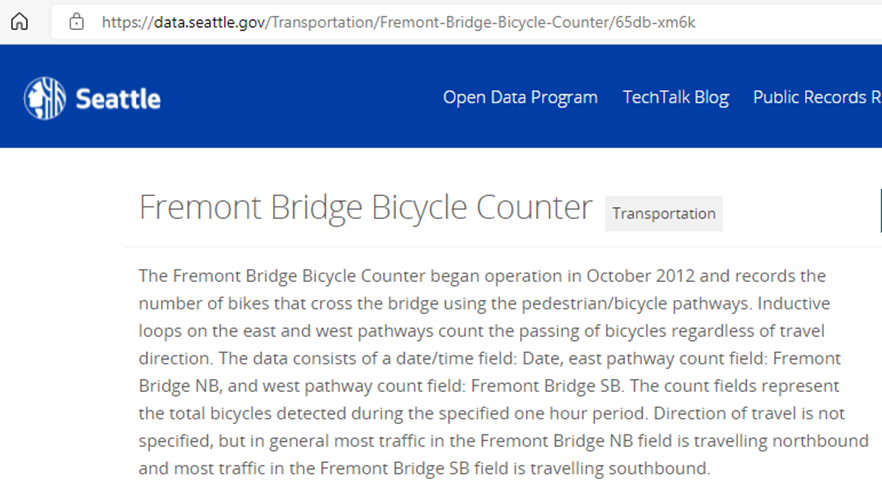  

This is a picture of the bridge.  The second picture shows the bicycle counter.  

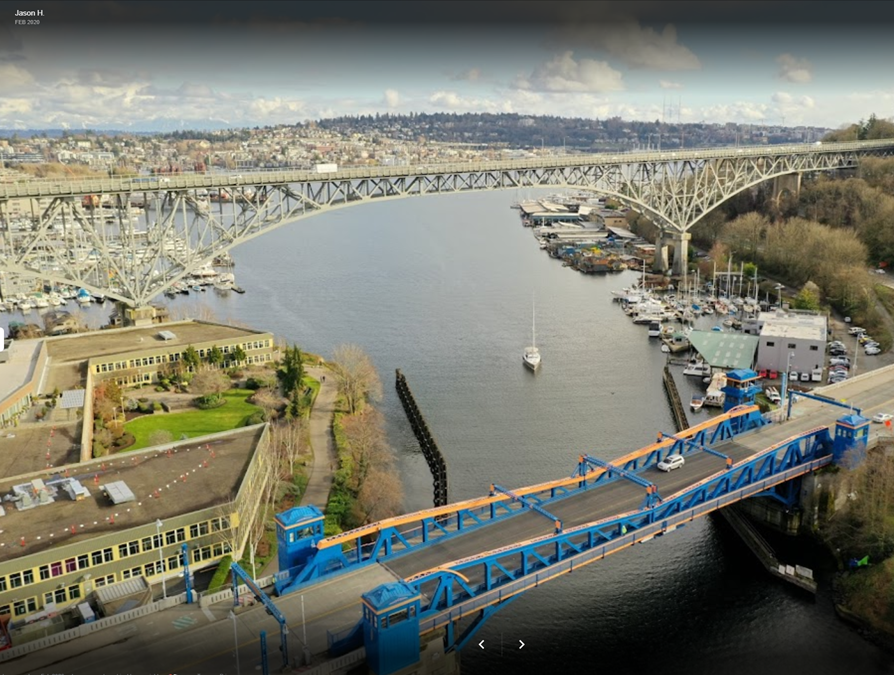
(Photo retrieved from a Google search, credit: Jason H, 2020))  

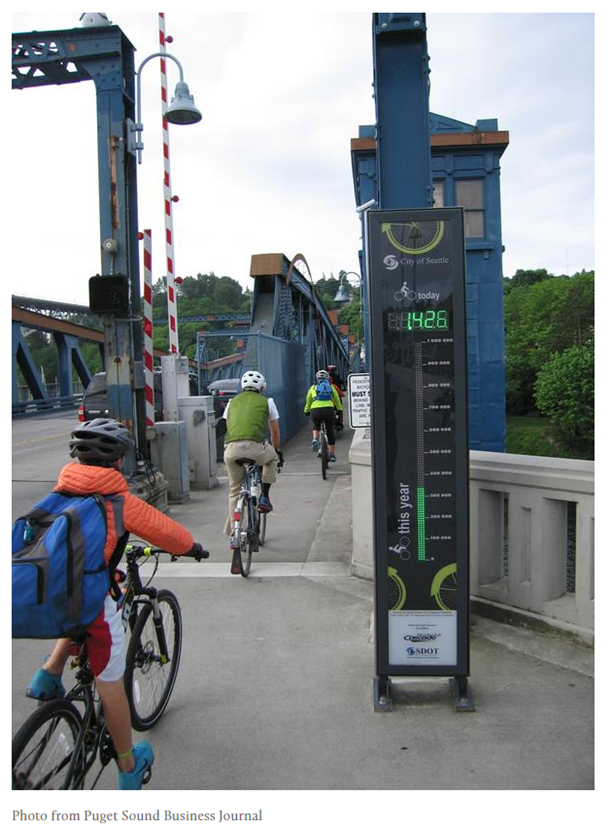  
(Photo retrieved from: http://www.sheridestoday.com/blog/2015/12/21/fremont-bridge-bike-counter)


In [2]:
# Load the data
# You can get more information on this dataset at 
# https://data.seattle.gov/Transportation/Fremont-Bridge-Bicycle-Counter/65db-xm6k

df = pd.read_csv('https://data.seattle.gov/api/views/65db-xm6k/rows.csv')

In [3]:
# Review the column names
df.columns

Index(['Date', 'Fremont Bridge Sidewalks, south of N 34th St',
       'Fremont Bridge Sidewalks, south of N 34th St Cyclist West Sidewalk',
       'Fremont Bridge Sidewalks, south of N 34th St Cyclist East Sidewalk'],
      dtype='object')

In [4]:
df

Date  Fremont Bridge Sidewalks, south of N 34th St  \
0       10/02/2012 01:00:00 PM                                          55.0   
1       10/02/2012 02:00:00 PM                                         130.0   
2       10/02/2012 03:00:00 PM                                         152.0   
3       10/02/2012 04:00:00 PM                                         278.0   
4       10/02/2012 05:00:00 PM                                         563.0   
...                        ...                                           ...   
100758  03/31/2024 07:00:00 PM                                          77.0   
100759  03/31/2024 08:00:00 PM                                          33.0   
100760  03/31/2024 09:00:00 PM                                          22.0   
100761  03/31/2024 10:00:00 PM                                          10.0   
100762  03/31/2024 11:00:00 PM                                           7.0   

        Fremont Bridge Sidewalks, south of N 34th St Cyclist West Sidewalk  \
0                                                     7.0                    
1                                                    55.0                    
2                                                    81.0                    
3                                                   167.0                    
4                                                   393.0                    
...                                                   ...                    
100758                                               32.0                    
100759                                               13.0                    
100760                                               10.0                    
100761                                                5.0                    
100762                                                5.0                    

        Fremont Bridge Sidewalks, south of N 34th St Cyclist East Sidewalk  
0                                                    48.0                   
1                                                    75.0                   
2                                                    71.0                   
3                                                   111.0                   
4                                                   170.0                   
...                                                   ...                   
100758                                               45.0                   
100759                                               20.0                   
100760                                               12.0                   
100761                                                5.0                   
100762                                                2.0                   

[100763 rows x 4 columns]

In [5]:
# df.to_excel('Bridge_crossing_data_07Nov2023.xlsx')

We have hourly data on bicycle crossings with three columns, Total = East + West sidewalks.  Our data is from 2012 all the way to July 2021, totaling 143k+ rows.  

For doing time series analysis with Pandas, the data frame's index should be equal to the datetime for the row.

For convenience, we also rename the column names to be ['Total', 'East', 'West'].  


In [6]:
# Set the index of the time series
df.index = pd.DatetimeIndex(df.Date)

In [7]:
# Now drop the Date column as it is a part of the index
df.drop(columns='Date', inplace=True)

In [8]:
df.head()

Fremont Bridge Sidewalks, south of N 34th St  \
Date                                                                
2012-10-02 13:00:00                                          55.0   
2012-10-02 14:00:00                                         130.0   
2012-10-02 15:00:00                                         152.0   
2012-10-02 16:00:00                                         278.0   
2012-10-02 17:00:00                                         563.0   

                     Fremont Bridge Sidewalks, south of N 34th St Cyclist West Sidewalk  \
Date                                                                                      
2012-10-02 13:00:00                                                7.0                    
2012-10-02 14:00:00                                               55.0                    
2012-10-02 15:00:00                                               81.0                    
2012-10-02 16:00:00                                              167.0                    
2012-10-02 17:00:00                                              393.0                    

                     Fremont Bridge Sidewalks, south of N 34th St Cyclist East Sidewalk  
Date                                                                                     
2012-10-02 13:00:00                                               48.0                   
2012-10-02 14:00:00                                               75.0                   
2012-10-02 15:00:00                                               71.0                   
2012-10-02 16:00:00                                              111.0                   
2012-10-02 17:00:00                                              170.0

In [9]:
# Rename the columns to make them simpler to use
df.columns = ['Total', 'East', 'West']

## Data Exploration

In [10]:
df.shape

(100763, 3)

In [11]:
# Check the maximum and the minimum dates in our data
print(df.index.max())
print(df.index.min())

2024-03-31 23:00:00
2012-10-02 13:00:00


In [12]:
# Let us drop NaN values
df.dropna(inplace=True)
df.shape

(100735, 3)

In [13]:
# Let us look at some sample rows
df.head(10)

Total   East   West
Date                                    
2012-10-02 13:00:00   55.0    7.0   48.0
2012-10-02 14:00:00  130.0   55.0   75.0
2012-10-02 15:00:00  152.0   81.0   71.0
2012-10-02 16:00:00  278.0  167.0  111.0
2012-10-02 17:00:00  563.0  393.0  170.0
2012-10-02 18:00:00  381.0  236.0  145.0
2012-10-02 19:00:00  175.0  104.0   71.0
2012-10-02 20:00:00   86.0   51.0   35.0
2012-10-02 21:00:00   63.0   35.0   28.0
2012-10-02 22:00:00   42.0   27.0   15.0

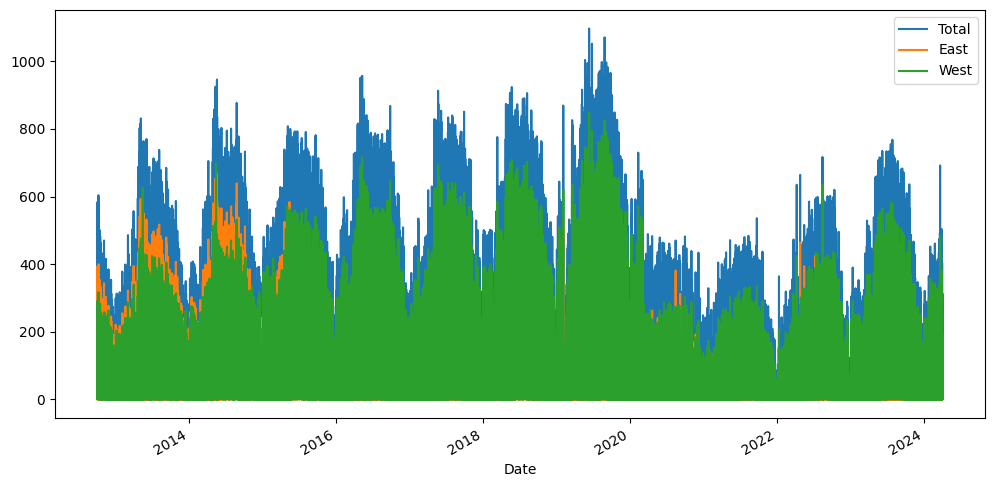

In [14]:
# We plot the data 
# Pandas knows that this is a time-series, and creates the right plot

df.plot(kind = 'line',figsize=(12,6));

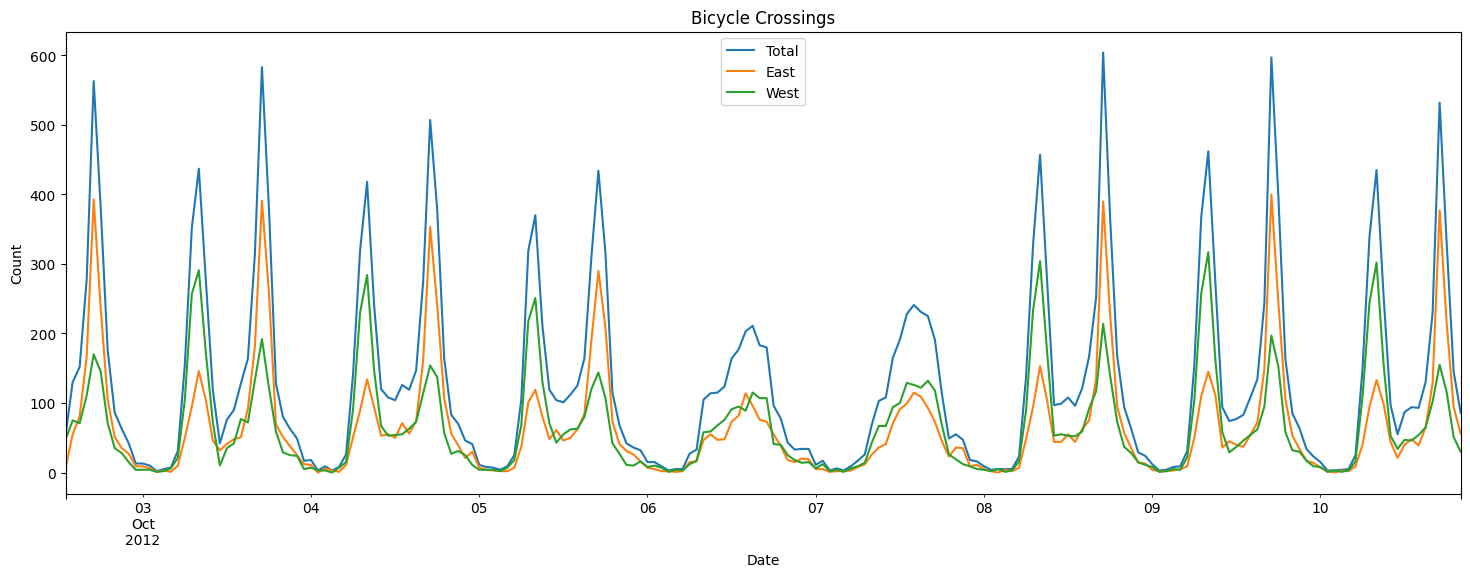

In [15]:
# Let us look at just the first 200 data points

title='Bicycle Crossings'
ylabel='Count'
xlabel='Date'


ax = df.iloc[:200,:].plot(figsize=(18,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Resampling

`resample()` is a time-based groupby pandas has a simple, powerful, and efficient functionality for performing resampling operations during frequency conversion (e.g., converting secondly data into 5-minutely data). This is extremely common in, but not limited to, financial applications.  

The resample function is very flexible and allows you to specify many different parameters to control the frequency conversion and resampling operation.  

Many functions are available as a method of the returned object, including sum, mean, std, sem, max, min, median, first, last, ohlc.  


| Alias | Description | 
| --- | --- | 
| B | business day frequency | 
| D | calendar day frequency | 
| W | weekly frequency | 
| M | month end frequency | 
| SM | semi-month end frequency (15th and end of month) | 
| BM | business month end frequency | 
| MS | month start frequency | 
| Q | quarter end frequency | 
| A, Y | year end frequency | 
| H | hourly frequency | 
| T, min | minutely frequency | 
| S | secondly frequency | 
| N | nanoseconds | 



C:\Users\user\AppData\Local\Temp\ipykernel_19996\2536642628.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.resample(rule='M').sum().plot(figsize = (18,6));


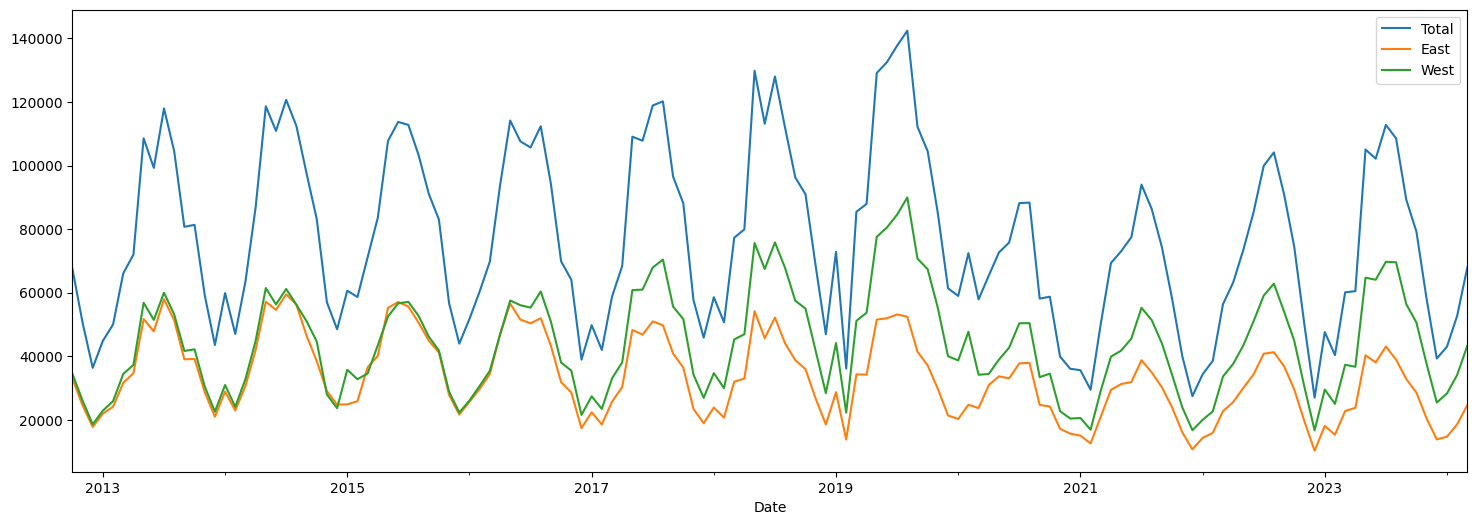

In [16]:
# Let us resample the data to be monthly

df.resample(rule='ME').sum().plot(figsize = (18,6));

In [17]:
# Let us examine monthly data
# We create a new monthly dataframe

df_monthly = df.resample(rule='ME').sum()

C:\Users\user\AppData\Local\Temp\ipykernel_19996\1146263502.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample(rule='M').sum()


In [18]:
# Just to keep our analysis clean and be able to understand concepts,
# we will limit ourselves to pre-Covid data

df_precovid = df_monthly[df_monthly.index < pd.to_datetime('2019-12-31')]

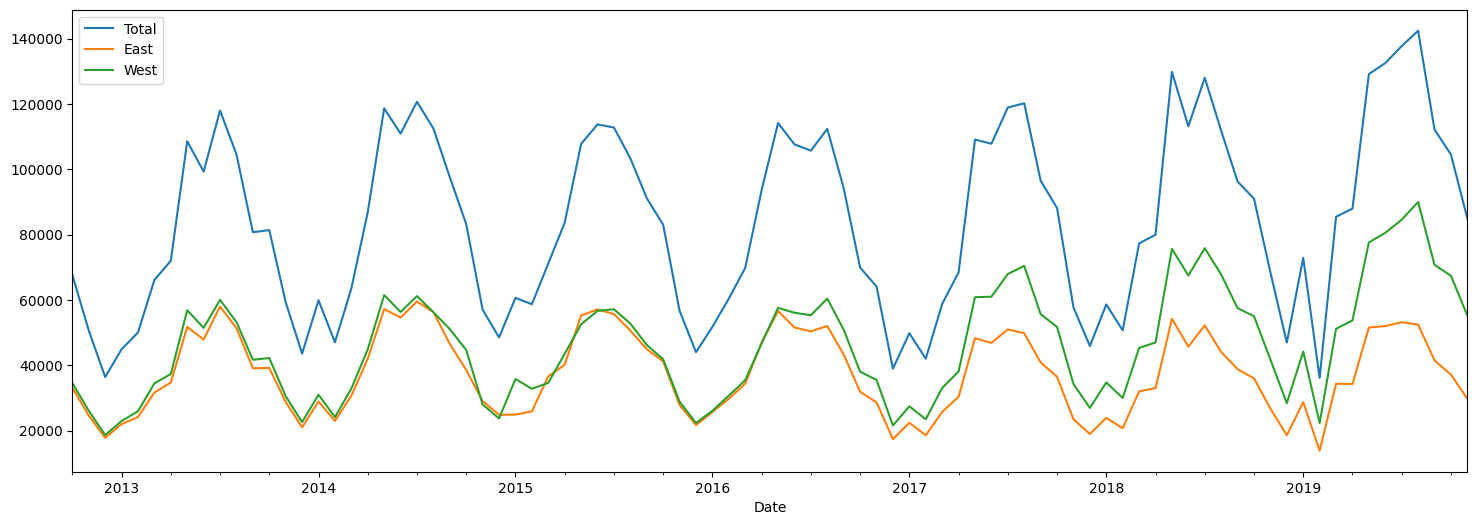

In [19]:
df_precovid.plot(figsize = (18,6));

In [20]:
# We suppress some warnings pandas produces, more for 
# visual cleanliness than any other reason

pd.options.mode.chained_assignment = None 

In [21]:
df_monthly

Total     East     West
Date                                 
2012-10-31  67633.0  33096.0  34537.0
2012-11-30  50647.0  24585.0  26062.0
2012-12-31  36369.0  17761.0  18608.0
2013-01-31  44884.0  21974.0  22910.0
2013-02-28  50027.0  24129.0  25898.0
...             ...      ...      ...
2023-11-30  58015.0  20427.0  37588.0
2023-12-31  39303.0  13852.0  25451.0
2024-01-31  43027.0  14722.0  28305.0
2024-02-29  52749.0  18611.0  34138.0
2024-03-31  67998.0  24659.0  43339.0

[138 rows x 3 columns]

### Filtering time series
Source: https://pandas.pydata.org/docs/user_guide/timeseries.html#indexing

Using the index for time series provides us the advantage of being able to filter easily by year or month.

for example, you can do `df.loc['2017']` to list all observations for 2017, or `df.loc['2017-02']`, or `df.loc['2017-02-15']`.



In [22]:
df.loc['2017-02-15']

Total   East   West
Date                                    
2017-02-15 00:00:00    4.0    3.0    1.0
2017-02-15 01:00:00    3.0    1.0    2.0
2017-02-15 02:00:00    0.0    0.0    0.0
2017-02-15 03:00:00    2.0    0.0    2.0
2017-02-15 04:00:00    2.0    1.0    1.0
2017-02-15 05:00:00   18.0    8.0   10.0
2017-02-15 06:00:00   60.0   45.0   15.0
2017-02-15 07:00:00  188.0  117.0   71.0
2017-02-15 08:00:00  262.0  152.0  110.0
2017-02-15 09:00:00  147.0   68.0   79.0
2017-02-15 10:00:00   49.0   25.0   24.0
2017-02-15 11:00:00   23.0   13.0   10.0
2017-02-15 12:00:00   12.0    7.0    5.0
2017-02-15 13:00:00   22.0    9.0   13.0
2017-02-15 14:00:00   17.0    2.0   15.0
2017-02-15 15:00:00   47.0   22.0   25.0
2017-02-15 16:00:00   99.0   29.0   70.0
2017-02-15 17:00:00  272.0   54.0  218.0
2017-02-15 18:00:00  181.0   48.0  133.0
2017-02-15 19:00:00   76.0   16.0   60.0
2017-02-15 20:00:00   43.0   14.0   29.0
2017-02-15 21:00:00   15.0    5.0   10.0
2017-02-15 22:00:00   16.0    6.0   10.0
2017-02-15 23:00:00    3.0    1.0    2.0

In [23]:
df.loc['2018']

Total  East  West
Date                                  
2018-01-01 00:00:00   28.0  14.0  14.0
2018-01-01 01:00:00   16.0   2.0  14.0
2018-01-01 02:00:00    8.0   4.0   4.0
2018-01-01 03:00:00    2.0   2.0   0.0
2018-01-01 04:00:00    0.0   0.0   0.0
...                    ...   ...   ...
2018-12-31 19:00:00   14.0   9.0   5.0
2018-12-31 20:00:00   26.0  12.0  14.0
2018-12-31 21:00:00   14.0   7.0   7.0
2018-12-31 22:00:00    7.0   3.0   4.0
2018-12-31 23:00:00   13.0   7.0   6.0

[8759 rows x 3 columns]

In [24]:
df.loc['2018-02']

Total  East  West
Date                                  
2018-02-01 00:00:00    8.0   2.0   6.0
2018-02-01 01:00:00    3.0   2.0   1.0
2018-02-01 02:00:00    0.0   0.0   0.0
2018-02-01 03:00:00    6.0   3.0   3.0
2018-02-01 04:00:00    8.0   5.0   3.0
...                    ...   ...   ...
2018-02-28 19:00:00   77.0  17.0  60.0
2018-02-28 20:00:00   35.0   7.0  28.0
2018-02-28 21:00:00   32.0  14.0  18.0
2018-02-28 22:00:00   13.0   2.0  11.0
2018-02-28 23:00:00    9.0   3.0   6.0

[672 rows x 3 columns]

**You can also use the regular methods for filtering date ranges**

In [25]:
df[(df.index > pd.to_datetime('1/31/2020')) & (df.index < pd.to_datetime('1/1/2022'))]

Total  East  West
Date                                  
2020-01-31 01:00:00    1.0   0.0   1.0
2020-01-31 02:00:00    0.0   0.0   0.0
2020-01-31 03:00:00    0.0   0.0   0.0
2020-01-31 04:00:00    8.0   6.0   2.0
2020-01-31 05:00:00   14.0   7.0   7.0
...                    ...   ...   ...
2021-12-31 19:00:00    0.0   0.0   0.0
2021-12-31 20:00:00    0.0   0.0   0.0
2021-12-31 21:00:00    0.0   0.0   0.0
2021-12-31 22:00:00    0.0   0.0   0.0
2021-12-31 23:00:00    0.0   0.0   0.0

[16821 rows x 3 columns]

**Sometimes, the date may be contained in a column.**

In such cases, we filter as follows:

In [26]:
# We create a temporary dataframe to illustrate
temporary_df = df.loc['2017-01'].copy()
temporary_df.reset_index(inplace = True)
temporary_df

Date  Total  East  West
0   2017-01-01 00:00:00    5.0   0.0   5.0
1   2017-01-01 01:00:00   19.0   5.0  14.0
2   2017-01-01 02:00:00    1.0   1.0   0.0
3   2017-01-01 03:00:00    2.0   0.0   2.0
4   2017-01-01 04:00:00    1.0   0.0   1.0
..                  ...    ...   ...   ...
739 2017-01-31 19:00:00  116.0  27.0  89.0
740 2017-01-31 20:00:00   64.0  25.0  39.0
741 2017-01-31 21:00:00   32.0  19.0  13.0
742 2017-01-31 22:00:00   19.0   4.0  15.0
743 2017-01-31 23:00:00   15.0   6.0   9.0

[744 rows x 4 columns]

**You can use resample on a column instead of the index by providing the `on` argument**

In [49]:
temporary_df.resample(on='Date', rule="ME").sum()

Total     East     West
Date                                 
2017-01-31  49805.0  22388.0  27417.0

**How to groupby day of the week, or month**

In such cases, we filter as follows:

In [48]:
# You can filter for a particular day, day of the week, or month
temporary_df[temporary_df['Date'].dt.day==2]

Date  Total  East  West
24 2017-01-02 00:00:00    1.0   0.0   1.0
25 2017-01-02 01:00:00    1.0   0.0   1.0
26 2017-01-02 02:00:00    1.0   1.0   0.0
27 2017-01-02 03:00:00    1.0   1.0   0.0
28 2017-01-02 04:00:00    1.0   0.0   1.0
29 2017-01-02 05:00:00    4.0   2.0   2.0
30 2017-01-02 06:00:00   11.0   7.0   4.0
31 2017-01-02 07:00:00   17.0  13.0   4.0
32 2017-01-02 08:00:00   29.0  17.0  12.0
33 2017-01-02 09:00:00   32.0  21.0  11.0
34 2017-01-02 10:00:00   43.0  20.0  23.0
35 2017-01-02 11:00:00   47.0  21.0  26.0
36 2017-01-02 12:00:00   55.0  27.0  28.0
37 2017-01-02 13:00:00   58.0  27.0  31.0
38 2017-01-02 14:00:00   73.0  36.0  37.0
39 2017-01-02 15:00:00   66.0  37.0  29.0
40 2017-01-02 16:00:00   54.0  25.0  29.0
41 2017-01-02 17:00:00   45.0  19.0  26.0
42 2017-01-02 18:00:00   31.0  16.0  15.0
43 2017-01-02 19:00:00   17.0   4.0  13.0
44 2017-01-02 20:00:00   12.0   6.0   6.0
45 2017-01-02 21:00:00   15.0   8.0   7.0
46 2017-01-02 22:00:00    4.0   3.0   1.0
47 2017-01-02 23:00:00    5.0   3.0   2.0

For month, use `temporary_df['Date'].dt.month`, and for day of week (Sun, Mon etc) use `temporary_df['Date'].dt.weekday`

In [46]:
# Day of week
temporary_df.groupby(temporary_df['Date'].dt.weekday).count()

Date  Total  East  West
Date                         
0      120    120   120   120
1      120    120   120   120
2       96     96    96    96
3       96     96    96    96
4       96     96    96    96
5       96     96    96    96
6      120    120   120   120

In [27]:
# Month
temporary_df[temporary_df['Date'].dt.month == 1]

# or use temporary_df['Date'].dt.day and year as well

Date  Total  East  West
0   2017-01-01 00:00:00    5.0   0.0   5.0
1   2017-01-01 01:00:00   19.0   5.0  14.0
2   2017-01-01 02:00:00    1.0   1.0   0.0
3   2017-01-01 03:00:00    2.0   0.0   2.0
4   2017-01-01 04:00:00    1.0   0.0   1.0
..                  ...    ...   ...   ...
739 2017-01-31 19:00:00  116.0  27.0  89.0
740 2017-01-31 20:00:00   64.0  25.0  39.0
741 2017-01-31 21:00:00   32.0  19.0  13.0
742 2017-01-31 22:00:00   19.0   4.0  15.0
743 2017-01-31 23:00:00   15.0   6.0   9.0

[744 rows x 4 columns]

In [35]:
temporary_df.groupby(pd.Grouper(key='Date', freq="ME")).count()

Total  East  West
Date                         
2017-01-31    744   744   744

**You can use pd.Grouper if you want use groupby on a time series**

It gives you the same result as resample.

In [43]:
df.groupby(pd.Grouper(freq="ME")).sum()

Total     East     West
Date                                 
2012-10-31  67633.0  33096.0  34537.0
2012-11-30  50647.0  24585.0  26062.0
2012-12-31  36369.0  17761.0  18608.0
2013-01-31  44884.0  21974.0  22910.0
2013-02-28  50027.0  24129.0  25898.0
...             ...      ...      ...
2023-11-30  58015.0  20427.0  37588.0
2023-12-31  39303.0  13852.0  25451.0
2024-01-31  43027.0  14722.0  28305.0
2024-02-29  52749.0  18611.0  34138.0
2024-03-31  67998.0  24659.0  43339.0

[138 rows x 3 columns]

In [45]:
# The below gives us the same result
df.resample("ME").sum()

Total     East     West
Date                                 
2012-10-31  67633.0  33096.0  34537.0
2012-11-30  50647.0  24585.0  26062.0
2012-12-31  36369.0  17761.0  18608.0
2013-01-31  44884.0  21974.0  22910.0
2013-02-28  50027.0  24129.0  25898.0
...             ...      ...      ...
2023-11-30  58015.0  20427.0  37588.0
2023-12-31  39303.0  13852.0  25451.0
2024-01-31  43027.0  14722.0  28305.0
2024-02-29  52749.0  18611.0  34138.0
2024-03-31  67998.0  24659.0  43339.0

[138 rows x 3 columns]

### Plot by month and quarter

In [28]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

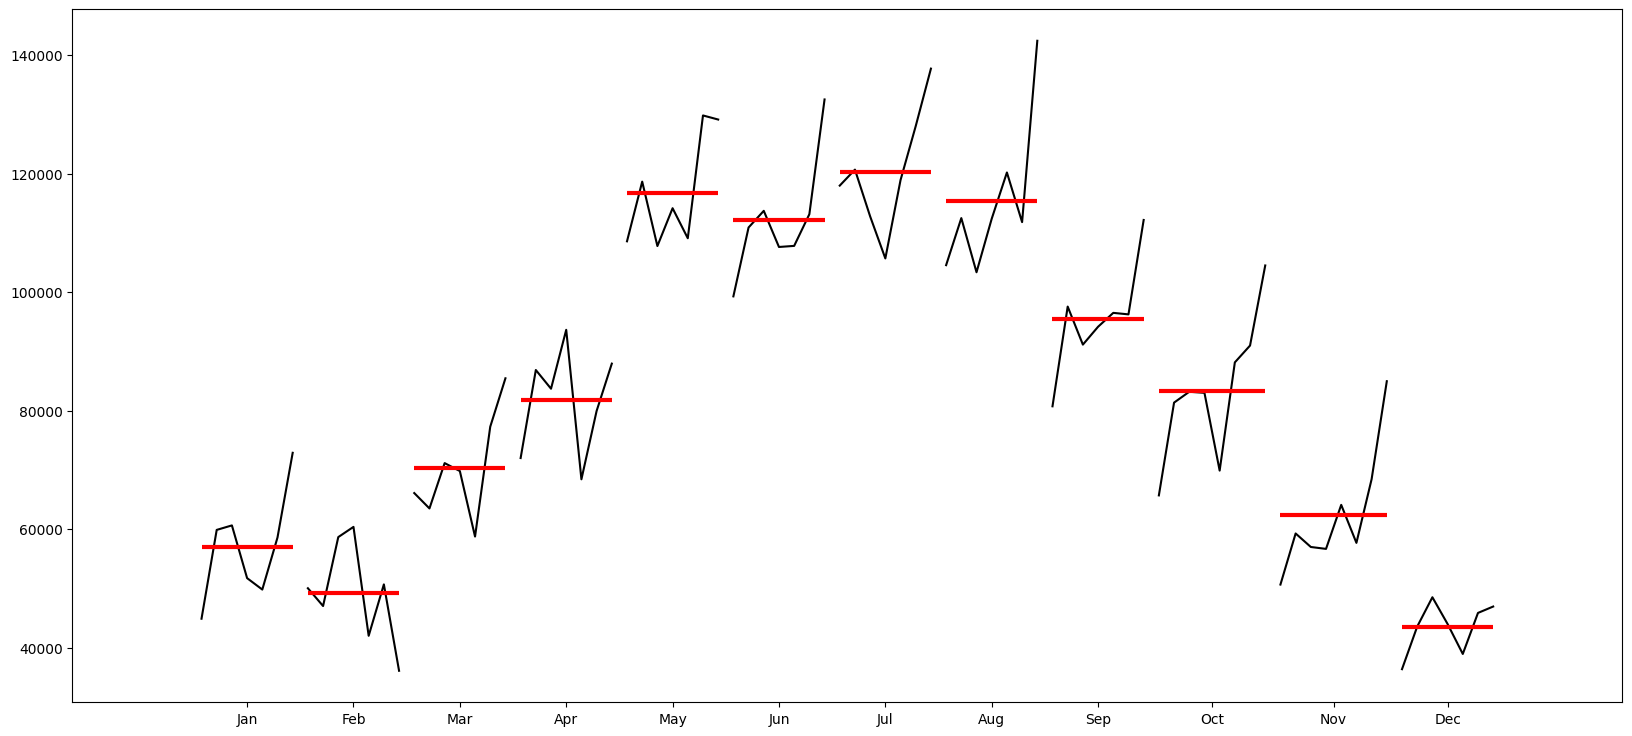

In [29]:
# Plot the months to see trends over months
month_plot(df_precovid.Total);

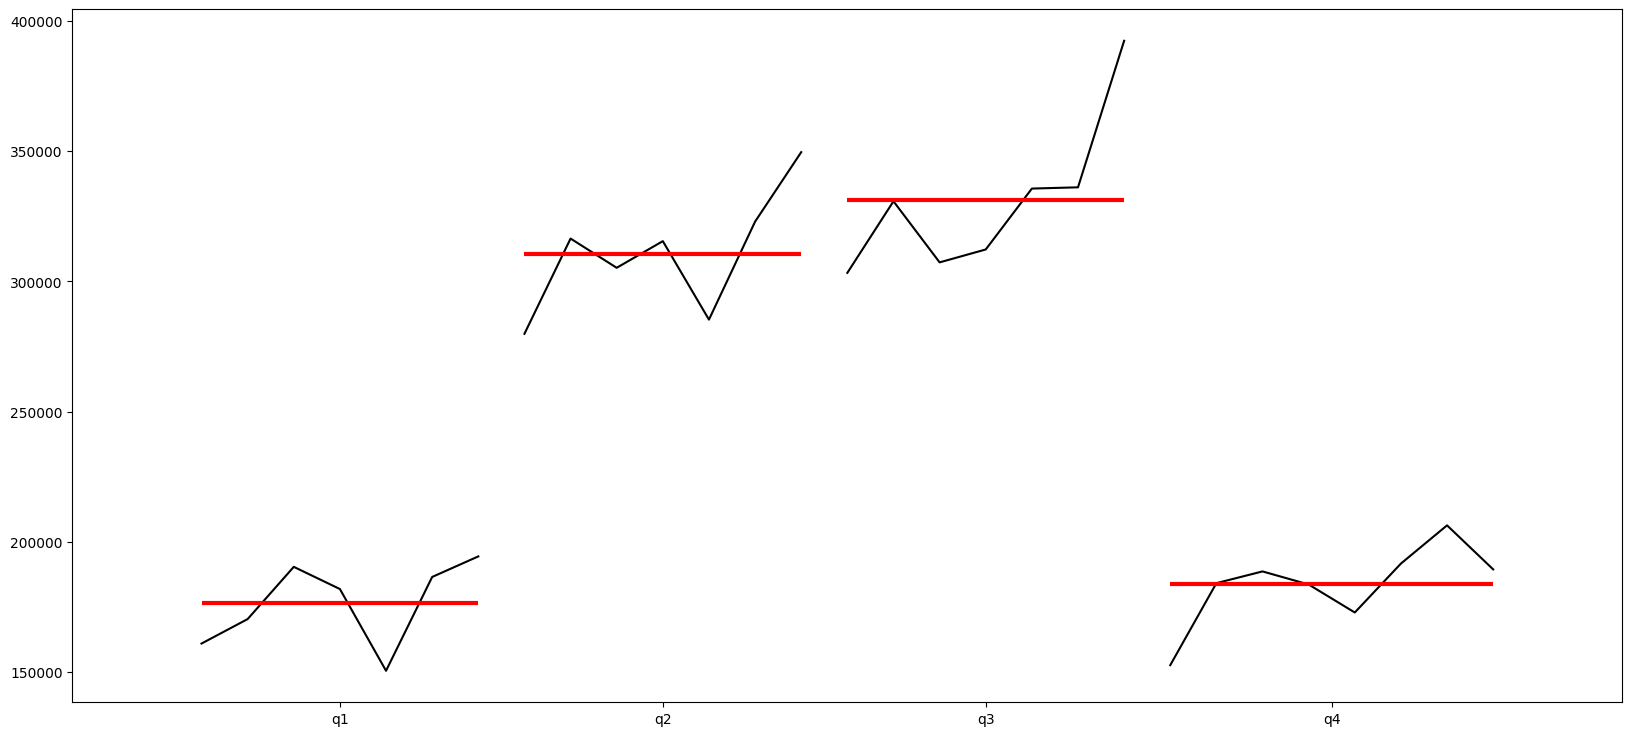

In [30]:
# Plot the quarter to see trends over quarters
quarter_plot(df_precovid.resample(rule='Q').Total.sum());

## ETS Decomposition

When we decompose a time series, we are essentially expressing a belief that our data has several discrete components to it, each which can be isolated and studied separately.  

Generally, time series data is split into 3 components: error, trend and seasonality (hence ‘ETS Decomposition’):  
 1. Seasonal component  
 2. Trend/cycle component  
 2. Residual, or error component which is not explained by the above two.  
 
 **Multiplicative vs Additive Decomposition**   
If we assume an additive decomposition, then we can write:  

$y_t = S_t + T_t + R_t$  
where $y_t$ is the data,  
- $S_t$ is the seasonal component,  
- $T_t$ is the trend-cycle component, and  
- $R_t$ is the remainder component
at time period $t$.
 
A multiplicative decomposition would be similarly written  
$y_t = S_t * T_t * R_t$  

The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, or the variation around the trend-cycle, does not vary with the level of the time series.  

When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative decomposition is more appropriate. Multiplicative decompositions are common with economic time series.  

 - Components are additive when the components do not change over time, and  
 - Components are multiplicative when their levels are changing with time. 

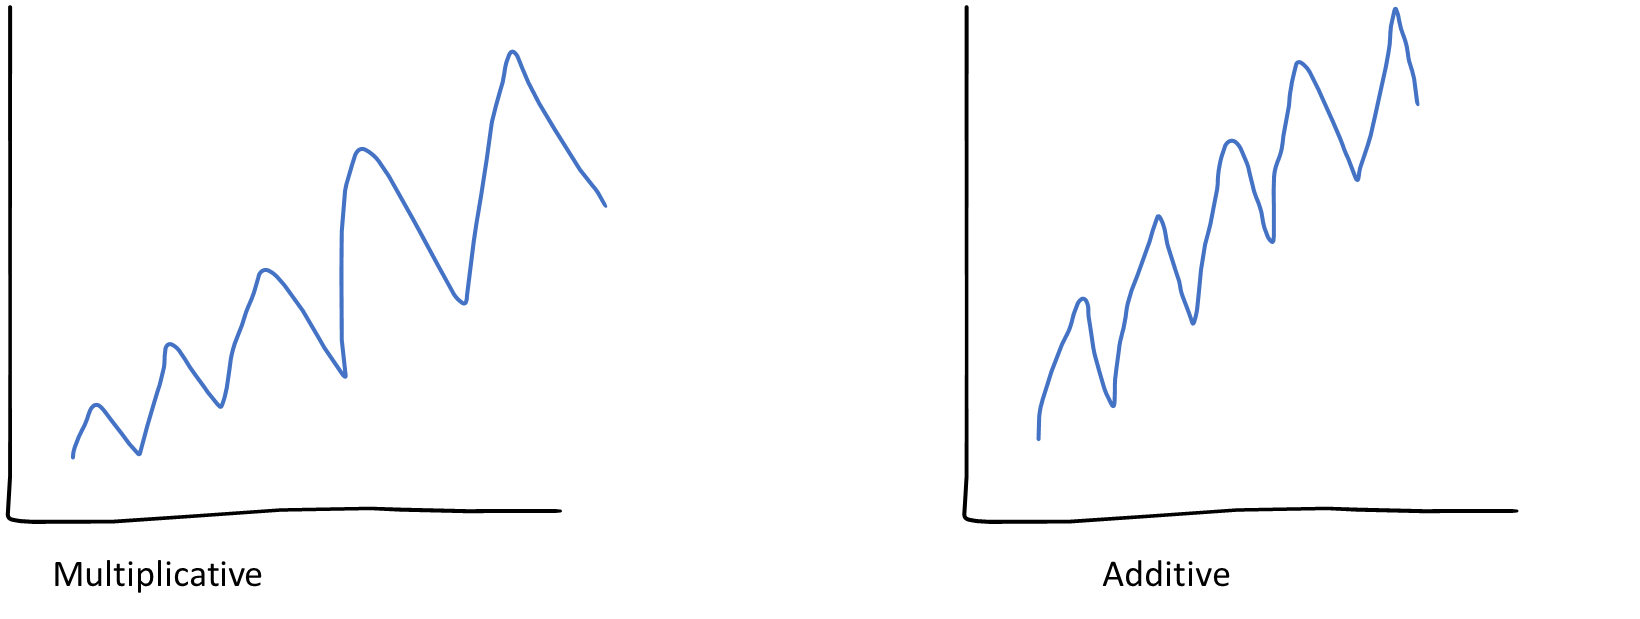



### Multiplicative  
The Statsmodels library gives us the functionality to decompose time series.  Below, we decompose the time series using multiplicative decomposition.   Let us spend a couple of moments looking at the chart below.  Note that the first panel, **‘Total’**, is the sum of the other three, ie Trend, Seasonal and Resid.

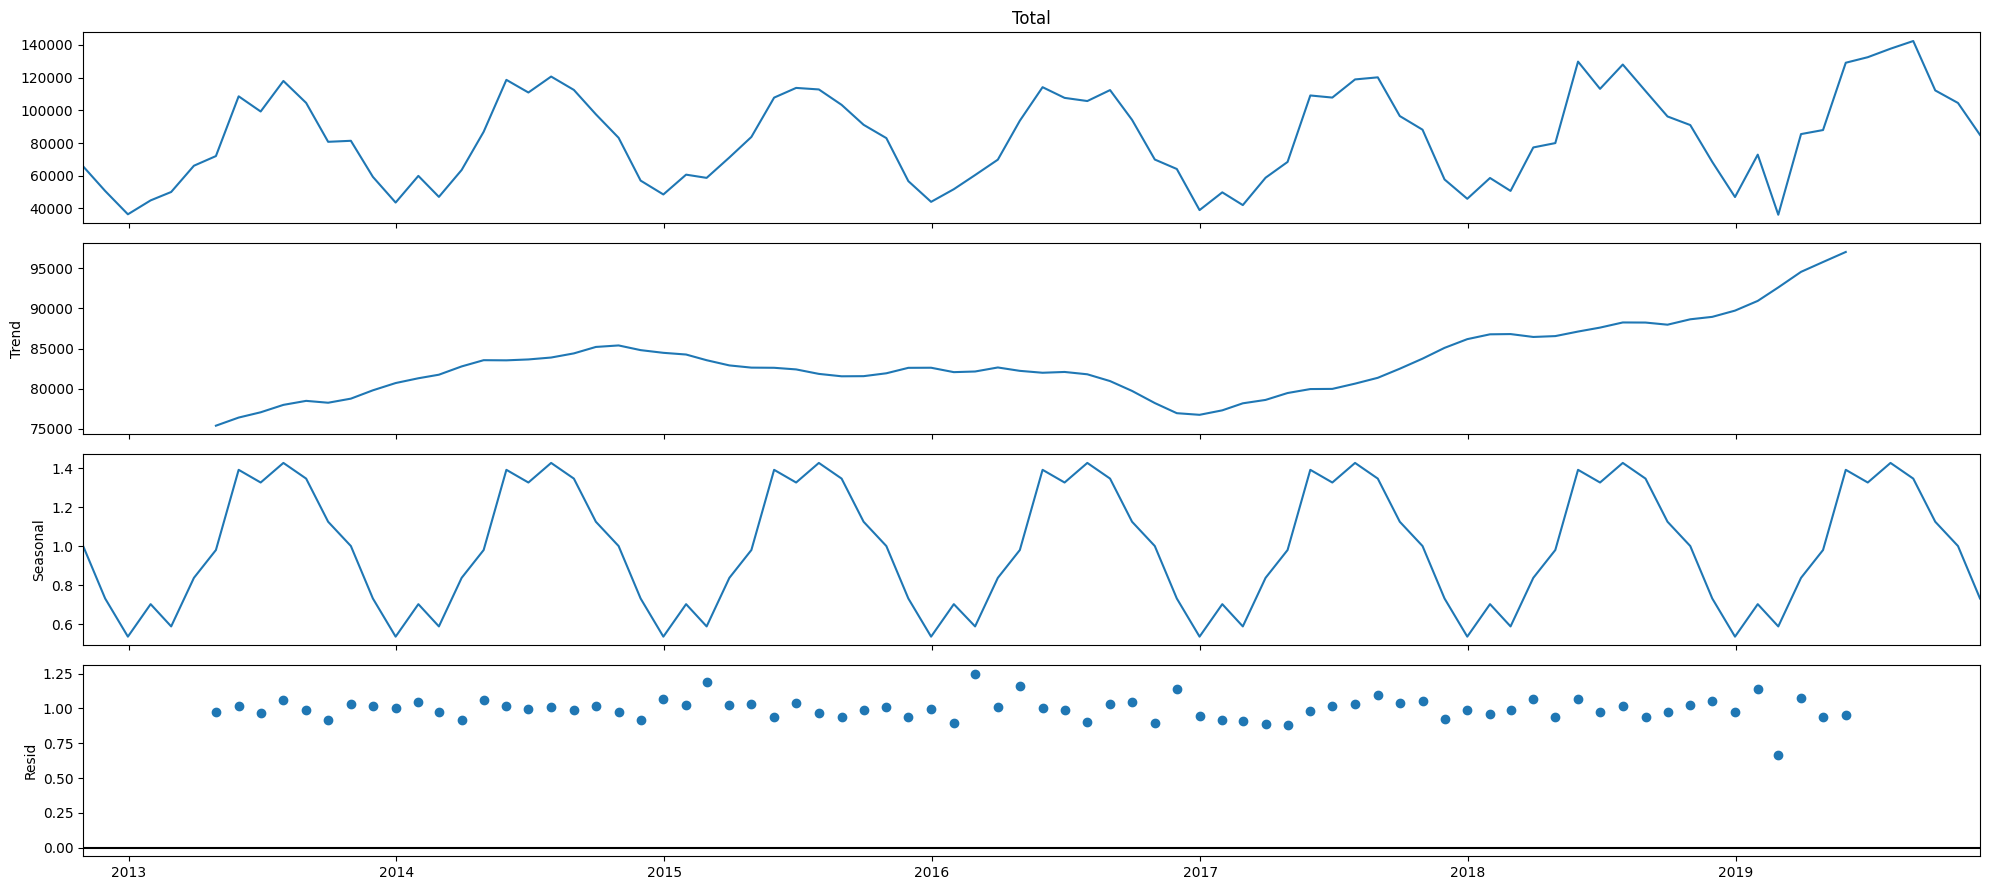

In [31]:
# Now we decompose our time series

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# We use the multiplicative model

result = seasonal_decompose(df_precovid['Total'], model = 'multiplicative') 
plt.rcParams['figure.figsize'] = (20, 9)
result.plot();

In [32]:
# Each of the above components are contained in our `result`
# object as trend, seasonal and error.
# Let us put them in a dataframe
ets = pd.DataFrame({'Total': df_precovid['Total'], 
              'trend': result.trend, 
              'seasonality': result.seasonal, 
              'error': result.resid}).head(20)
# ets.to_excel('ets_mul.xlsx')
ets

Total         trend  seasonality     error
Date                                                     
2012-10-31   65695.0           NaN     1.001160       NaN
2012-11-30   50647.0           NaN     0.731912       NaN
2012-12-31   36369.0           NaN     0.536130       NaN
2013-01-31   44884.0           NaN     0.702895       NaN
2013-02-28   50027.0           NaN     0.588604       NaN
2013-03-31   66089.0           NaN     0.837828       NaN
2013-04-30   71998.0  75386.958333     0.980757  0.973785
2013-05-31  108574.0  76398.625000     1.392398  1.020650
2013-06-30   99280.0  77057.250000     1.327268  0.970710
2013-07-31  117974.0  77981.125000     1.427836  1.059543
2013-08-31  104549.0  78480.583333     1.347373  0.988712
2013-09-30   80729.0  78247.375000     1.125840  0.916396
2013-10-31   81352.0  78758.291667     1.001160  1.031736
2013-11-30   59270.0  79796.916667     0.731912  1.014822
2013-12-31   43553.0  80700.958333     0.536130  1.006629
2014-01-31   59873.0  81297.708333     0.702895  1.047762
2014-02-28   47025.0  81740.875000     0.588604  0.977386
2014-03-31   63494.0  82772.958333     0.837828  0.915565
2014-04-30   86855.0  83550.500000     0.980757  1.059948
2014-05-31  118644.0  83531.833333     1.392398  1.020071

In [33]:
# Check if things work in the multiplicative model

print('Total = ', 71998.0)
print('Trend * Factor for Seasonality * Factor for Error =',75386.958333 * 0.980757 * 0.973785)


Total =  71998.0
Trend * Factor for Seasonality * Factor for Error = 71998.04732763417


### Additive  
We do the same thing as before, except that we change the model to be `additive`.

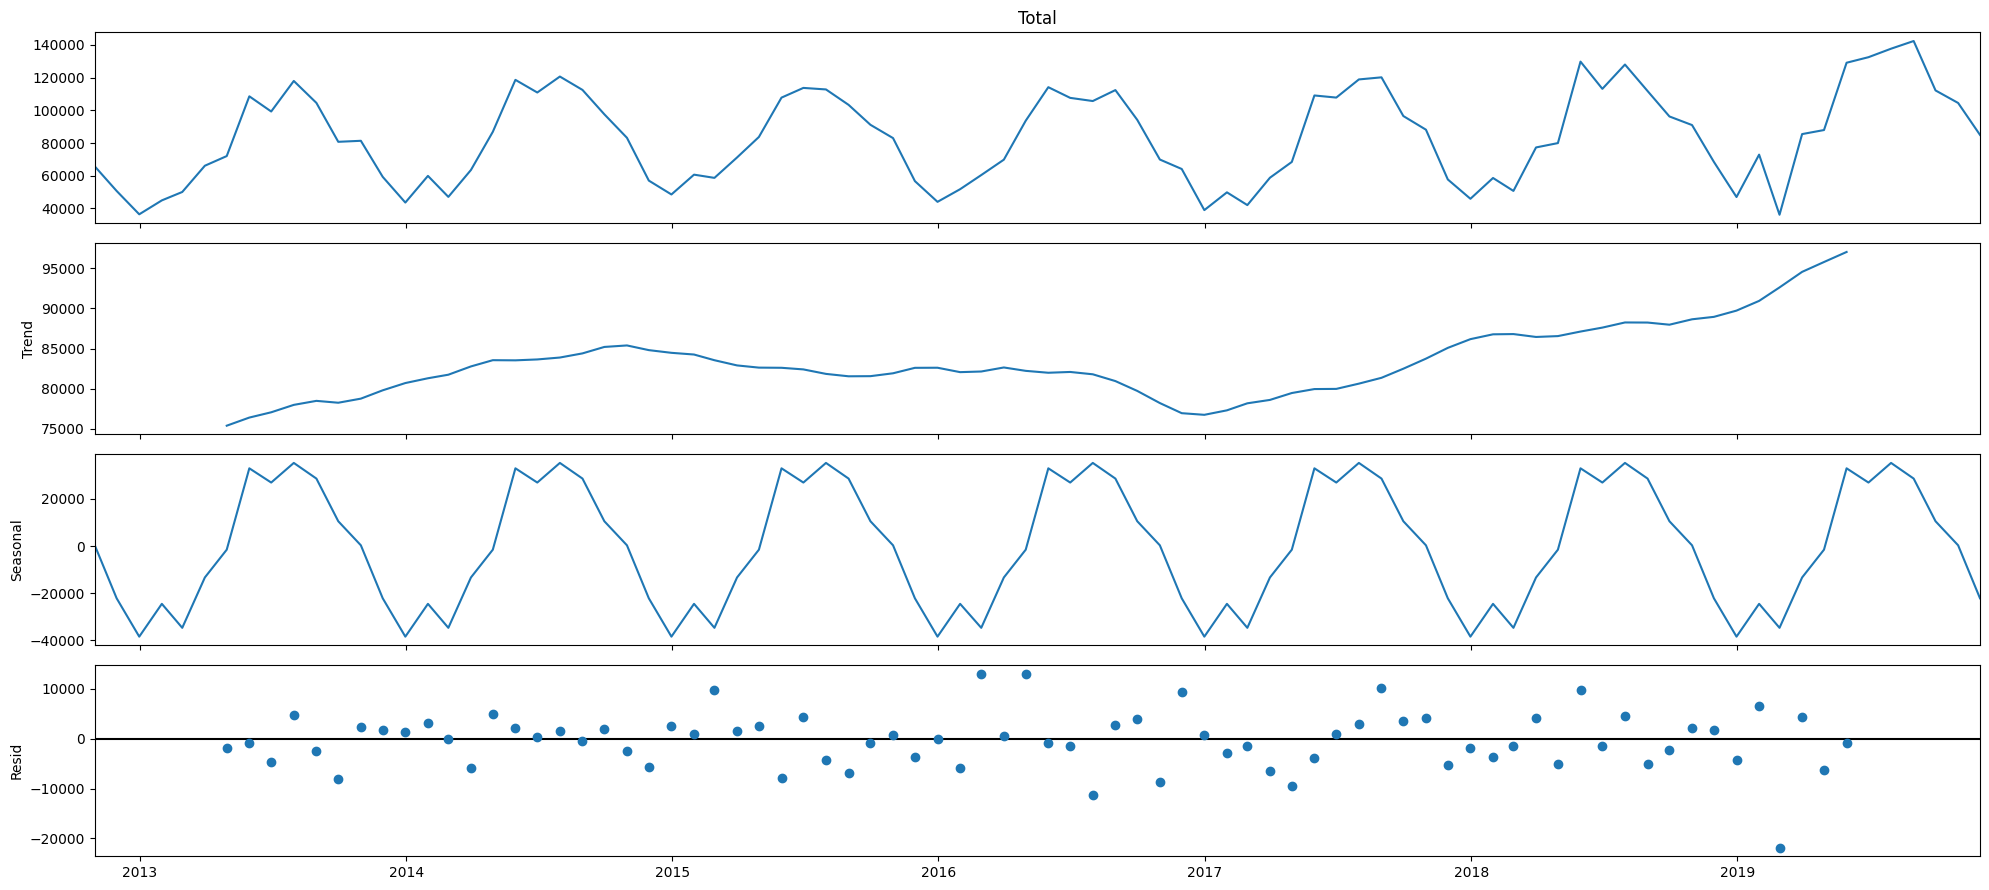

In [34]:
result = seasonal_decompose(df_precovid['Total'], model = 'additive') 
plt.rcParams['figure.figsize'] = (20, 9)
result.plot();

Here, an additive model seems to make sense. This is because the residuals seem to be better centered around zero.  

**Obtaining the components numerically**  
While this is great from a visual or graphical perspective, sometimes we may need to get the actual numbers for the three decomposed components.  We can do so easily - the code below provides us this data in a dataframe.

In [35]:
# Each of the above components are contained in our `result`
# object as trend, seasonal and error.
# Let us put them in a dataframe
ets = pd.DataFrame({'Total': df_precovid['Total'], 
              'trend': result.trend, 
              'seasonality': result.seasonal, 
              'error': result.resid}).head(20)
# ets.to_excel('ets_add.xlsx')
ets

Total         trend   seasonality        error
Date                                                         
2012-10-31   65695.0           NaN    315.920635          NaN
2012-11-30   50647.0           NaN -22171.933532          NaN
2012-12-31   36369.0           NaN -38436.746032          NaN
2013-01-31   44884.0           NaN -24517.440476          NaN
2013-02-28   50027.0           NaN -34696.308532          NaN
2013-03-31   66089.0           NaN -13329.627976          NaN
2013-04-30   71998.0  75386.958333  -1536.224206 -1852.734127
2013-05-31  108574.0  76398.625000  32985.115079  -809.740079
2013-06-30   99280.0  77057.250000  26951.087302 -4728.337302
2013-07-31  117974.0  77981.125000  35276.733135  4716.141865
2013-08-31  104549.0  78480.583333  28635.517857 -2567.101190
2013-09-30   80729.0  78247.375000  10523.906746 -8042.281746
2013-10-31   81352.0  78758.291667    315.920635  2277.787698
2013-11-30   59270.0  79796.916667 -22171.933532  1645.016865
2013-12-31   43553.0  80700.958333 -38436.746032  1288.787698
2014-01-31   59873.0  81297.708333 -24517.440476  3092.732143
2014-02-28   47025.0  81740.875000 -34696.308532   -19.566468
2014-03-31   63494.0  82772.958333 -13329.627976 -5949.330357
2014-04-30   86855.0  83550.500000  -1536.224206  4840.724206
2014-05-31  118644.0  83531.833333  32985.115079  2127.051587

In [36]:
ets.describe()

Total         trend   seasonality        error
count      20.000000     14.000000     20.000000    14.000000
mean    72844.050000  79692.997024  -5069.362252  -284.346372
std     25785.957067   2640.000168  25620.440647  3935.011207
min     36369.000000  75386.958333 -38436.746032 -8042.281746
25%     50492.000000  78047.687500 -24517.440476 -2388.509425
50%     65892.000000  79277.604167  -7432.926091   634.610615
75%     89961.250000  81630.083333  14630.701885  2240.103671
max    118644.000000  83550.500000  35276.733135  4840.724206

**What is this useful for?**  
 - Time series decomposition is primarily useful for studying time series data, and exploring historical trends over time.  
 - It is also useful for calculating 'seasonally adjusted' numbers, which is really just the trend number. The trend has no seasonality.  
 - Seasonally adjusted number = $y_t - S_t = T_t + R_t$
 - Note that seasons are different from cycles.  Cycles have no fixed length, and we can never be sure of when they begin, peak and end.  The timing of cycles is unpredictable.  


## Moving Average and Exponentially Weighted Moving Average  
Moving averages are an easy way to understand and describe time series.  

By using a sliding window along which observations are averaged, they can suppress seasonality and noise, and expose the trend.  

Moving averages are not generally used for forecasting, and don’t inform us about the future behavior of our time series.  Their huge advantage is they are simple to understand, and explain, and get to a high level view of what is in the data.

**Simple Moving Averages**  
Simple moving averages (SMA) tend to even out seasonality, and offer an easy way to examine the trend.  Consider the 6 month and 12 month moving averages in the graphic below.  SMAs are difficult to use for forecasting, and will lag by the window size.

**Exponentially Weighted Moving Average (EWMA)**  
EWMA is a more advanced method than SMA, and puts more weight on values that occurred more recently.  Forecasts produced using exponential smoothing methods are weighted averages of past observations, with the weights decaying exponentially as the observations get older. The more recent the observation, the higher the associated weight.  

This framework generates reliable forecasts quickly and for a wide range of time series, which is a great advantage and of major importance to applications in industry.

EWMA can be easily calculated using the `ewm()` function in pandas.  The parameter `adjust` controls how the EWMA term is calculated.  

 - When `adjust=True` (default), the EW function is calculated using weights $w_i = (1 - \alpha)^i$. For example, the EW moving average of the series [$x_0, x_1, ..., x_t$] would be: $y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ... + (1 -
\alpha)^t x_0}{1 + (1 - \alpha) + (1 - \alpha)^2 + ... + (1 - \alpha)^t}$  

 - When `adjust=False`, the exponentially weighted function is calculated recursively:  
$\begin{split}\begin{split}
y_0 &= x_0\\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,
\end{split}\end{split}$

(_Source: Pandas documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html_)

The alpha parameter can be specified in the formula in one of four ways:
 - **Alpha** specifies the smoothing factor directly.  Specify smoothing factor $\alpha$ directly $0 < \alpha \leq 1$
 - **Span** corresponds to what is commonly called an "N-day Exponentially Weighted Moving Average".  Specify decay in terms of span
$\alpha = 2 / (span + 1)$ , for $span \geq 1$.  
 - **COM** (Center of mass):   Specify decay in terms of center of mass
$\alpha = 1 / (1 + com)$ , for $com \geq 0$.
 - **Half-life** is the period of time for the exponential weight to reduce to one half.  Specify decay in terms of half-life
$\alpha = 1 - \exp\left(-\ln(2) / halflife\right)$ , for $halflife > 0$.  If `times` is specified, the time unit (str or timedelta) over which an observation decays to half its value. Only applicable to `mean()`, and halflife value will not apply to the other functions.
    


.

In [37]:
# let us look at rolling averages & EWM together

new_df = df_precovid[['Total']]
new_df['Moving_Avg_6m'] = new_df['Total'].rolling(window=6).mean()
new_df['Moving_Avg_12m'] = new_df['Total'].rolling(window=12).mean()

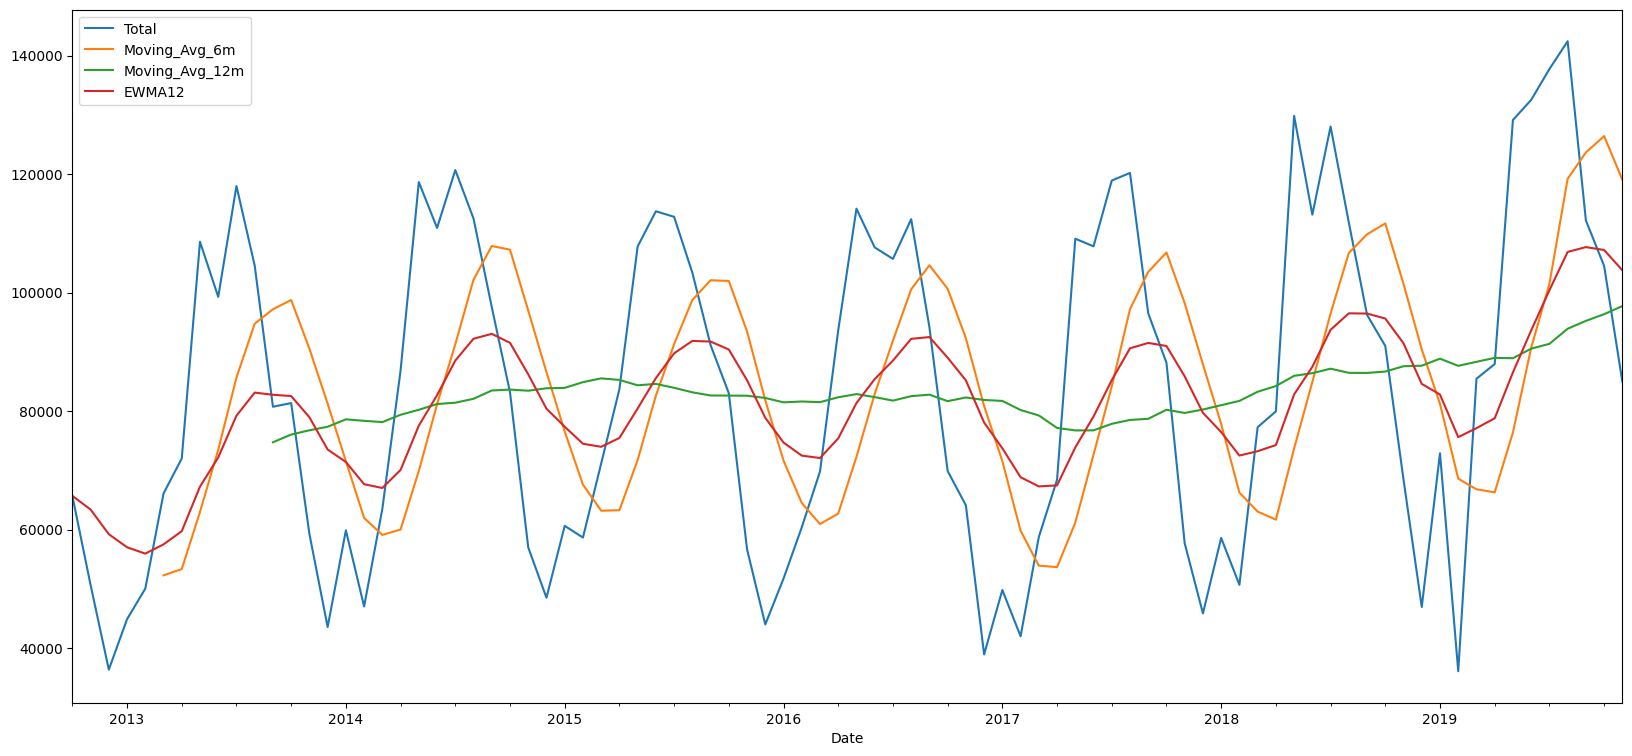

In [38]:
new_df['EWMA12'] = new_df['Total'].ewm(span=12,adjust=False).mean() 

# Note that available EW functions include mean(), var(), std(), corr(), cov().

new_df.plot();

In [39]:
# new_df.to_excel('temp.xlsx')

In [40]:
2/(12+1) 

0.15384615384615385

In the graph above, the red line is the EWMA with span=12, or alpha=2/(12+1) ≈ 0.15.  

EWMA has a single smoothing parameter, $\alpha$, and does not account for seasonality or trend.  It is only suitable for data with no clear trend or seasonal pattern.  

Note that we haven’t talked about forecasting yet – that comes next.  We have so far only ‘fitted’ the EWMA model to a given time series.  Know that EWMA is just a weighted average, with more (or less, depending on alpha) weight to recent observations.


***
## Stationarity  

**What is Stationarity?**  
A stationary series has constant mean and variance over time.  Which means there is no trend, and no seasonality either.  Stationarity is important for forecasting time series because if the mean and variance are changing with the passage of time, any estimates using a regression model will start to drift very quickly as we forecast into the future.  

If a time series is not stationary, we need to ‘difference’ it with itself so it becomes stationary.  Differencing means you subtract the previous observation from the current observation.  

**How do we know if a series is stationary?**  
 - We can examine stationarity by visually inspecting the time series.  
 - Or, we can run a statistical test (The Augmented Dickey-Fuller test) to check for stationarity.  

Fortunately, an ARIMA model takes care of most issues with non-stationarity for us and we do not need to adjust it.  However, if we are using ARMA, we do need to ensure that our series is stationary.  

Let us look at two real time series to get a sense of stationarity.  We import some stock price data, and also look at stock price returns.  We just pick the S&P500 index, though we could have picked any listed company.



In [41]:
# Let us get some data.  We download the daily time series for the S&P500 for 30 months
import yfinance as yf
SPY = yf.download('SPY', start = '2013-01-01', end = '2015-06-30')

[*********************100%%**********************]  1 of 1 completed


In [42]:
# Clean up
SPY.index = pd.DatetimeIndex(SPY.index) # Set index
SPY = SPY.asfreq('B') # This creates rows for any missing dates
SPY.fillna(method = 'bfill', inplace=True) # Fills missing dates with last observation

In [43]:
SPY.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 649 entries, 2013-01-02 to 2015-06-29
Freq: B
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       649 non-null    float64
 1   High       649 non-null    float64
 2   Low        649 non-null    float64
 3   Close      649 non-null    float64
 4   Adj Close  649 non-null    float64
 5   Volume     649 non-null    float64
dtypes: float64(6)
memory usage: 35.5 KB


**Example of stationary vs non-stationary time series**  
The top panel shows stock returns, that appear to have a mean close to zero.  The bottom is stock prices, which appear to have a trend

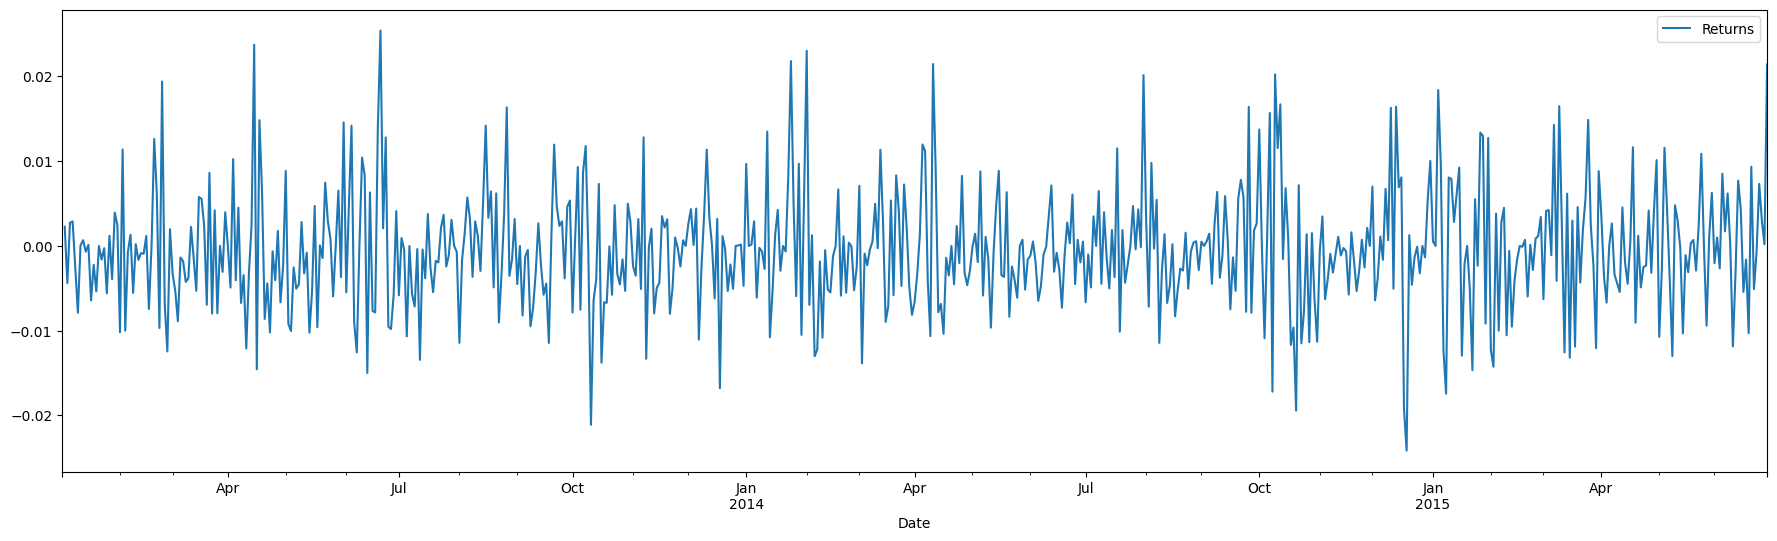

In [44]:
SPY['Returns'] = (SPY['Close'].shift(1) / SPY['Close']) - 1
SPY[['Returns']].plot(figsize = (22,6));


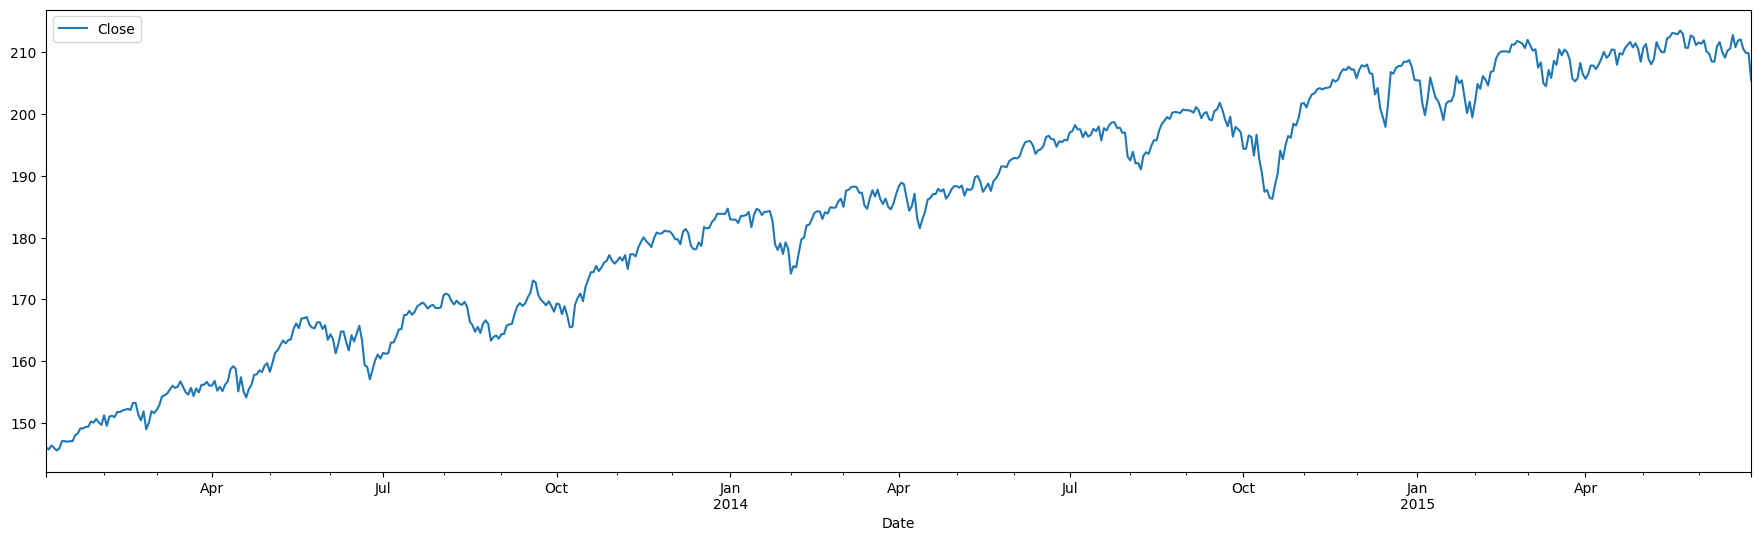

In [45]:
SPY[['Close']].plot(figsize = (22,6));

**Making a series stationary**  
If data is not stationary, ‘differencing’ can make it stationary.  Differencing is subtracting the prior observation from the current one.  

$Difference_t = Observation_t - Observation_{t-1}$  

If the differenced time series is not stationary either, we can continue differencing till we get to a stationary time series.  

The number of times we have to difference a time series to get to stationarity is the ‘order’ of differencing.  This reflects the $d$ parameter in ARIMA.  

We can difference a series using Pandas `series.diff()` function, however there are libraries available that will automatically use an appropriate value for the parameter `d`.


### Dickey Fuller Test for Stationarity  
We can run the Dickey Fuller test for stationarity - If p-value > 0.05, we decide that the dataset is not stationary.  Let us run this test against our stock price time series.  

When we run this test in Python, we get a cryptic output in the form of a tuple.  The help text for this function shows the complete explanation for how to interpret the results:

```
Returns
-------
adf : float
    The test statistic.
pvalue : float
    MacKinnon's approximate p-value based on MacKinnon (1994, 2010).
usedlag : int
    The number of lags used.
nobs : int
    The number of observations used for the ADF regression and calculation
    of the critical values.
critical values : dict
    Critical values for the test statistic at the 1 %, 5 %, and 10 %
    levels. Based on MacKinnon (2010).
icbest : float
    The maximized information criterion if autolag is not None.
resstore : ResultStore, optional
    A dummy class with results attached as attributes.
```

For us, the second value is the p-value that we are interested in.  If this is > 0.05, we decide the series is not stationary.  

In [46]:
# Test the stock price data

from statsmodels.tsa.stattools import adfuller
adfuller(SPY['Close'])

(-1.6928673813673563,
 0.4347911128784576,
 0,
 648,
 {'1%': -3.4404817800778034,
  '5%': -2.866010569916275,
  '10%': -2.569150763698369},
 2126.1002309138994)

In [47]:
# Test the stock returns data  

adfuller(SPY['Returns'].dropna())

(-26.546757517762995,
 0.0,
 0,
 647,
 {'1%': -3.4404975024933813,
  '5%': -2.8660174956716795,
  '10%': -2.569154453750397},
 -4424.286299515888)

***
## Auto-Correlation and Partial Auto-Correlation (ACF and PACF plots)  

Autocorrelation in a time series is the correlation of an observation to the observations that precede it.  Autocorrelation is the basis for being able to use auto regression to forecast a time series.  

To calculate autocorrelation for a series, we shift the series by one step, and calculate the correlation between the two.  We keep increasing the number of steps to see correlations with past periods.  

Fortunately, libraries exist that allow us to do these tedious calculations and present a tidy graph.  

Next, we will look at Autocorrelation plots for both our stock price series, and also the total number of bicycle crossings in Seattle.  


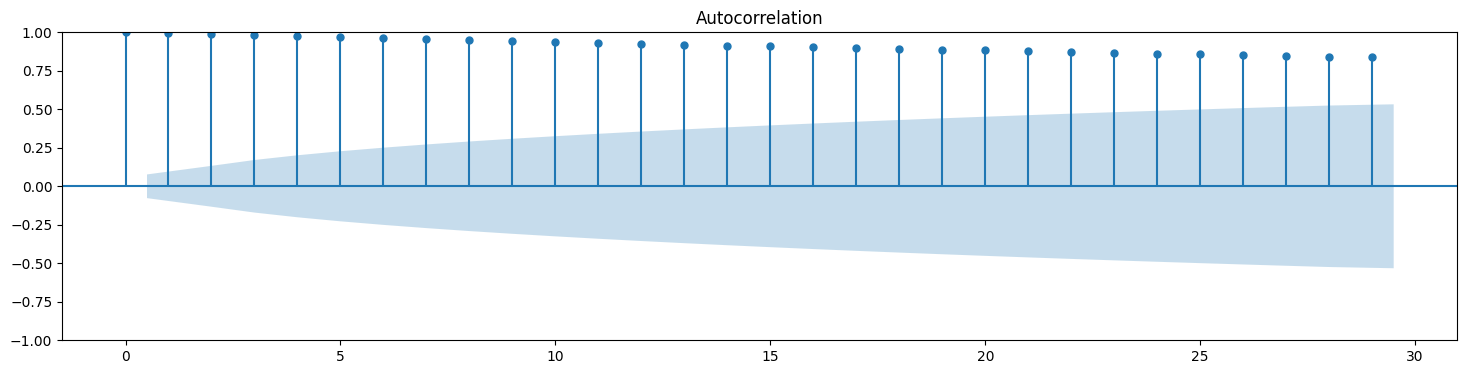

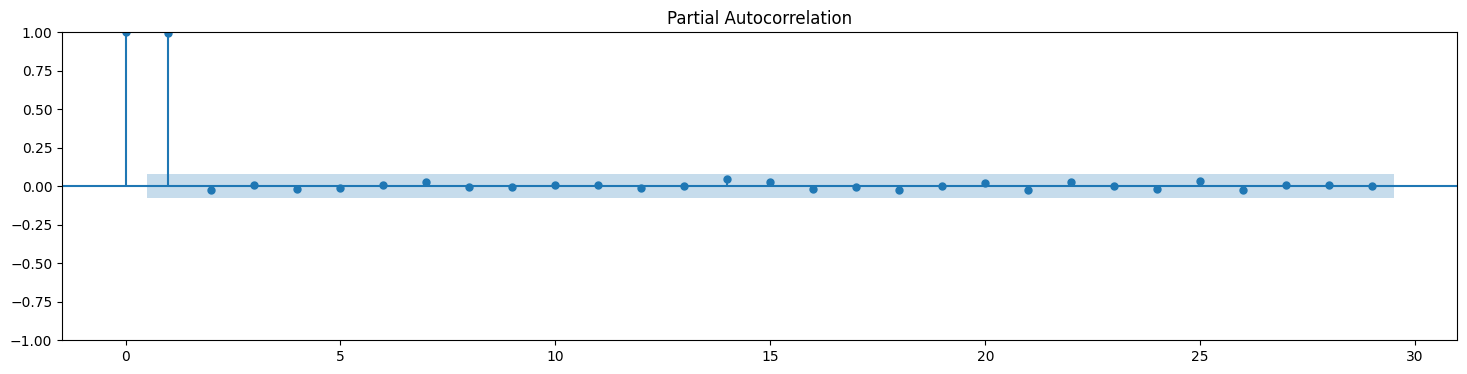

In [48]:
# Autocorrelation and partial autocorrelation plots for stock prices  

plt.rc("figure", figsize=(18,4))
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(SPY['Close']);
plot_pacf(SPY['Close']);

The shaded area represents the 95% confidence level.

PACF for ARIMA:
 - The PACF plot can be used to identify the value of p, the AR order.
 - The ACF plot can be used to identify the value of q, the MA order.
 - The interpretation of ACF and PACF plots to determine values of p & q for ARIMA can be complex.


Below, we see the ACF and PACF plots for the bicycle crossings.  Their seasonality is quite visible.  

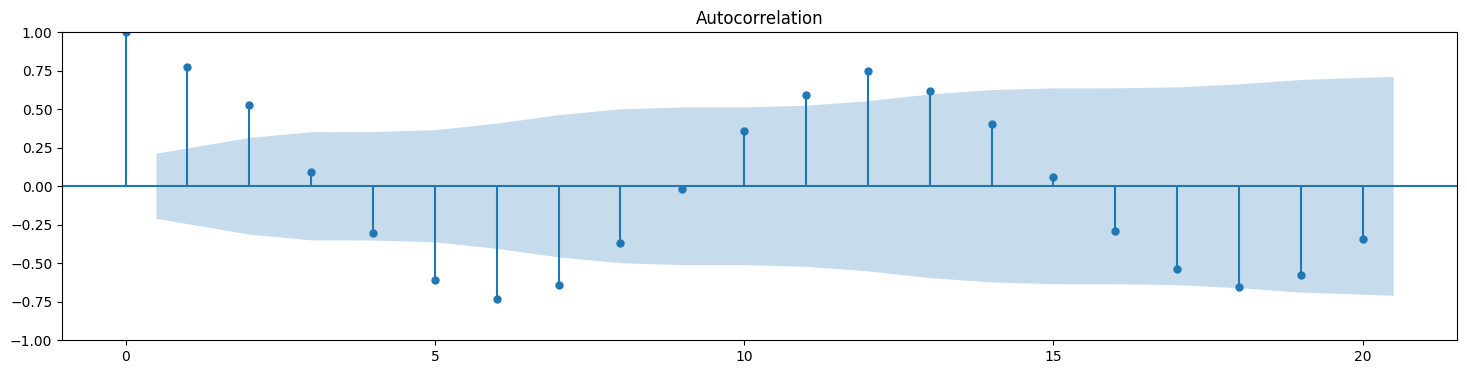

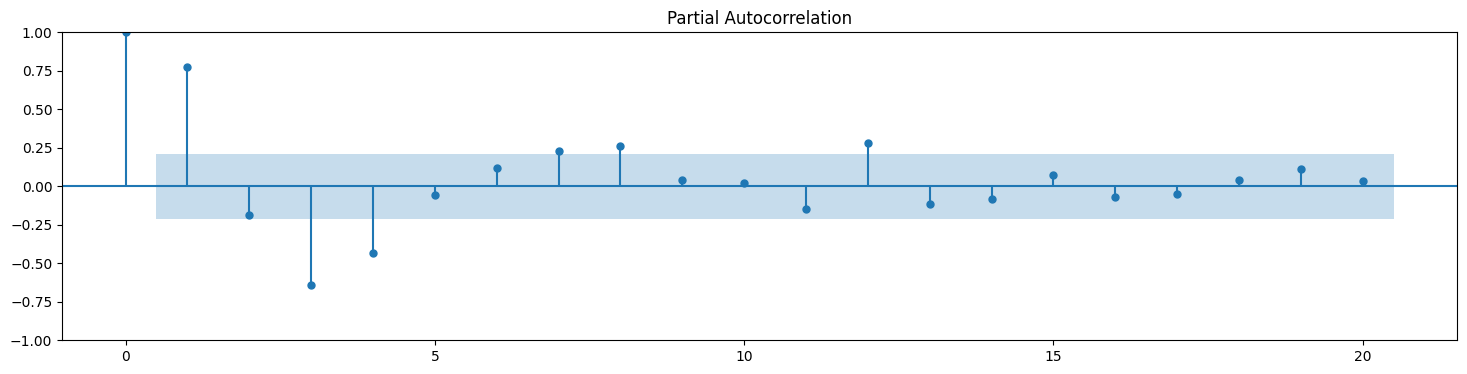

In [49]:
# Autocorrelation and partial autocorrelation plots for stock prices  

plot_acf(new_df.Total);
plot_pacf(new_df.Total);

In [50]:
# Get raw values for auto-correlations

from statsmodels.tsa.stattools import acf
acf(new_df.Total)

array([ 1.        ,  0.77571582,  0.52756191,  0.09556274, -0.30509232,
       -0.60545323, -0.73226582, -0.64087121, -0.37044611, -0.01811217,
        0.35763185,  0.59437737,  0.7515538 ,  0.61992343,  0.40344956,
        0.06119329, -0.28745883, -0.53888819, -0.65309667, -0.57442506])

In [51]:
# Slightly nicer output making it easy to read lag and correlation
[(n,x ) for n, x in enumerate(acf(new_df.Total))]

[(0, 1.0),
 (1, 0.7757158156417427),
 (2, 0.5275619080263295),
 (3, 0.09556274009387859),
 (4, -0.30509232288765453),
 (5, -0.6054532313442101),
 (6, -0.732265815426328),
 (7, -0.6408712113652556),
 (8, -0.3704461111442763),
 (9, -0.018112170681472205),
 (10, 0.35763184544832965),
 (11, 0.5943773727598759),
 (12, 0.7515538007556243),
 (13, 0.6199234263452077),
 (14, 0.4034495609681654),
 (15, 0.061193291548871764),
 (16, -0.28745882651811744),
 (17, -0.5388881889155354),
 (18, -0.6530966725971313),
 (19, -0.5744250570228712)]

***
## Granger Causality Tests

The Granger Causality tests are used to check if two time series are related with each other, specifically, given two time series, whether the time series in the second column can be used to predict the time series in the first column.  

The ‘maxlag’ parameter needs to be specified and the code will identify the p-values at different lag points up to the maxlag value.  If p-value<0.05 for any lag, that may be a valid predictor (or causal factor).  

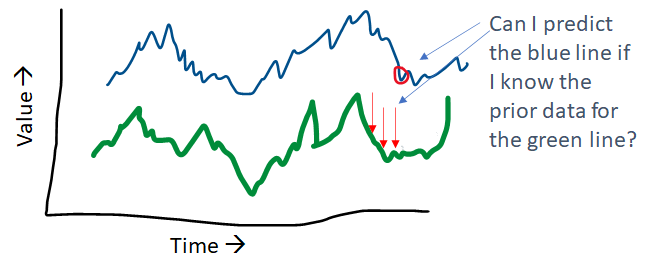

**Example**  
This test is quite easy for us to run using statsmodels.  As an example, we apply it to two separate time series, one showing the average daily temperature, and the other showing the average daily household power consumption.  This data was adapted from a Kaggle dataset to create this illustration.  

In [52]:
from statsmodels.tsa.stattools import grangercausalitytests

In [53]:
# Data adapted from: 
# https://www.kaggle.com/srinuti/residential-power-usage-3years-data-timeseries

df_elec = pd.read_csv('pwr_usage.csv')
df_elec.index = pd.DatetimeIndex(df_elec.Date, freq='W-SUN')
df_elec.drop(['Date'], axis = 1, inplace = True)
df_elec

Temp_avg      kwh
Date                          
2017-01-08  75.542857  106.549
2017-01-15  71.014286  129.096
2017-01-22  64.414286   68.770
2017-01-29  56.728571   71.378
2017-02-05  66.128571  107.829
...               ...      ...
2019-12-08  74.371429  167.481
2019-12-15  61.242857   86.248
2019-12-22  50.000000   73.206
2019-12-29  60.128571   35.655
2020-01-05   7.185714    4.947

[157 rows x 2 columns]

In [54]:
# Check if Average Temperature can be used to predict kwh

grangercausalitytests(df_elec[["kwh", "Temp_avg"]], maxlag = 6);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1022  , p=0.7496  , df_denom=153, df_num=1
ssr based chi2 test:   chi2=0.1042  , p=0.7468  , df=1
likelihood ratio test: chi2=0.1042  , p=0.7469  , df=1
parameter F test:         F=0.1022  , p=0.7496  , df_denom=153, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9543  , p=0.3874  , df_denom=150, df_num=2
ssr based chi2 test:   chi2=1.9722  , p=0.3730  , df=2
likelihood ratio test: chi2=1.9597  , p=0.3754  , df=2
parameter F test:         F=0.9543  , p=0.3874  , df_denom=150, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6013  , p=0.1916  , df_denom=147, df_num=3
ssr based chi2 test:   chi2=5.0327  , p=0.1694  , df=3
likelihood ratio test: chi2=4.9523  , p=0.1753  , df=3
parameter F test:         F=1.6013  , p=0.1916  , df_denom=147, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5901  , p=0.1801  

In [55]:
# Check if kwh can be used to predict Average Temperature 
# While we get p<0.05 at lag 3, the result is obviously absurd
grangercausalitytests(df_elec[["Temp_avg", "kwh"]], maxlag = 6);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1953  , p=0.0758  , df_denom=153, df_num=1
ssr based chi2 test:   chi2=3.2580  , p=0.0711  , df=1
likelihood ratio test: chi2=3.2244  , p=0.0725  , df=1
parameter F test:         F=3.1953  , p=0.0758  , df_denom=153, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8694  , p=0.0599  , df_denom=150, df_num=2
ssr based chi2 test:   chi2=5.9301  , p=0.0516  , df=2
likelihood ratio test: chi2=5.8194  , p=0.0545  , df=2
parameter F test:         F=2.8694  , p=0.0599  , df_denom=150, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0044  , p=0.0324  , df_denom=147, df_num=3
ssr based chi2 test:   chi2=9.4423  , p=0.0240  , df=3
likelihood ratio test: chi2=9.1642  , p=0.0272  , df=3
parameter F test:         F=3.0044  , p=0.0324  , df_denom=147, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3019  , p=0.2722  

  
  
In short, we don't find any causality above, though our intuition would have told us that something should exist.  Perhaps there are variables other than temperature that impact power consumption that we have not thought of.  

That is the power of data - commonly held conceptions can be challenged.  

***
## Forecasting with Simple Exponential Smoothing, Holt and Holt-Winters Method

**(a) Simple Exponential Smoothing**  
In simple exponential smoothing, we reduce the time series to a single variable.  

Simple exponential smoothing is suitable for forecasting data that has no clear trend or seasonal component.  Obviously, this sort of data will have no pattern, so how do we forecast it?  Consider two extreme approaches:  
 - Every future value will be equal to the average of all prior values,  
 - Every future value is the same as the last one.  
 
The difference between the two extreme situations above is that in the first one, we weigh all past observations as equally important, and in the second, we give all the weight to the last observation and none to the ones prior to that.  

The Simple Exponential Smoothing method takes an approach in between - it gives the most weight to the last observation, and gradually reduces the weight as we go further back in the past.  It does so using a single parameter called alpha.  

$\hat{y}_{T+1|T} = \alpha y_T + \alpha(1-\alpha) y_{T-1} + \alpha(1-\alpha)^2 y_{T-2}+ \cdots$

(Source: https://otexts.com/fpp2/ses.html)

**(b) Holt's Method - Double Exponential Smoothing**  
Holt extended simple exponential smoothing described above to account for a trend.  This is captured in a parameter called $\beta$.  

This method involves calculating a ‘level’, with the smoothing parameter α, as well as the trend using a smoothing parameter β.  These parameters are used in a way similar to what we saw with EWMA.  

Because we are using two parameters, it is called ‘double exponential smoothing’.  

$ \begin{align*}
  \text{Forecast equation}&& \hat{y}_{t+h|t} &= \ell_{t} + hb_{t} \\
  \text{Level equation}   && \ell_{t} &= \alpha y_{t} + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  \text{Trend equation}   && b_{t}    &= \beta^*(\ell_{t} - \ell_{t-1}) + (1 -\beta^*)b_{t-1},
\end{align*}$

We can specify additive or multiplicative trends.  Additive trends are preferred when the level of change over time is constant.  Multiplicative trends make sense when the trend varies proportional to the current values of the series.

**(c) Holt-Winters' Method - Triple Exponential Smoothing**  
The Holt-Winters’ seasonal method accounts for the level, as well as the trend and seasonality, with corresponding smoothing parameters α, β and γ respectively. 
 - Level: α  
 - Trend: β  
 - Seasonality: γ  

We also specify the frequency of the seasonality, i.e., the number of periods that comprise a season. For example, for quarterly data the frequency would be 4 , and for monthly data, it would be 12.  

Like for trend, we can specify whether the seasonality is additive or multiplicative.  

The equations for Triple Exponential Smoothing look as follows:  
$\begin{align*}
  \hat{y}_{t+h|t} &= \ell_{t} + hb_{t} + s_{t+h-m(k+1)} \\
  \ell_{t} &= \alpha(y_{t} - s_{t-m}) + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  b_{t} &= \beta^*(\ell_{t} - \ell_{t-1}) + (1 - \beta^*)b_{t-1}\\
  s_{t} &= \gamma (y_{t}-\ell_{t-1}-b_{t-1}) + (1-\gamma)s_{t-m},
\end{align*}$
  
We will not cover these equations in detail as the code does everything for us.  As practitioners, we need to think about the problems we can solve with this, and while being aware of the underlying logic.  The code will calculate the values of $\alpha$, $\beta$ and $\gamma$ and use these in the equations above to make predictions.  


In [56]:
# Let us look at the index of our data frame that has the bicycle crossing data

new_df.index

DatetimeIndex(['2012-10-31', '2012-11-30', '2012-12-31', '2013-01-31',
               '2013-02-28', '2013-03-31', '2013-04-30', '2013-05-31',
               '2013-06-30', '2013-07-31', '2013-08-31', '2013-09-30',
               '2013-10-31', '2013-11-30', '2013-12-31', '2014-01-31',
               '2014-02-28', '2014-03-31', '2014-04-30', '2014-05-31',
               '2014-06-30', '2014-07-31', '2014-08-31', '2014-09-30',
               '2014-10-31', '2014-11-30', '2014-12-31', '2015-01-31',
               '2015-02-28', '2015-03-31', '2015-04-30', '2015-05-31',
               '2015-06-30', '2015-07-31', '2015-08-31', '2015-09-30',
               '2015-10-31', '2015-11-30', '2015-12-31', '2016-01-31',
               '2016-02-29', '2016-03-31', '2016-04-30', '2016-05-31',
               '2016-06-30', '2016-07-31', '2016-08-31', '2016-09-30',
               '2016-10-31', '2016-11-30', '2016-12-31', '2017-01-31',
               '2017-02-28', '2017-03-31', '2017-04-30', '2017-05-31',
      

In [57]:
# Clean up the data frame, set index frequency explicitly to Monthly
# This is needed as Holt-Winters will not work otherwise

new_df.index.freq = 'M'

In [58]:
# Let us drop an NaN entries, just in case

new_df.dropna(inplace=True)

In [59]:
new_df

Total  Moving_Avg_6m  Moving_Avg_12m         EWMA12
Date                                                              
2013-09-30   80729.0   97184.000000    74734.583333   82750.448591
2013-10-31   81352.0   98743.000000    76039.333333   82535.302654
2013-11-30   59270.0   90525.666667    76757.916667   78956.025322
2013-12-31   43553.0   81237.833333    77356.583333   73509.406042
2014-01-31   59873.0   71554.333333    78605.666667   71411.497420
...              ...            ...             ...            ...
2019-07-31  137714.0  101472.833333    91343.750000  100389.020732
2019-08-31  142414.0  119192.000000    93894.166667  106854.402158
2019-09-30  112174.0  123644.833333    95221.833333  107672.801826
2019-10-31  104498.0  126405.833333    96348.166667  107184.370776
2019-11-30   84963.0  119045.833333    97725.833333  103765.698349

[75 rows x 4 columns]

In [60]:
# Set warnings to ignore so we don't get the ugly orange boxes

import warnings
warnings.filterwarnings('ignore')

In [61]:
# Some library imports 

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error as mse

### Simple Exponential Smoothing (same as EWMA)

In [62]:
# Train-test split
train_samples = int(new_df.shape[0] * 0.8)

train_set = new_df.iloc[:train_samples]
test_set = new_df.iloc[train_samples:]

print("Training set: ", train_set.shape[0])
print("Test set: ", test_set.shape[0])

Training set:  60
Test set:  15


In [63]:
# Fit model using Simple Exponential Smoothing
model = SimpleExpSmoothing(train_set['Total']).fit()

In [64]:
predictions = model.forecast(15)

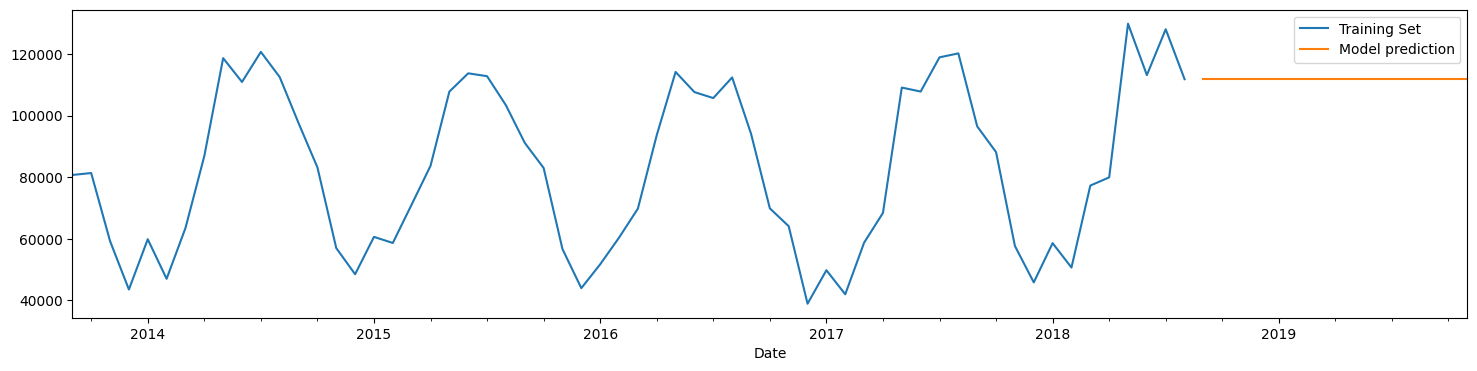

In [65]:
# let us plot the predictions and the training values
train_set['Total'].plot(legend=True,label='Training Set')
predictions.plot(legend=True,label='Model prediction');

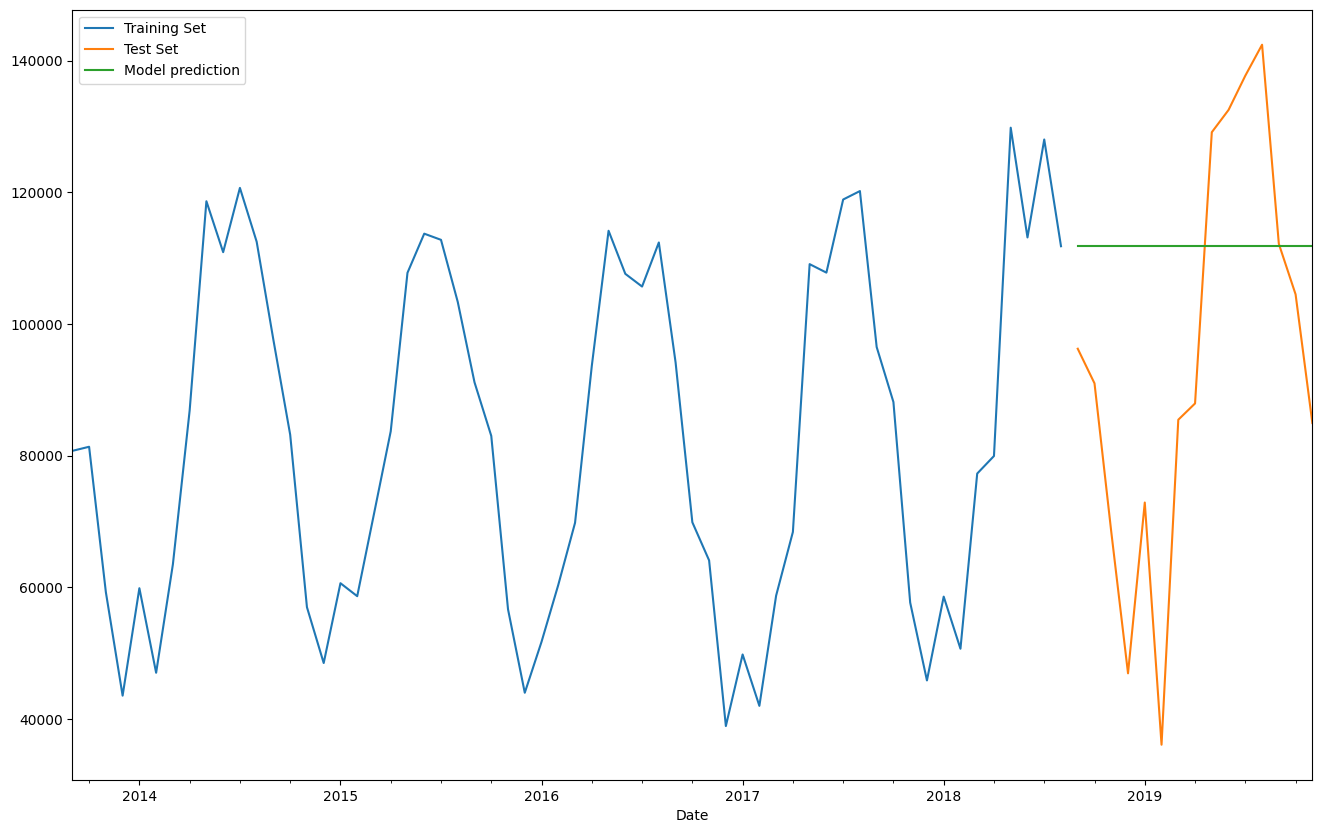

In [66]:
# Now we plot test (observed) values as well
train_set['Total'].plot(legend=True,label='Training Set')
test_set['Total'].plot(legend=True,label='Test Set',figsize=(16,10))
predictions.plot(legend=True,label='Model prediction');

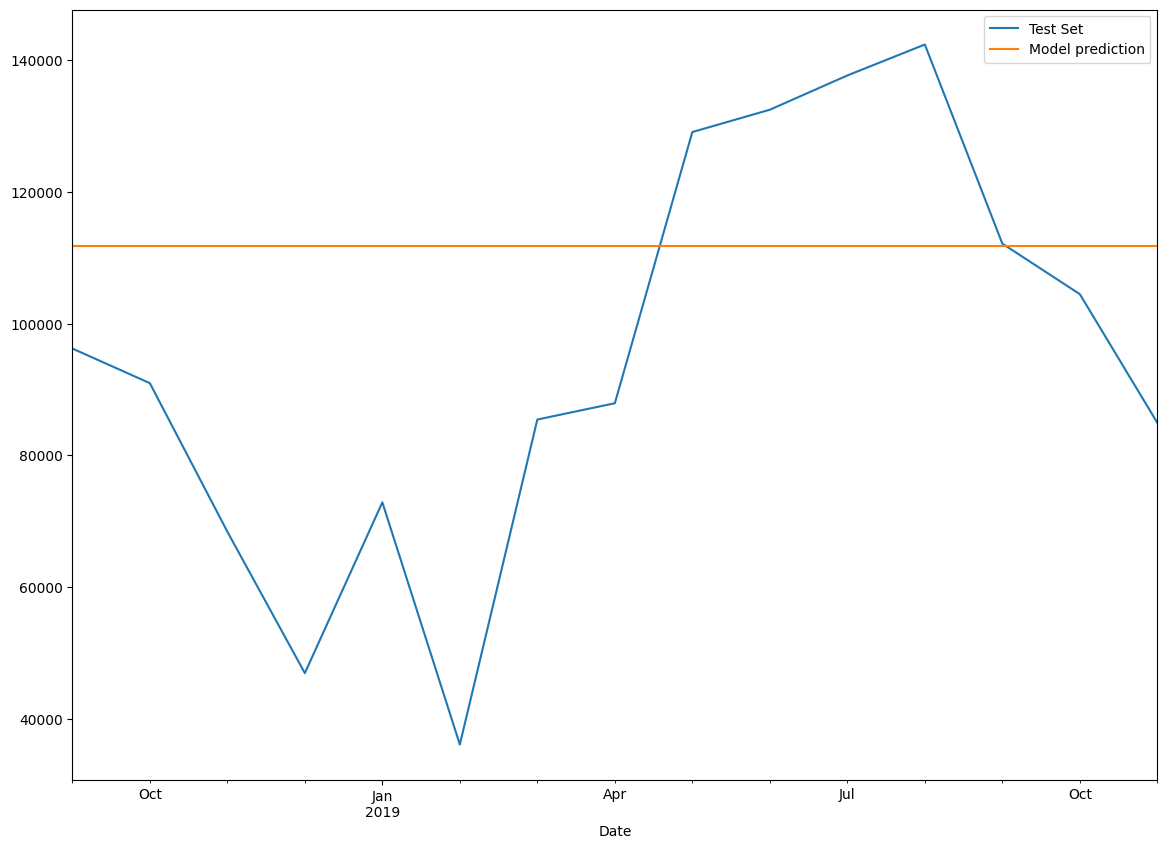

In [67]:
# Now we plot test (observed) values as well
# train_set['Total'].plot(legend=True,label='Training Set')
test_set['Total'].plot(legend=True,label='Test Set',figsize=(14,10))
predictions.plot(legend=True,label='Model prediction');

In [68]:
model.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 80729.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [69]:
# Calculate Evaluation Metrics
y_test = test_set['Total']
y_pred = predictions
pd.DataFrame({'y_test': y_test, 'y_pred' : y_pred, 'diff':y_test - y_pred})

y_test         y_pred          diff
2018-09-30   96242.0  111889.675227 -15647.675227
2018-10-31   90982.0  111889.675227 -20907.675227
2018-11-30   68431.0  111889.675227 -43458.675227
2018-12-31   46941.0  111889.675227 -64948.675227
2019-01-31   72883.0  111889.675227 -39006.675227
2019-02-28   36099.0  111889.675227 -75790.675227
2019-03-31   85457.0  111889.675227 -26432.675227
2019-04-30   87932.0  111889.675227 -23957.675227
2019-05-31  129123.0  111889.675227  17233.324773
2019-06-30  132512.0  111889.675227  20622.324773
2019-07-31  137714.0  111889.675227  25824.324773
2019-08-31  142414.0  111889.675227  30524.324773
2019-09-30  112174.0  111889.675227    284.324773
2019-10-31  104498.0  111889.675227  -7391.675227
2019-11-30   84963.0  111889.675227 -26926.675227

In [70]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('MSE = ', mean_squared_error(y_test,y_pred))
print('RMSE = ', np.sqrt(mean_squared_error(y_test,y_pred)))
print('MAE = ', mean_absolute_error(y_test,y_pred))

MSE =  1228535508.79919
RMSE =  35050.47087842316
MAE =  29263.82507577501


### Double Exponential Smoothing

In [71]:
# Train-test split
train_samples = int(new_df.shape[0] * 0.8)

train_set = new_df.iloc[:train_samples]
test_set = new_df.iloc[train_samples:]

print("Training set: ", train_set.shape[0])
print("Test set: ", test_set.shape[0])

Training set:  60
Test set:  15


In [72]:
# Fit model using Simple Exponential Smoothing
# model = SimpleExpSmoothing(train_set['Total']).fit()

In [73]:
# Double Exponential Smoothing
model = ExponentialSmoothing(train_set['Total'], trend='mul').fit()

In [74]:
predictions = model.forecast(15)

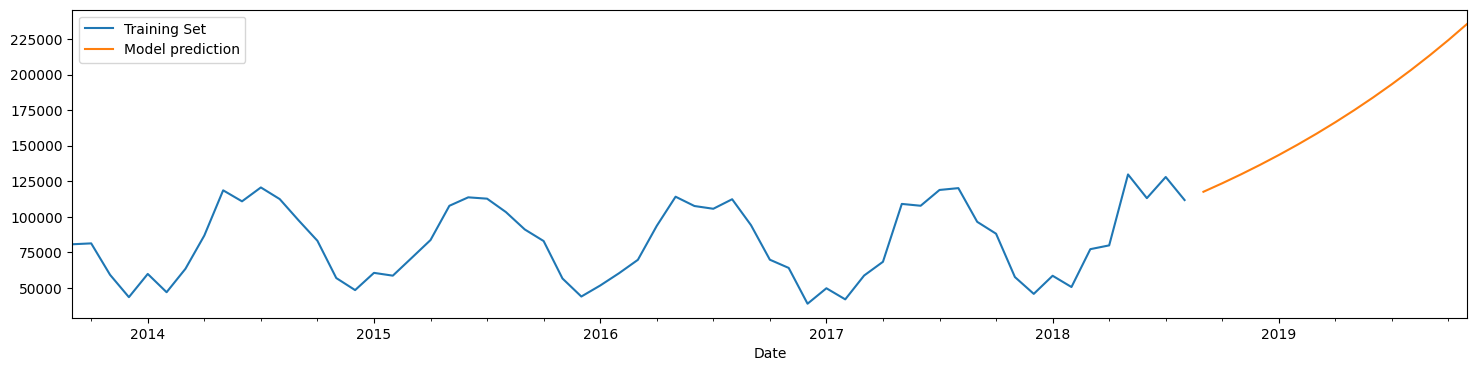

In [75]:
# let us plot the predictions and the training values
train_set['Total'].plot(legend=True,label='Training Set')
predictions.plot(legend=True,label='Model prediction');

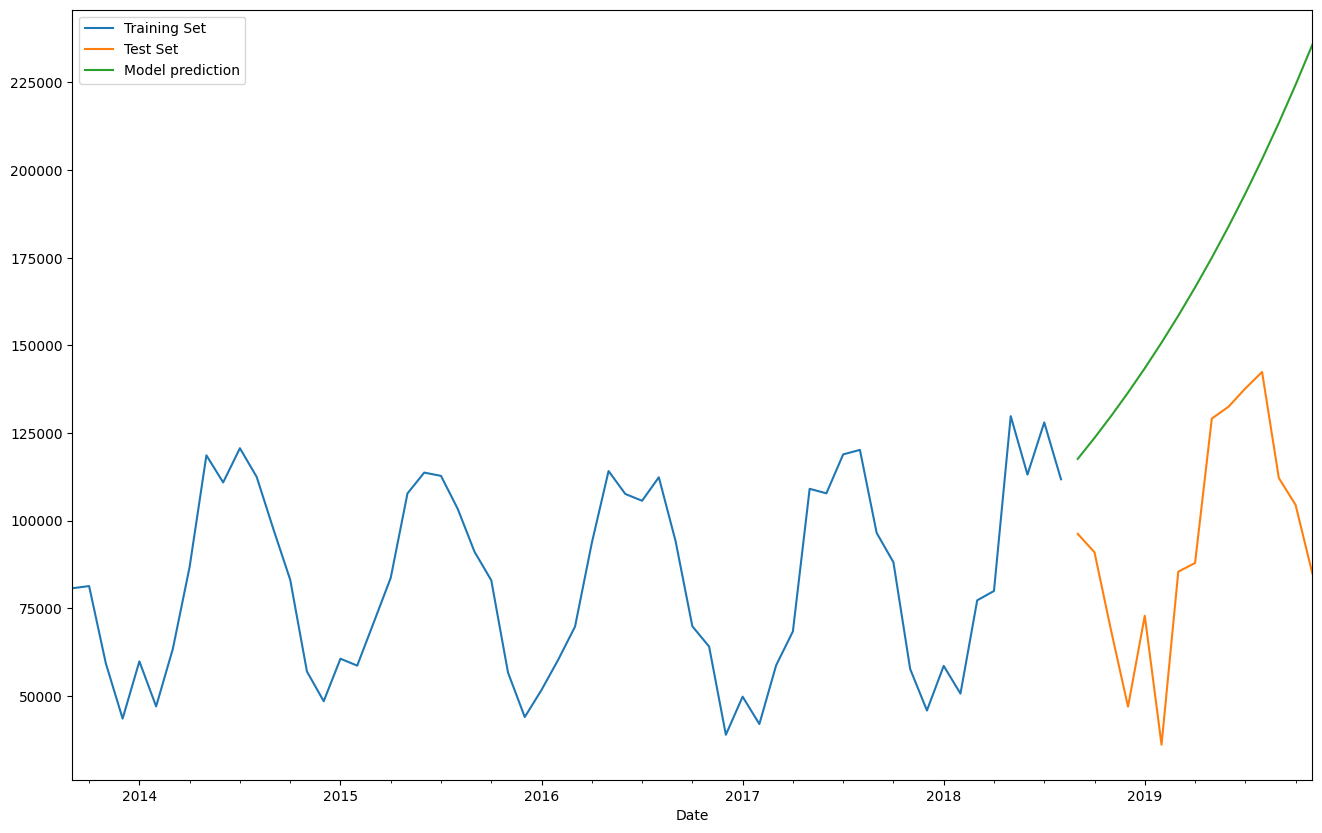

In [76]:
# Now we plot test (observed) values as well
train_set['Total'].plot(legend=True,label='Training Set')
test_set['Total'].plot(legend=True,label='Test Set',figsize=(16,10))
predictions.plot(legend=True,label='Model prediction');

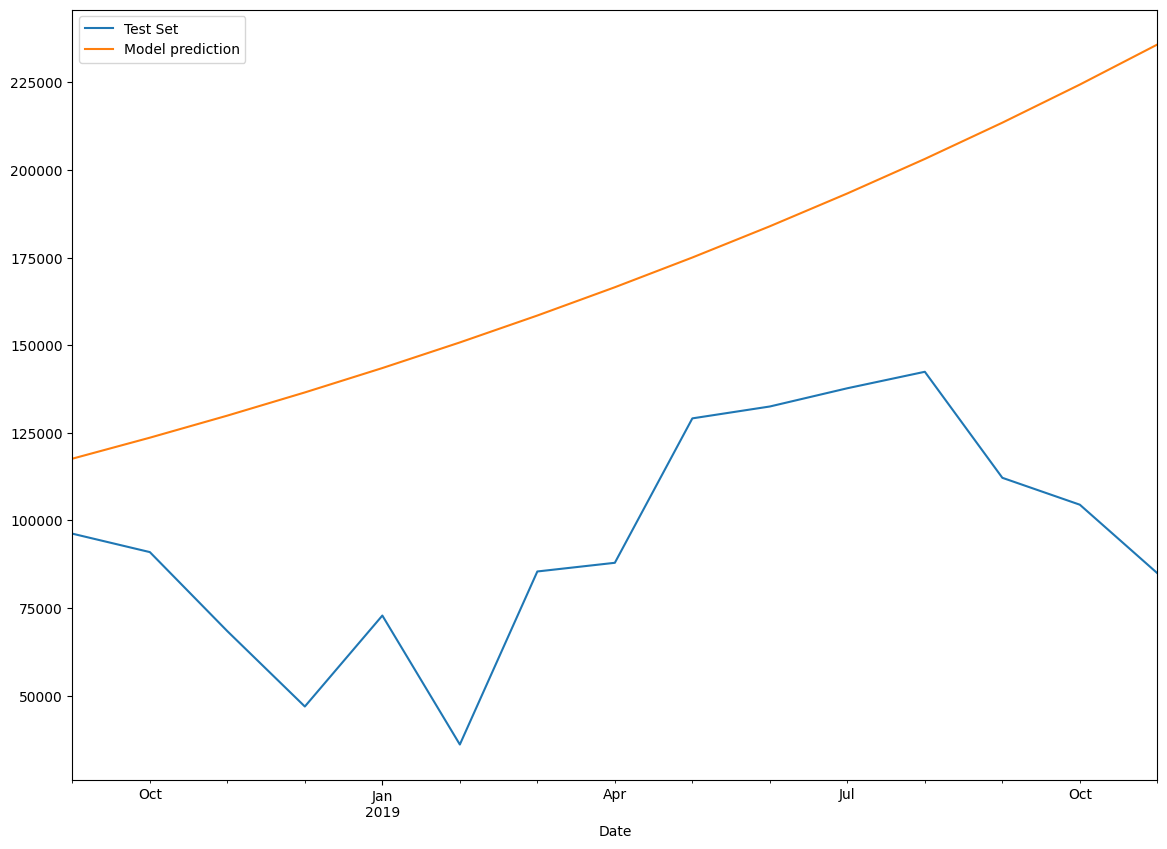

In [77]:
# Now we plot test (observed) values as well
# train_set['Total'].plot(legend=True,label='Training Set')
test_set['Total'].plot(legend=True,label='Test Set',figsize=(14,10))
predictions.plot(legend=True,label='Model prediction');

In [78]:
model.params

{'smoothing_level': 0.995,
 'smoothing_trend': 0.04738095238095238,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 51251.999999999985,
 'initial_trend': 1.084850613368525,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [79]:
# Calculate Evaluation Metrics
y_test = test_set['Total']
y_pred = predictions
pd.DataFrame({'y_test': y_test, 'y_pred' : y_pred, 'diff':y_test - y_pred})

y_test         y_pred           diff
2018-09-30   96242.0  117626.951449  -21384.951449
2018-10-31   90982.0  123616.042220  -32634.042220
2018-11-30   68431.0  129910.073380  -61479.073380
2018-12-31   46941.0  136524.571266  -89583.571266
2019-01-31   72883.0  143475.852752  -70592.852752
2019-02-28   36099.0  150781.065503 -114682.065503
2019-03-31   85457.0  158458.230275  -73001.230275
2019-04-30   87932.0  166526.285367  -78594.285367
2019-05-31  129123.0  175005.133341  -45882.133341
2019-06-30  132512.0  183915.690115  -51403.690115
2019-07-31  137714.0  193279.936564  -55565.936564
2019-08-31  142414.0  203120.972739  -60706.972739
2019-09-30  112174.0  213463.074854 -101289.074854
2019-10-31  104498.0  224331.755168 -119833.755168
2019-11-30   84963.0  235753.824924 -150790.824924

In [80]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('MSE = ', mean_squared_error(y_test,y_pred))
print('RMSE = ', np.sqrt(mean_squared_error(y_test,y_pred)))
print('MAE = ', mean_absolute_error(y_test,y_pred))

MSE =  6789777046.197141
RMSE =  82400.10343559734
MAE =  75161.63066121914


### Triple Exponential Smoothing

In [81]:
# Train-test split
train_samples = int(new_df.shape[0] * 0.8)

train_set = new_df.iloc[:train_samples]
test_set = new_df.iloc[train_samples:]

print("Training set: ", train_set.shape[0])
print("Test set: ", test_set.shape[0])

Training set:  60
Test set:  15


In [82]:
# Let us use the triple exponential smoothing model
model = ExponentialSmoothing(train_set['Total'],trend='add', \
                             seasonal='add',seasonal_periods=12).fit()

In [83]:
predictions = model.forecast(15)

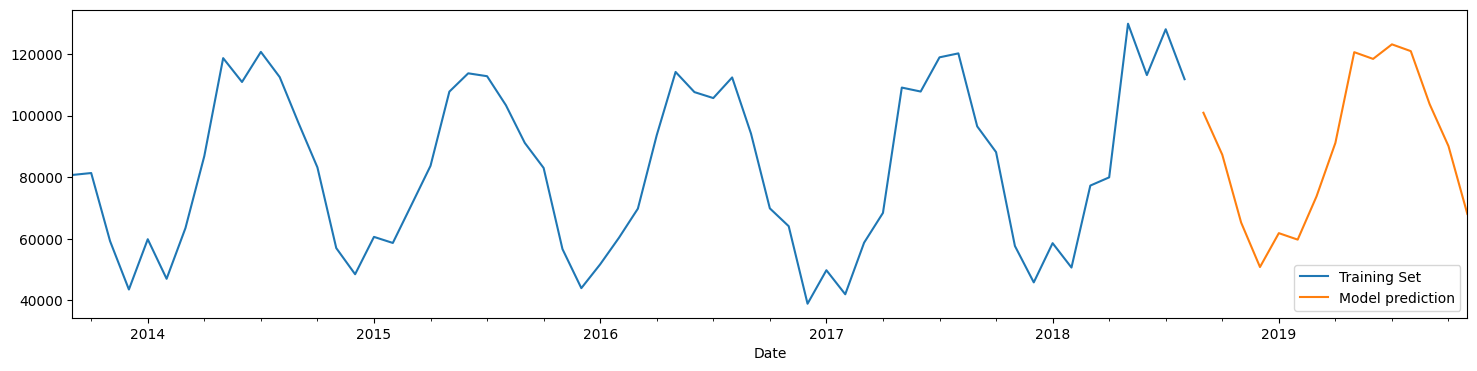

In [84]:
# let us plot the predictions and the training values
train_set['Total'].plot(legend=True,label='Training Set')
predictions.plot(legend=True,label='Model prediction');

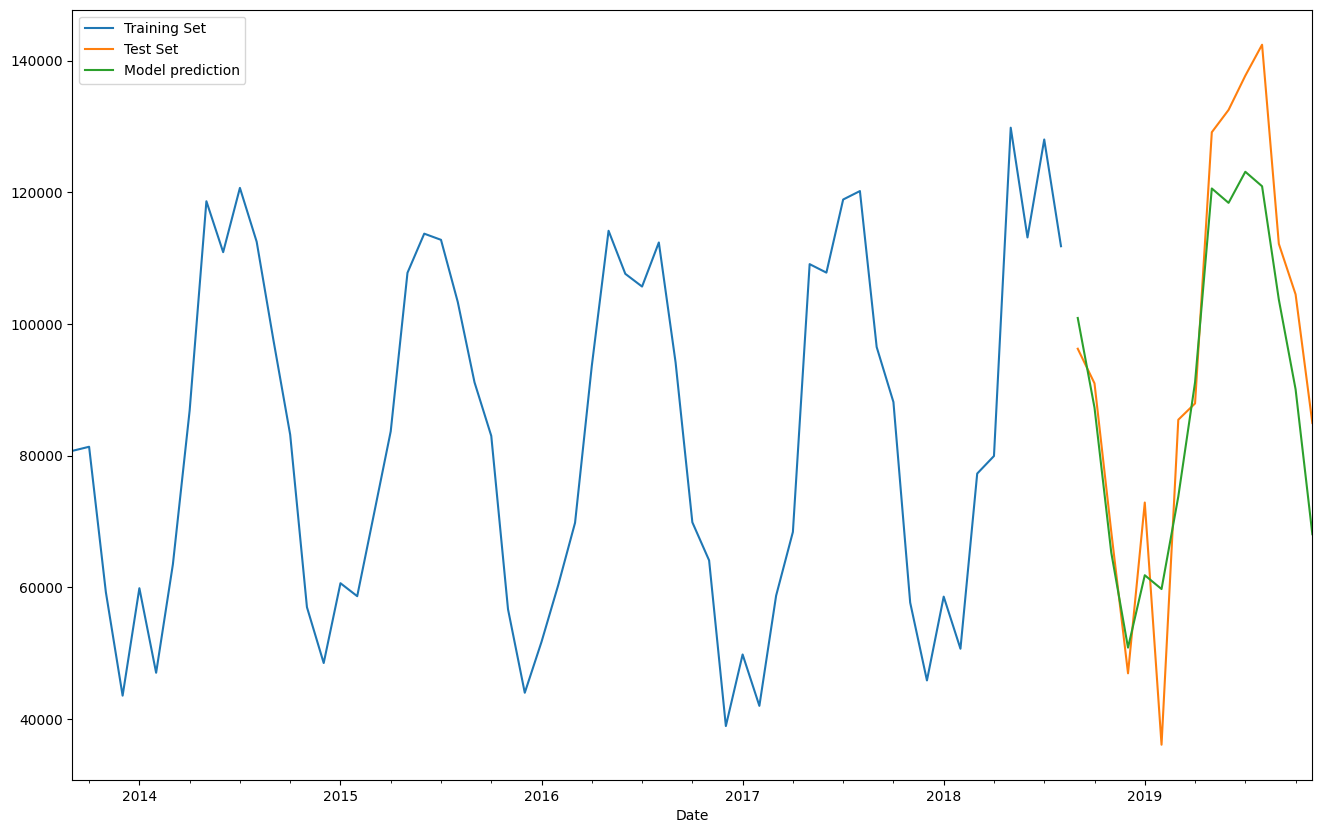

In [85]:
# Now we plot test (observed) values as well
train_set['Total'].plot(legend=True,label='Training Set')
test_set['Total'].plot(legend=True,label='Test Set',figsize=(16,10))
predictions.plot(legend=True,label='Model prediction');

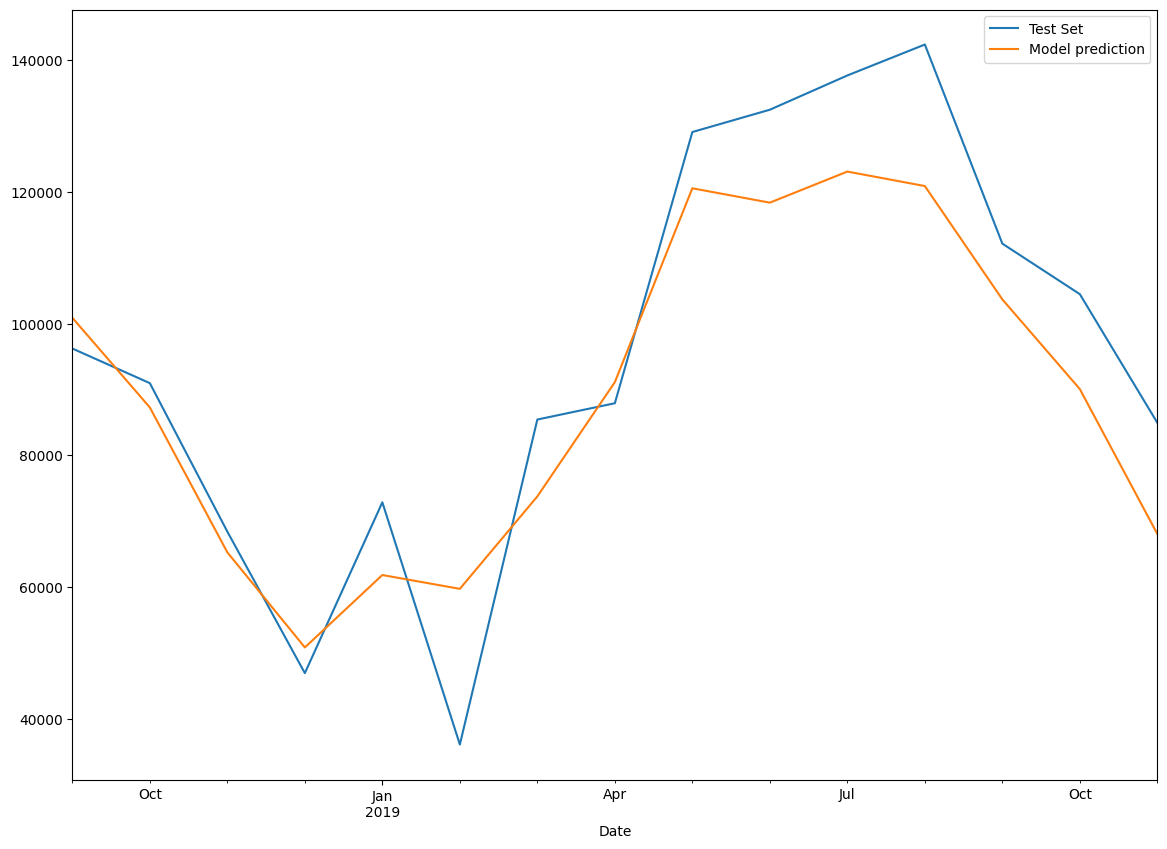

In [86]:
# Test vs observed - closeup of the predictions
# train_set['Total'].plot(legend=True,label='Training Set')
test_set['Total'].plot(legend=True,label='Test Set',figsize=(14,10))
predictions.plot(legend=True,label='Model prediction');

In [87]:
model.params

{'smoothing_level': 0.2525,
 'smoothing_trend': 0.0001,
 'smoothing_seasonal': 0.0001,
 'damping_trend': nan,
 'initial_level': 82880.52777777775,
 'initial_trend': 233.32297979798386,
 'initial_seasons': array([ 12706.58333333,  -1150.10416667, -23387.98958333, -38062.89583333,
        -27297.51041667, -29627.21875   , -15820.59375   ,   1298.15625   ,
         30509.6875    ,  28095.90625   ,  32583.70833333,  30152.27083333]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [88]:
# Calculate Evaluation Metrics
y_test = test_set['Total']
y_pred = predictions
pd.DataFrame({'y_test': y_test, 'y_pred' : y_pred, 'diff':y_test - y_pred})

y_test         y_pred          diff
2018-09-30   96242.0  100914.043265  -4672.043265
2018-10-31   90982.0   87291.600234   3690.399766
2018-11-30   68431.0   65286.060329   3144.939671
2018-12-31   46941.0   50843.440823  -3902.440823
2019-01-31   72883.0   61841.794519  11041.205481
2019-02-28   36099.0   59743.301291 -23644.301291
2019-03-31   85457.0   73783.743291  11673.256709
2019-04-30   87932.0   91133.340351  -3201.340351
2019-05-31  129123.0  120579.559129   8543.440871
2019-06-30  132512.0  118396.387406  14115.612594
2019-07-31  137714.0  123117.725595  14596.274405
2019-08-31  142414.0  120917.981585  21496.018415
2019-09-30  112174.0  103703.284649   8470.715351
2019-10-31  104498.0   90080.841618  14417.158382
2019-11-30   84963.0   68075.301713  16887.698287

In [89]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('MSE = ', mean_squared_error(y_test,y_pred))
print('RMSE = ', np.sqrt(mean_squared_error(y_test,y_pred)))
print('MAE = ', mean_absolute_error(y_test,y_pred))

MSE =  160014279.71049073
RMSE =  12649.675083198412
MAE =  10899.78971069559


In [90]:
model = ExponentialSmoothing(new_df['Total'], trend='mul').fit()

In [91]:
# Fit values
pd.DataFrame({'fitted':model.fittedvalues.shift(-1), 'actual':new_df['Total']})

fitted    actual
Date                               
2013-09-30   88374.142596   80729.0
2013-10-31   89066.318586   81352.0
2013-11-30   64512.628727   59270.0
2013-12-31   47037.321040   43553.0
2014-01-31   64853.079989   59873.0
...                   ...       ...
2019-07-31  147204.031288  137714.0
2019-08-31  152114.454701  142414.0
2019-09-30  119265.035267  112174.0
2019-10-31  110660.795745  104498.0
2019-11-30            NaN   84963.0

[75 rows x 2 columns]

In [92]:
# Examine model parameters
model.params

{'smoothing_level': 0.995,
 'smoothing_trend': 0.02369047619047619,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 51251.999999999985,
 'initial_trend': 1.084850613368525,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [93]:
# RMSE calculation
x = pd.DataFrame({'fitted':model.fittedvalues.shift(-1), 'actual':new_df['Total']}).dropna()
rmse = np.sqrt(mse(x.fitted, x.actual))
rmse

6017.795365317929

In [94]:
# predict the next 15 values
predictions = model.forecast(15)
predictions

2019-12-31     89553.250900
2020-01-31     94248.964768
2020-02-29     99190.897823
2020-03-31    104391.960540
2020-04-30    109865.740351
2020-05-31    115626.537143
2020-06-30    121689.400618
2020-07-31    128070.169604
2020-08-31    134785.513440
2020-09-30    141852.975517
2020-10-31    149291.019112
2020-11-30    157119.075623
2020-12-31    165357.595328
2021-01-31    174028.100817
2021-02-28    183153.243211
Freq: M, dtype: float64

In [95]:
model.fittedvalues

Date
2013-09-30     55600.763636
2013-10-31     88374.142596
2013-11-30     89066.318586
2013-12-31     64512.628727
2014-01-31     47037.321040
                  ...      
2019-07-31    141747.388757
2019-08-31    147204.031288
2019-09-30    152114.454701
2019-10-31    119265.035267
2019-11-30    110660.795745
Freq: M, Length: 75, dtype: float64

## ARIMA - Auto Regressive Integrated Moving Average  

ARIMA stands for Auto Regressive Integrated Moving Average.  It is a general method for understanding and predicting time series data.  

ARIMA models come in several different flavors, for example:
 - Non-seasonal ARIMA  
 - Seasonal ARIMA (Called SARIMA)  
 - SARIMA with external variables, called SARIMAX  
Which one should we use? ARIMA or Holt-Winters?  
 > Try both.  Whatever works better for your use case is the one to use.

ARIMA models have three non-negative integer parameters – _p_, _d_ and _q_.
 - _p_ represents the Auto-Regression component, AR.  This is the part of the model that leverages the linear regression between an observation and past observations.  
 - _d_ represents differencing, the I component.  This is the number of times the series has to be differenced to make it stationary.  
 - _q_ represents the MA component, the number of lagged forecast errors in the prediction.  This considers the relationship between an observation and the residual error from a moving average model.  

A correct choice of the ‘order’ of your ARIMA model, ie deciding the values of _p_, _d_ and _q_, is essential to building a good ARIMA model.  

**Deciding the values of _p_, _d_ and _q_**  
 - Values of _p_ and _q_ can be determined manually by examining auto-correlation and partial-autocorrelation plots.  
 - The value of _d_ can be determined by repeatedly differencing a series till we get to a stationary series.  

The manual methods are time consuming, and less precise.  An overview of these is provided in the Appendix to this slide deck.  

In reality, we let the computer do a grid search (a brute force test of a set of permutations for _p_, _d_ and _q_) to determine the order of our ARIMA model.  The Pyramid ARIMA library in Python allows searching through multiple combinations of _p_, _d_ and _q_ to identify the best model.  
  
**ARIMA in Action**  
1. Split dataset into train and test.  
2. Test set should be the last _**n**_ entries.  Can’t use random selection for train-test split.  
3. Pyramid ARIMA is a Python package that can identify the values of p, d and q to use.  Use Auto ARIMA from Pyramid ARIMA to find good values of p, d and q based on the training data set.  
4. Fit a model on the training data set.  
5. Predict the test set, and evaluate using MSE, MAE or RMSE.  





In [96]:
# Library imports

from pmdarima import auto_arima

In [97]:
# Train-test split

train_samples = int(new_df.shape[0] * 0.8)

train_set = new_df.iloc[:train_samples]
test_set = new_df.iloc[train_samples:]

print("Training set: ", train_set.shape[0])
print("Test set: ", test_set.shape[0])

Training set:  60
Test set:  15


In [98]:
# Clean up

train_set.dropna(inplace=True)

### Use Auto ARIMA to find out order

In [99]:
# Build a model using auto_arima

model = auto_arima(train_set['Total'],seasonal=False)

In [100]:
order = model.get_params()['order']
seasonal_order = model.get_params()['seasonal_order']
print('Order = ', order)
print('Seasonal Order = ', seasonal_order)

Order =  (5, 0, 1)
Seasonal Order =  (0, 0, 0, 0)


In [101]:
# Create and fit model

from statsmodels.tsa.arima.model import ARIMA

model_ARIMA = ARIMA(train_set['Total'], order = order)
model_ARIMA = model_ARIMA.fit()

In [102]:
# Predict with ARIMA 

start=len(train_set)
end=len(train_set)+len(test_set)-1
ARIMApredictions = model_ARIMA.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA Predictions')
# model_ARIMA.summary()

In [103]:
# Calculate Evaluation Metrics
y_test = test_set['Total']
y_pred = ARIMApredictions
pd.DataFrame({'y_test': y_test, 'y_pred' : y_pred, 'diff':y_test - y_pred})

y_test         y_pred          diff
2018-09-30   96242.0   97178.782841   -936.782841
2018-10-31   90982.0   68163.166776  22818.833224
2018-11-30   68431.0   56095.942557  12335.057443
2018-12-31   46941.0   41005.329654   5935.670346
2019-01-31   72883.0   42591.251732  30291.748268
2019-02-28   36099.0   51555.855575 -15456.855575
2019-03-31   85457.0   71734.836673  13722.163327
2019-04-30   87932.0   91198.670052  -3266.670052
2019-05-31  129123.0  110818.433668  18304.566332
2019-06-30  132512.0  121161.132303  11350.867697
2019-07-31  137714.0  122198.078813  15515.921187
2019-08-31  142414.0  111847.671126  30566.328874
2019-09-30  112174.0   94763.626480  17410.373520
2019-10-31  104498.0   73934.456312  30563.543688
2019-11-30   84963.0   56060.536900  28902.463100

In [104]:
# Calculate evaluation metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error
print('MSE = ', mean_squared_error(y_test,y_pred))
print('RMSE = ', np.sqrt(mean_squared_error(y_test,y_pred)))
print('MAE = ', mean_absolute_error(y_test,y_pred))

MSE =  385065542.1818603
RMSE =  19623.086968717747
MAE =  17158.523031611756


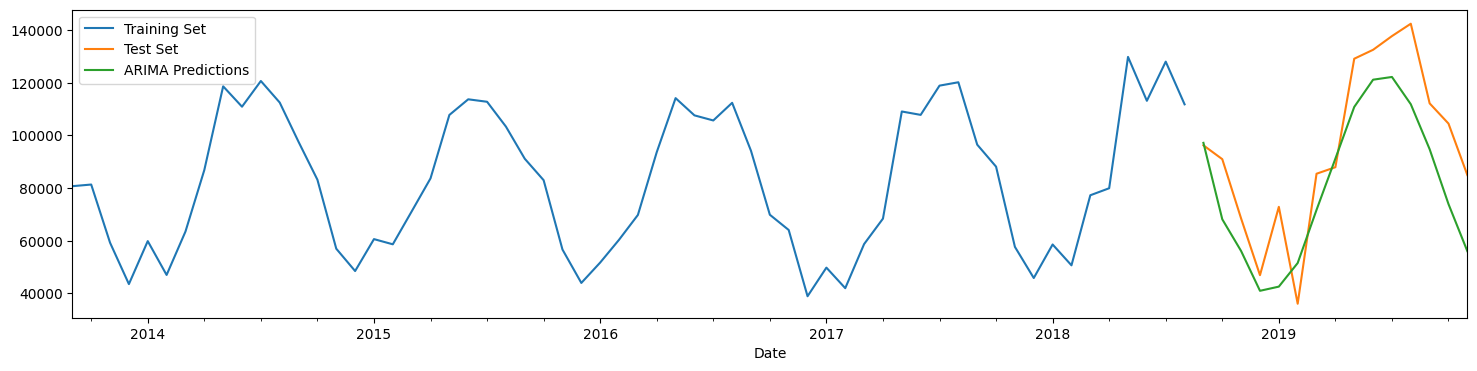

In [105]:
# Plot results
train_set['Total'].rename('Training Set').plot(legend=True)
test_set['Total'].rename('Test Set').plot(legend=True)
ARIMApredictions.plot(legend=True)
plt.show()

***
## Seasonal ARIMA - SARIMA  
SARIMA, or Seasonal ARIMA, accounts for seasonality.  In order to account for seasonality, we need three more parameters – _P_, _D_ and _Q_ – to take care of seasonal variations.  

Auto ARIMA takes care of seasonality as well, and provides us the values for _P_, _D_ and _Q_ just like it does for _p_, _d_ and _q_.  

To use SARIMA, we now need 7 parameters for our function:  
 - _p_  
 - _d_  
 - _q_  
   - _P_  
   - _D_  
   - _Q_  
 - _m_ (frequency of our seasons, eg, 12)  
 
**SARIMA in Action**  
1. Split dataset into train and test.  
2. Test set should be the last n entries.  Can’t use random selection for train-test split.  
3. Pyramid ARIMA is a Python package that can identify the values of p, d, q, P, D and Q to use.  Use Auto ARIMA from Pyramid ARIMA to find good values of p, d and q based on the training data set.  
4. Fit a model on the training data set.  
5. Predict the test set, and evaluate using MSE, MAE or RMSE.   
 

In [106]:
# Create a model with auto_arima

model = auto_arima(train_set['Total'],seasonal=True,m=12)

In [107]:
# Get values of p, d, q, P, D and Q

order = model.get_params()['order']
seasonal_order = model.get_params()['seasonal_order']

print('Order = ', order)
print('Seasonal Order = ', seasonal_order)

Order =  (1, 0, 0)
Seasonal Order =  (0, 1, 1, 12)


In [108]:
# Create and fit model

from statsmodels.tsa.statespace.sarimax import SARIMAX
model_SARIMA = SARIMAX(train_set['Total'], order=order, seasonal_order=seasonal_order)
model_SARIMA = model_SARIMA.fit()
model_SARIMA.params

ar.L1       2.438118e-01
ma.S.L12   -6.668071e-02
sigma2      7.885998e+07
dtype: float64

In [109]:
# Create SARIMA predictions  

start=len(train_set)
end=len(train_set)+len(test_set)-1
SARIMApredictions = model_SARIMA.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')

In [110]:
# Calculate Evaluation Metrics

y_test = test_set['Total']
y_pred = SARIMApredictions
pd.DataFrame({'y_test': y_test, 'y_pred' : y_pred, 'diff':y_test - y_pred})

y_test         y_pred          diff
2018-09-30   96242.0   94423.659176   1818.340824
2018-10-31   90982.0   86518.880961   4463.119039
2018-11-30   68431.0   57965.336973  10465.663027
2018-12-31   46941.0   45396.267772   1544.732228
2019-01-31   72883.0   58009.524643  14873.475357
2019-02-28   36099.0   50177.757219 -14078.757219
2019-03-31   85457.0   76096.865509   9360.134491
2019-04-30   87932.0   79286.971453   8645.028547
2019-05-31  129123.0  128451.795674    671.204326
2019-06-30  132512.0  112789.442695  19722.557305
2019-07-31  137714.0  127353.588372  10360.411628
2019-08-31  142414.0  112330.356235  30083.643765
2019-09-30  112174.0   94550.771990  17623.228010
2019-10-31  104498.0   86549.872568  17948.127432
2019-11-30   84963.0   57972.893093  26990.106907

In [111]:
# Metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error
print('MSE = ', mean_squared_error(y_test,y_pred))
print('RMSE = ', np.sqrt(mean_squared_error(y_test,y_pred)))
print('MAE = ', mean_absolute_error(y_test,y_pred))

MSE =  231993016.88445473
RMSE =  15231.316978004716
MAE =  12576.56867360885


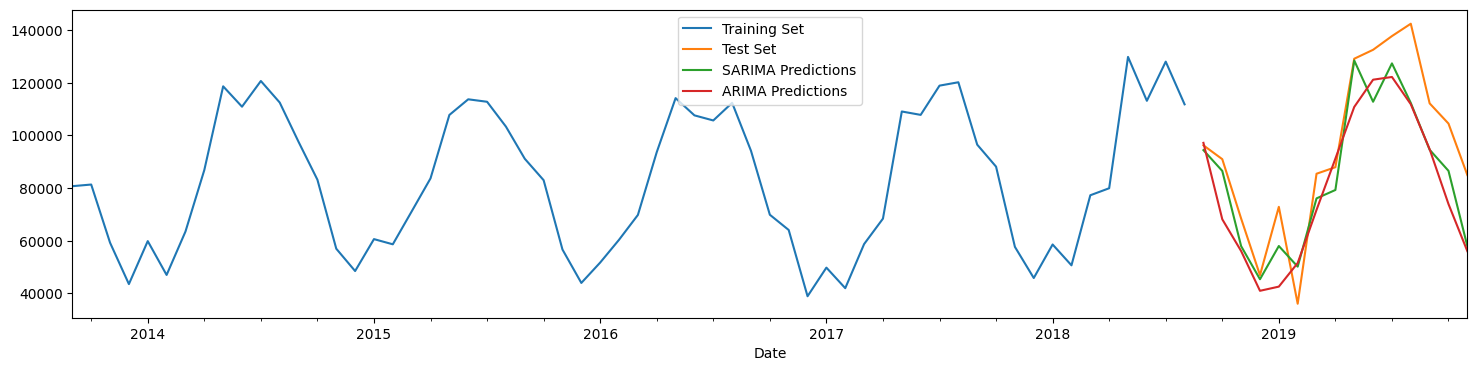

In [112]:
# Plot results

train_set['Total'].rename('Training Set').plot(legend=True)
test_set['Total'].rename('Test Set').plot(legend=True)
SARIMApredictions.plot(legend = True)
ARIMApredictions.plot(legend=True)
plt.show()

In [113]:
# Models compared to each other - calculate MAE, RMSE

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
print('SARIMA:')
print('  RMSE = ' ,mse(SARIMApredictions, test_set['Total'], squared = False))
print('  MAE = ', mae(SARIMApredictions, test_set['Total']))
print('\nARIMA:')
print('  RMSE = ' ,mse(ARIMApredictions, test_set['Total'], squared = False))
print('  MAE = ', mae(ARIMApredictions, test_set['Total']))
print('\n')
print('  Mean of the data = ', new_df.Total.mean())
print('  St Dev of the data = ', new_df.Total.std())

SARIMA:
  RMSE =  15231.316978004716
  MAE =  12576.56867360885

ARIMA:
  RMSE =  19623.086968717747
  MAE =  17158.523031611756


  Mean of the data =  85078.8
  St Dev of the data =  28012.270090473237


## SARIMAX  
SARIMAX = Seasonal ARIMA with eXogenous variable

SARIMAX is the same as SARIMA, but there is an additional predictor variable in addition to just the time series itself.  

Let us load some data showing weekly power consumption as well as average daily temperature.  We will try to predict kwh as a time series, and also use Temp_avg as an exogenous variable.

In order to predict the future, you need the past data series, plus observed values for the exogenous variable.  That can sometimes be difficult because the future may not yet have revealed itself yet, and while you may be able to build a model that evaluates well, you will not be able to use it.  


In [114]:
# Data adapted from: 
# https://www.kaggle.com/srinuti/residential-power-usage-3years-data-timeseries  
# The data shows weekly electricity usage and the average temperature of the week.  
# Our hypothesis is that the power consumed can be predicted using the average 
# temperature, and the pattern found in the time series.

df_elec = pd.read_csv('pwr_usage.csv')
df_elec

Date   Temp_avg      kwh
0      1/8/2017  75.542857  106.549
1     1/15/2017  71.014286  129.096
2     1/22/2017  64.414286   68.770
3     1/29/2017  56.728571   71.378
4      2/5/2017  66.128571  107.829
..          ...        ...      ...
152   12/8/2019  74.371429  167.481
153  12/15/2019  61.242857   86.248
154  12/22/2019  50.000000   73.206
155  12/29/2019  60.128571   35.655
156    1/5/2020   7.185714    4.947

[157 rows x 3 columns]

### Data exploration

In [115]:
df_elec.index = pd.DatetimeIndex(df_elec.Date, freq='W-SUN')
df_elec.drop(['Date'], axis = 1, inplace = True)
df_elec

Temp_avg      kwh
Date                          
2017-01-08  75.542857  106.549
2017-01-15  71.014286  129.096
2017-01-22  64.414286   68.770
2017-01-29  56.728571   71.378
2017-02-05  66.128571  107.829
...               ...      ...
2019-12-08  74.371429  167.481
2019-12-15  61.242857   86.248
2019-12-22  50.000000   73.206
2019-12-29  60.128571   35.655
2020-01-05   7.185714    4.947

[157 rows x 2 columns]

In [116]:
df_elec.index

DatetimeIndex(['2017-01-08', '2017-01-15', '2017-01-22', '2017-01-29',
               '2017-02-05', '2017-02-12', '2017-02-19', '2017-02-26',
               '2017-03-05', '2017-03-12',
               ...
               '2019-11-03', '2019-11-10', '2019-11-17', '2019-11-24',
               '2019-12-01', '2019-12-08', '2019-12-15', '2019-12-22',
               '2019-12-29', '2020-01-05'],
              dtype='datetime64[ns]', name='Date', length=157, freq='W-SUN')

<Axes: xlabel='Date'>

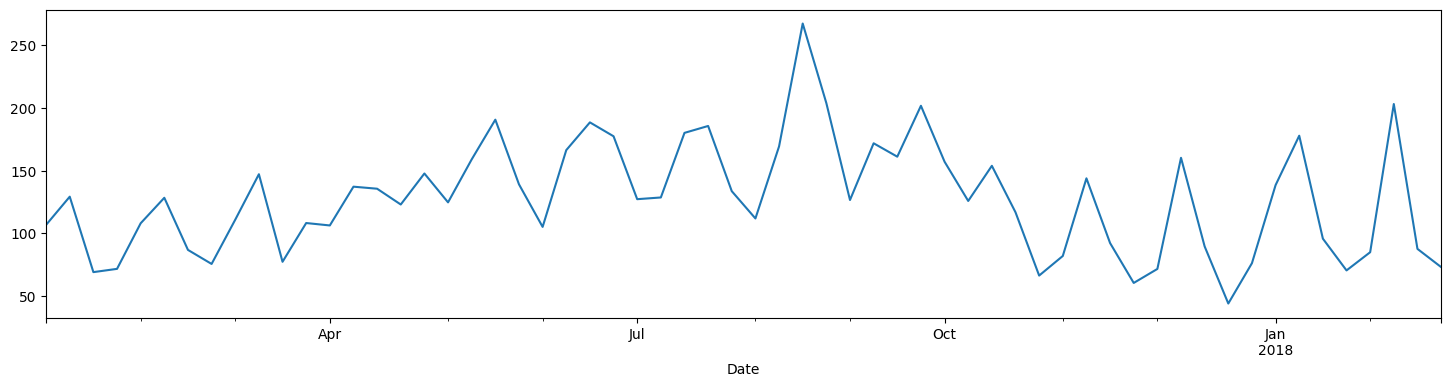

In [117]:
df_elec['kwh'][:60].plot()

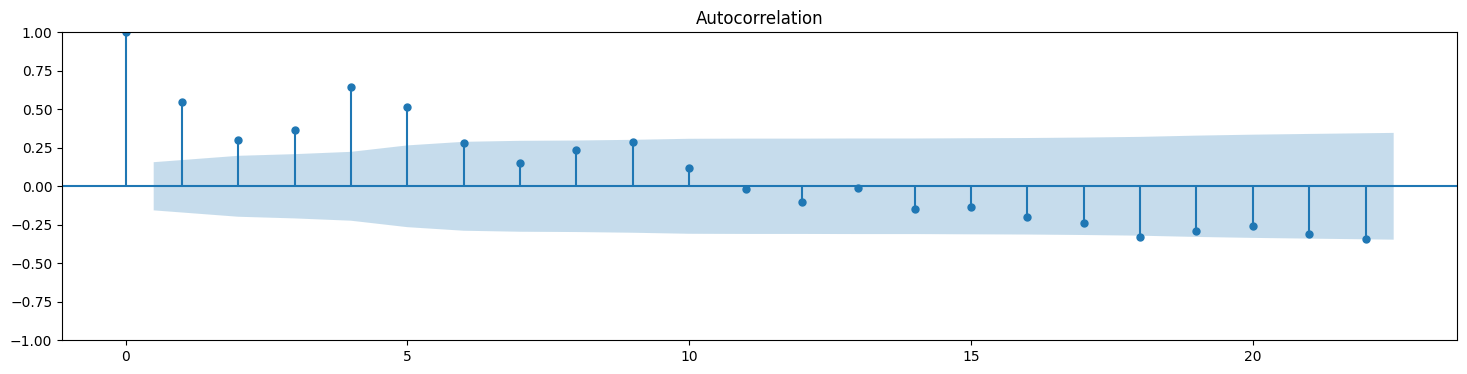

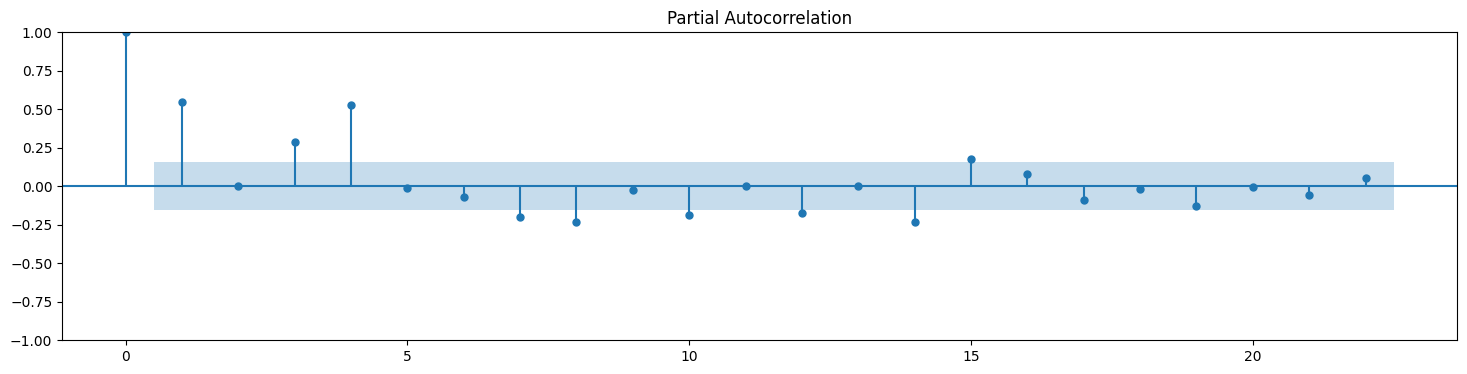

In [118]:
plt.rc("figure", figsize=(18,4))
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df_elec['kwh']);
plot_pacf(df_elec['kwh']);

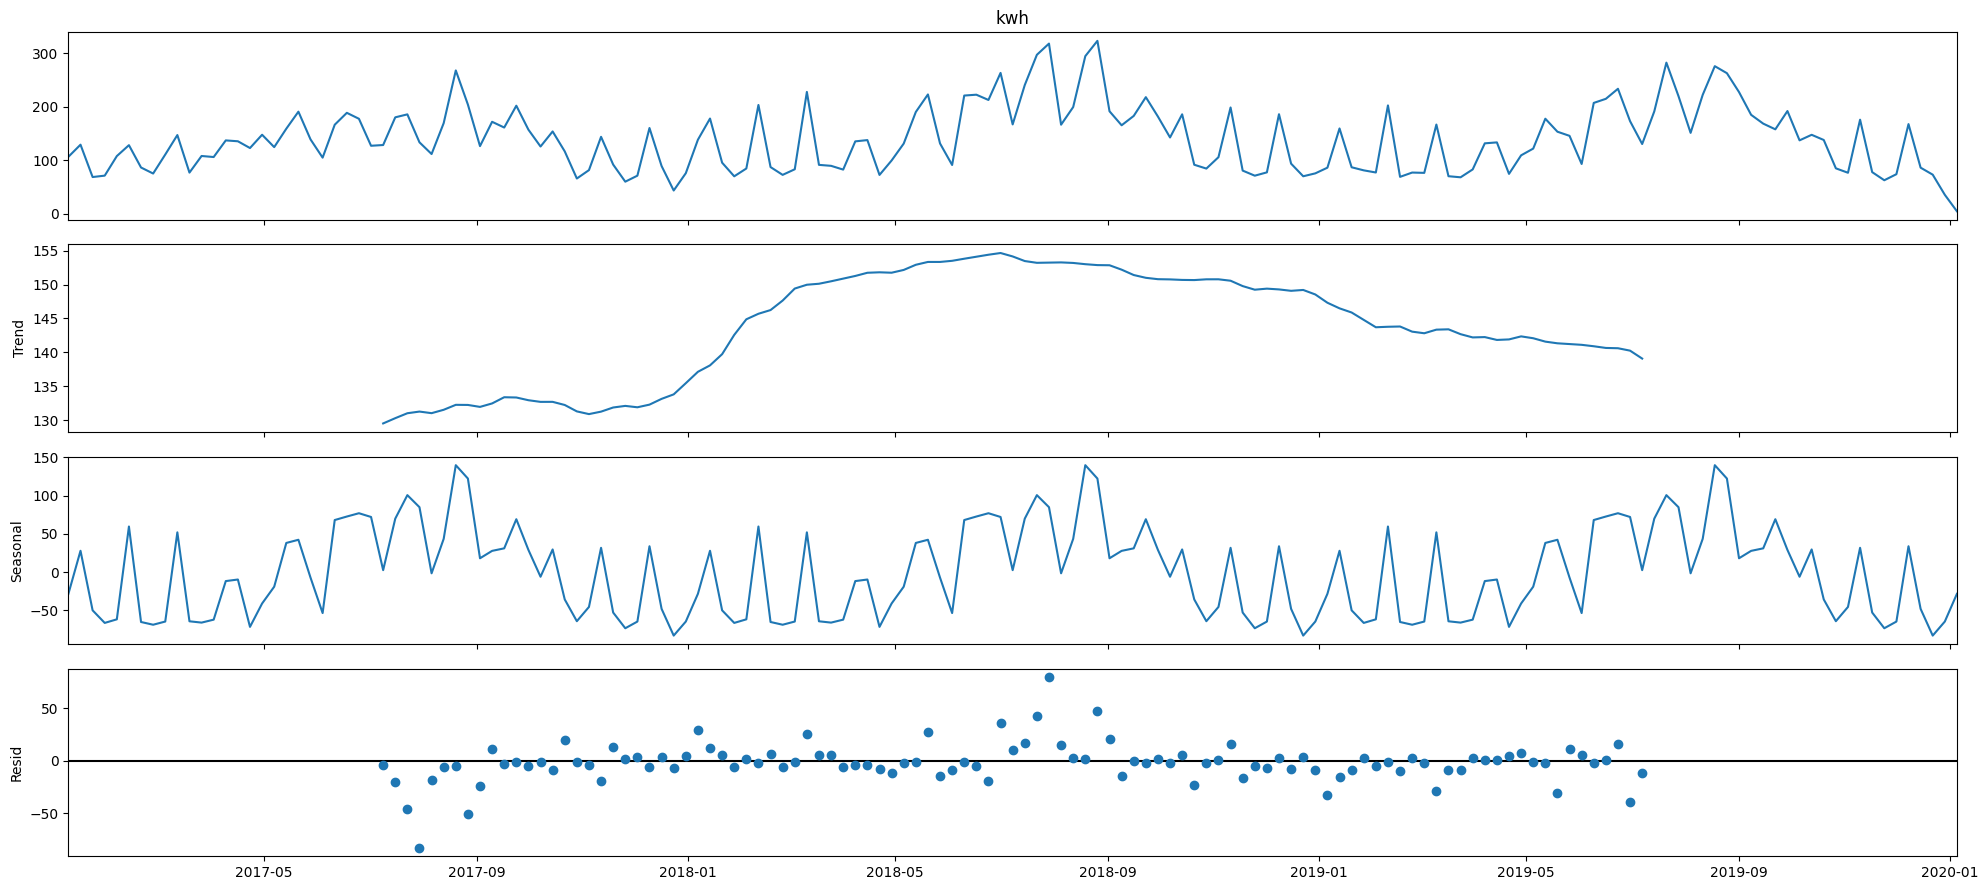

In [119]:
result = seasonal_decompose(df_elec['kwh'], model = 'additive') 
plt.rcParams['figure.figsize'] = (20, 9)
result.plot();

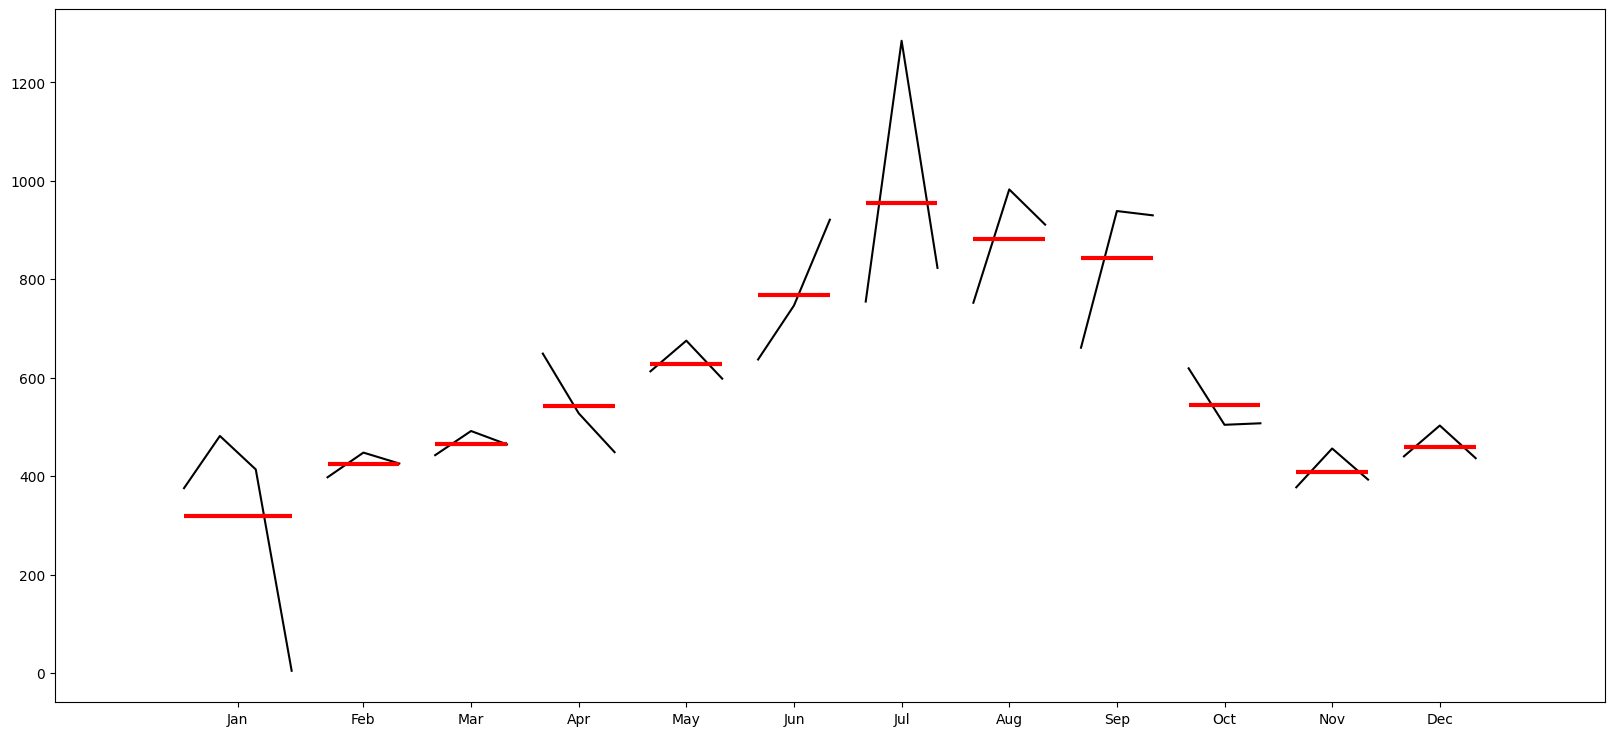

In [120]:
# Plot the months to see trends over months
month_plot(df_elec[['kwh']].resample(rule='M').kwh.sum());

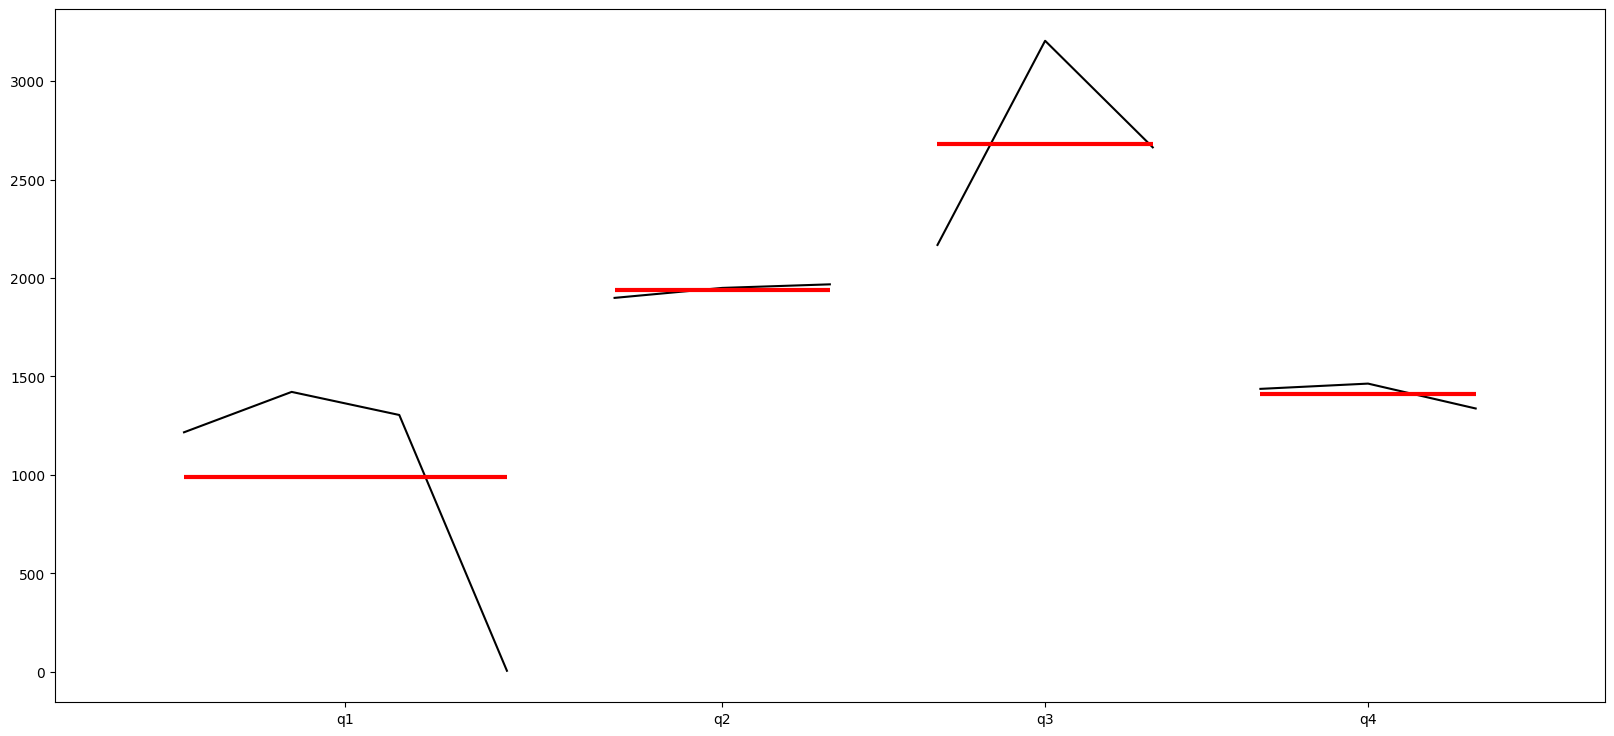

In [121]:
# Plot the quarter to see trends over quarters
quarter_plot(df_elec[['kwh']].resample(rule='Q').kwh.sum());

### Train-test split

In [122]:
# Train-test split
test_samples = 12

train_set = df_elec.iloc[:-test_samples]
test_set = df_elec.iloc[-test_samples:]

print("Training set: ", train_set.shape[0])
print("Test set: ", test_set.shape[0])

Training set:  145
Test set:  12


In [123]:
train_set

Temp_avg       kwh
Date                           
2017-01-08  75.542857  106.5490
2017-01-15  71.014286  129.0960
2017-01-22  64.414286   68.7700
2017-01-29  56.728571   71.3780
2017-02-05  66.128571  107.8290
...               ...       ...
2019-09-15  76.800000  168.3470
2019-09-22  79.385714  157.7260
2019-09-29  80.928571  191.8260
2019-10-06  70.771429  137.1698
2019-10-13  74.285714  147.5200

[145 rows x 2 columns]

In [124]:
test_set

Temp_avg      kwh
Date                          
2019-10-20  73.471429  137.847
2019-10-27  64.557143   84.999
2019-11-03  62.928571   76.744
2019-11-10  77.985714  175.708
2019-11-17  49.042857   77.927
2019-11-24  62.785714   62.805
2019-12-01  69.557143   74.079
2019-12-08  74.371429  167.481
2019-12-15  61.242857   86.248
2019-12-22  50.000000   73.206
2019-12-29  60.128571   35.655
2020-01-05   7.185714    4.947

**Uncomment this cell to run auto-ARIMA (very time consuming)  
Determine parameters for SARIMAX using Auto-ARIMA**  
```Python
model = auto_arima(train_set['kwh'],seasonal=True,m=52)  
order = model.get_params()['order']  
seasonal_order = model.get_params()['seasonal_order']  
  
print('Order = ', order)  
print('Seasonal Order = ', seasonal_order)  
```

In [125]:
# Set the order, ie the values of p, d, q and P, D, Q and m.

order =  (1, 0, 1)
seasonal_order =  (1, 0, 1, 52)

### First, let us try SARIMA, ignoring temperature

In [126]:
# Create and fit model

from statsmodels.tsa.statespace.sarimax import SARIMAX
model_SARIMA = SARIMAX(train_set['kwh'],order=order,seasonal_order=seasonal_order)
model_SARIMA = model_SARIMA.fit()
# model_SARIMA.summary()
model_SARIMA.params

ar.L1         0.983883
ma.L1        -0.703757
ar.S.L52      0.994796
ma.S.L52     -0.842830
sigma2      781.564879
dtype: float64

In [127]:
# Create SARIMA predictions

start=len(train_set)
end=len(train_set)+len(test_set)-1
SARIMApredictions = model_SARIMA.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')

In [128]:
# Calculate Evaluation Metrics

y_test = test_set['kwh']
y_pred = SARIMApredictions
pd.DataFrame({'y_test': y_test, 'y_pred' : y_pred, 'diff':y_test - y_pred})

y_test      y_pred        diff
2019-10-20  137.847  108.432110   29.414890
2019-10-27   84.999   84.006054    0.992946
2019-11-03   76.744   99.242296  -22.498296
2019-11-10  175.708  164.413570   11.294430
2019-11-17   77.927   92.077521  -14.150521
2019-11-24   62.805   74.425502  -11.620502
2019-12-01   74.079   81.382111   -7.303111
2019-12-08  167.481  164.427999    3.053001
2019-12-15   86.248   95.116618   -8.868618
2019-12-22   73.206   65.763267    7.442733
2019-12-29   35.655   81.148805  -45.493805
2020-01-05    4.947  113.466587 -108.519587

In [129]:
# Model evaluation

from sklearn.metrics import mean_absolute_error, mean_squared_error
print('MSE = ', mean_squared_error(y_test,y_pred))
print('RMSE = ', np.sqrt(mean_squared_error(y_test,y_pred)))
print('MAE = ', mean_absolute_error(y_test,y_pred))

MSE =  1323.1768701198491
RMSE =  36.375498211293944
MAE =  22.55437004082181


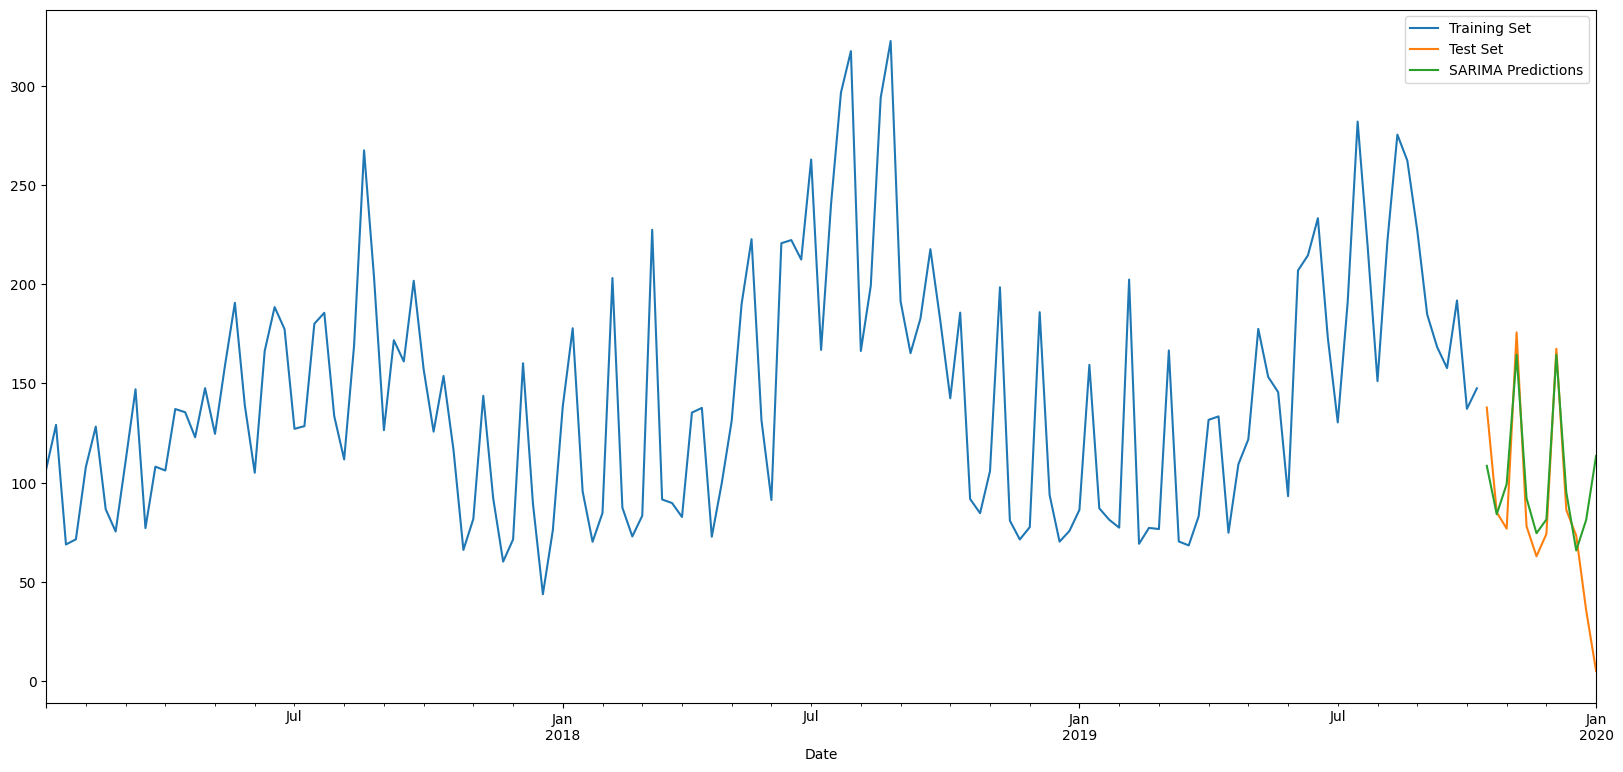

In [130]:
# Plot results

train_set['kwh'].rename('Training Set').plot(legend=True)
test_set['kwh'].rename('Test Set').plot(legend=True)
SARIMApredictions.plot(legend = True)
plt.show()

In [131]:
y_test

Date
2019-10-20    137.847
2019-10-27     84.999
2019-11-03     76.744
2019-11-10    175.708
2019-11-17     77.927
2019-11-24     62.805
2019-12-01     74.079
2019-12-08    167.481
2019-12-15     86.248
2019-12-22     73.206
2019-12-29     35.655
2020-01-05      4.947
Freq: W-SUN, Name: kwh, dtype: float64


### Let us use SARIMAX - Seasonal ARIMA with eXogenous Variable

In [132]:
model = SARIMAX(endog=train_set['kwh'],exog=train_set['Temp_avg'],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               kwh   No. Observations:                  145
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood                -732.174
Date:                           Fri, 10 Nov 2023   AIC                           1474.348
Time:                                   22:42:32   BIC                           1489.232
Sample:                               01-08-2017   HQIC                          1480.396
                                    - 10-13-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Temp_avg       2.1916      0.096     22.781      0.000       2.003       2.380
ar.L1          0.6524      0.064     10.202      0.000       0.527       0.778
ar.S.L7       -0.2007      0.089     -2.261      0.024      -0.375      -0.027
ar.S.L14      -0.0945      0.090     -1.048      0.294      -0.271       0.082
sigma2      1414.9974    193.794      7.302      0.000    1035.169    1794.826
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 2.42
Prob(Q):                              0.65   Prob(JB):                         0.30
Heteroskedasticity (H):               1.42   Skew:                             0.30
Prob(H) (two-sided):                  0.23   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [133]:
# Create and fit model

from statsmodels.tsa.statespace.sarimax import SARIMAX
model_SARIMAX = SARIMAX(train_set['kwh'], exog = train_set['Temp_avg'], order=order,seasonal_order=seasonal_order)
model_SARIMAX = model_SARIMAX.fit()
# model_SARIMA.summary()
model_SARIMAX.params

Temp_avg      4.494951
ar.L1         0.994501
ma.L1        -0.672744
ar.S.L52      0.996258
ma.S.L52     -0.936537
sigma2      680.303411
dtype: float64

In [134]:
# Create SARIMAX predictions

exog = test_set[['Temp_avg']]
start=len(train_set)
end=len(train_set)+len(test_set)-1
SARIMAXpredictions = model_SARIMAX.predict(start=start, end=end, exog = exog, dynamic=False, typ='levels').rename('SARIMAX Predictions')

In [135]:
# Calculate Evaluation Metrics 

y_test = test_set['kwh']
y_pred = SARIMAXpredictions
pd.DataFrame({'y_test': y_test, 'y_pred' : y_pred, 'diff':y_test - y_pred})

y_test      y_pred        diff
2019-10-20  137.847  135.762630    2.084370
2019-10-27   84.999   90.884021   -5.885021
2019-11-03   76.744   81.577953   -4.833953
2019-11-10  175.708  172.860135    2.847865
2019-11-17   77.927   35.830430   42.096570
2019-11-24   62.805   89.152707  -26.347707
2019-12-01   74.079  120.706976  -46.627976
2019-12-08  167.481  150.329857   17.151143
2019-12-15   86.248  100.167290  -13.919290
2019-12-22   73.206   22.178695   51.027305
2019-12-29   35.655   96.057753  -60.402753
2020-01-05    4.947 -156.713632  161.660632

In [136]:
# Metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error
print('MSE = ', mean_squared_error(y_test,y_pred))
print('RMSE = ', np.sqrt(mean_squared_error(y_test,y_pred)))
print('MAE = ', mean_absolute_error(y_test,y_pred))

MSE =  3132.1077834193397
RMSE =  55.96523727653926
MAE =  36.240382161713455


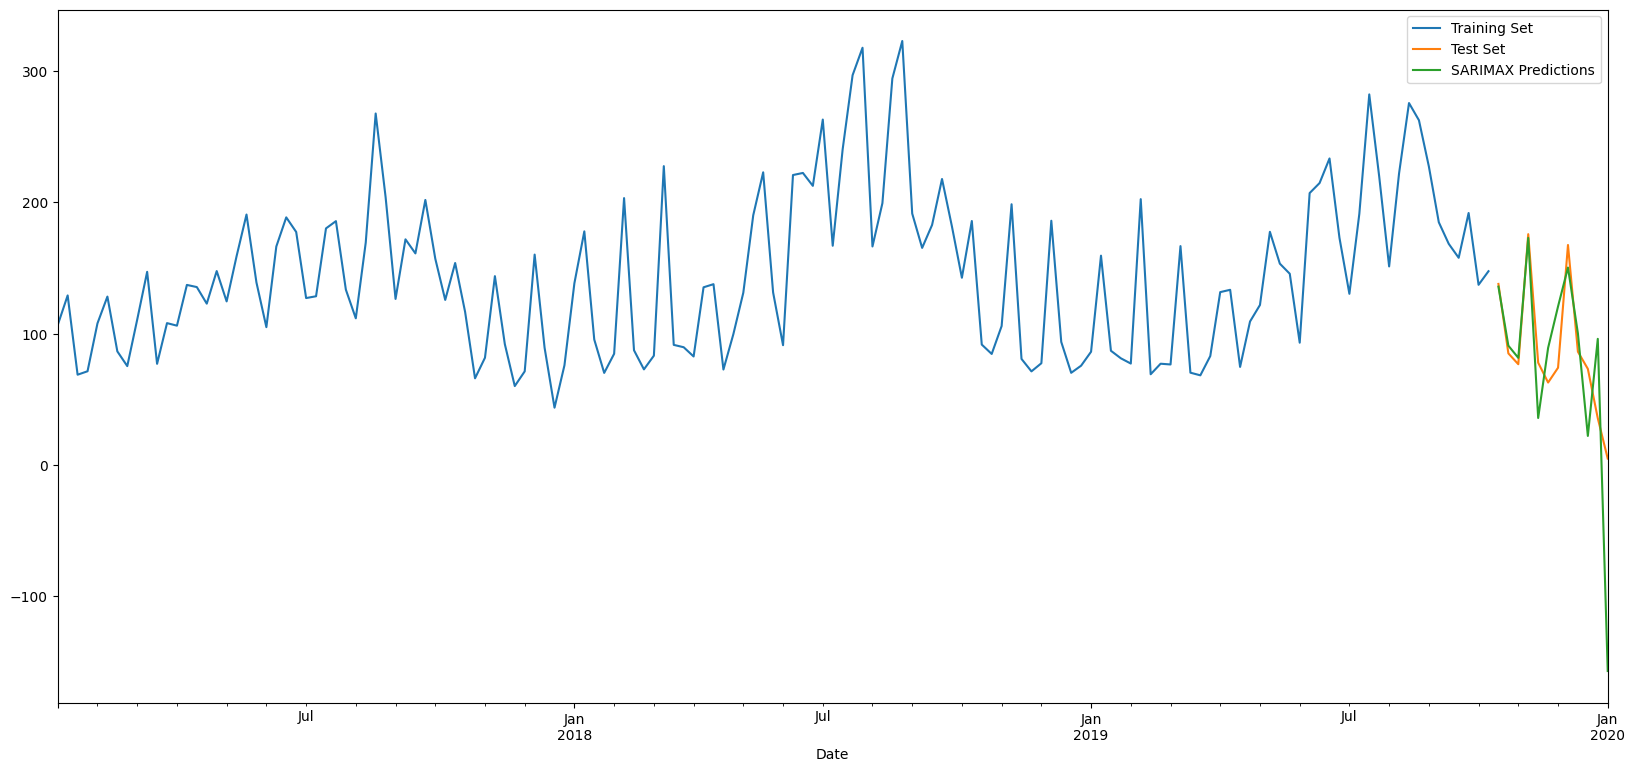

In [137]:
# Plot results

train_set['kwh'].rename('Training Set').plot(legend=True)
test_set['kwh'].rename('Test Set').plot(legend=True)
SARIMAXpredictions.plot(legend = True)
plt.show()

In [138]:
y_test

Date
2019-10-20    137.847
2019-10-27     84.999
2019-11-03     76.744
2019-11-10    175.708
2019-11-17     77.927
2019-11-24     62.805
2019-12-01     74.079
2019-12-08    167.481
2019-12-15     86.248
2019-12-22     73.206
2019-12-29     35.655
2020-01-05      4.947
Freq: W-SUN, Name: kwh, dtype: float64

## FB Prophet

https://facebook.github.io/prophet/

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 

It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Prophet is superior to other methods as it can detect and account for multiple layers of seasonality in the same dataset. 
(What does this mean: Data may have hourly, weekly as well as monthly seasonality, all distinct from each other.  Other methods will calculate seasonality at the granularity level of the data, ie, to get monthly seasonality you need to provide monthly data using resampling.)


In [139]:
# Python
import pandas as pd
from prophet import Prophet


In [140]:
# Train-test split
train_samples = int(new_df.shape[0] * 0.8)

train_set = new_df.iloc[:train_samples]
test_set = new_df.iloc[train_samples:]

print("Training set: ", train_set.shape[0])
print("Test set: ", test_set.shape[0])

Training set:  60
Test set:  15


In [141]:
train_set.head()

Total  Moving_Avg_6m  Moving_Avg_12m        EWMA12
Date                                                            
2013-09-30  80729.0   97184.000000    74734.583333  82750.448591
2013-10-31  81352.0   98743.000000    76039.333333  82535.302654
2013-11-30  59270.0   90525.666667    76757.916667  78956.025322
2013-12-31  43553.0   81237.833333    77356.583333  73509.406042
2014-01-31  59873.0   71554.333333    78605.666667  71411.497420

In [142]:
# Create the ds and y columns for Prophet
train_set_prophet = train_set.reset_index()
train_set_prophet = train_set_prophet[['Date', 'Total']]
train_set_prophet.columns = ['ds', 'y']
train_set_prophet.head()

ds        y
0 2013-09-30  80729.0
1 2013-10-31  81352.0
2 2013-11-30  59270.0
3 2013-12-31  43553.0
4 2014-01-31  59873.0

In [143]:
model = Prophet()
model.fit(train_set_prophet)

22:42:37 - cmdstanpy - INFO - Chain [1] start processing
22:42:37 - cmdstanpy - INFO - Chain [1] done processing


In [144]:
future = model.make_future_dataframe(periods=15,freq = 'm')
future.tail()

ds
70 2019-07-31
71 2019-08-31
72 2019-09-30
73 2019-10-31
74 2019-11-30

In [145]:
future.shape

(75, 1)

In [146]:
# Python
forecast = model.predict(future)

In [147]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [148]:
forecast.head()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2013-09-30  83323.589562  85819.953093  99008.026474  83323.589562   
1 2013-10-31  83286.808660  73361.637478  86911.006692  83286.808660   
2 2013-11-30  83251.214239  53784.220687  66821.426791  83251.214239   
3 2013-12-31  83214.433337  36997.798701  50727.126628  83214.433337   
4 2014-01-31  83177.652434  49717.718616  62756.802402  83177.652434   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  83323.589562     9120.391098           9120.391098           9120.391098   
1  83286.808660    -2989.685567          -2989.685567          -2989.685567   
2  83251.214239   -23011.327489         -23011.327489         -23011.327489   
3  83214.433337   -39468.043632         -39468.043632         -39468.043632   
4  83177.652434   -26943.934360         -26943.934360         -26943.934360   

         yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0   9120.391098   9120.391098   9120.391098                   0.0   
1  -2989.685567  -2989.685567  -2989.685567                   0.0   
2 -23011.327489 -23011.327489 -23011.327489                   0.0   
3 -39468.043632 -39468.043632 -39468.043632                   0.0   
4 -26943.934360 -26943.934360 -26943.934360                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  92443.980660  
1                         0.0                         0.0  80297.123093  
2                         0.0                         0.0  60239.886750  
3                         0.0                         0.0  43746.389705  
4                         0.0                         0.0  56233.718075

In [149]:
preds = pd.DataFrame({'Prediction': forecast.yhat[-15:]})
preds.index = pd.to_datetime(forecast.ds[-15:])
preds.index.names = ['Date']
preds

Prediction
Date                     
2018-09-30   96887.285693
2018-10-31   88140.126499
2018-11-30   62980.805485
2018-12-31   50953.542730
2019-01-31   62367.352742
2019-02-28   56888.480539
2019-03-31   76208.358529
2019-04-30   86669.010005
2019-05-31  122794.851343
2019-06-30  120372.674873
2019-07-31  128458.704108
2019-08-31  114207.558640
2019-09-30  101186.010180
2019-10-31   95354.181624
2019-11-30   64717.364105

In [150]:
# Calculate Evaluation Metrics

y_test = test_set['Total'] 
y_pred = preds['Prediction']
pd.DataFrame({'y_test': y_test, 'y_pred' : y_pred, 'diff':y_test - y_pred})

y_test         y_pred          diff
Date                                             
2018-09-30   96242.0   96887.285693   -645.285693
2018-10-31   90982.0   88140.126499   2841.873501
2018-11-30   68431.0   62980.805485   5450.194515
2018-12-31   46941.0   50953.542730  -4012.542730
2019-01-31   72883.0   62367.352742  10515.647258
2019-02-28   36099.0   56888.480539 -20789.480539
2019-03-31   85457.0   76208.358529   9248.641471
2019-04-30   87932.0   86669.010005   1262.989995
2019-05-31  129123.0  122794.851343   6328.148657
2019-06-30  132512.0  120372.674873  12139.325127
2019-07-31  137714.0  128458.704108   9255.295892
2019-08-31  142414.0  114207.558640  28206.441360
2019-09-30  112174.0  101186.010180  10987.989820
2019-10-31  104498.0   95354.181624   9143.818376
2019-11-30   84963.0   64717.364105  20245.635895

In [151]:
# Model evaluation

from sklearn.metrics import mean_absolute_error, mean_squared_error
print('MSE = ', mean_squared_error(y_test,y_pred))
print('RMSE = ', np.sqrt(mean_squared_error(y_test,y_pred)))
print('MAE = ', mean_absolute_error(y_test,y_pred))

MSE =  157807682.19504696
RMSE =  12562.15276913344
MAE =  10071.55405527476


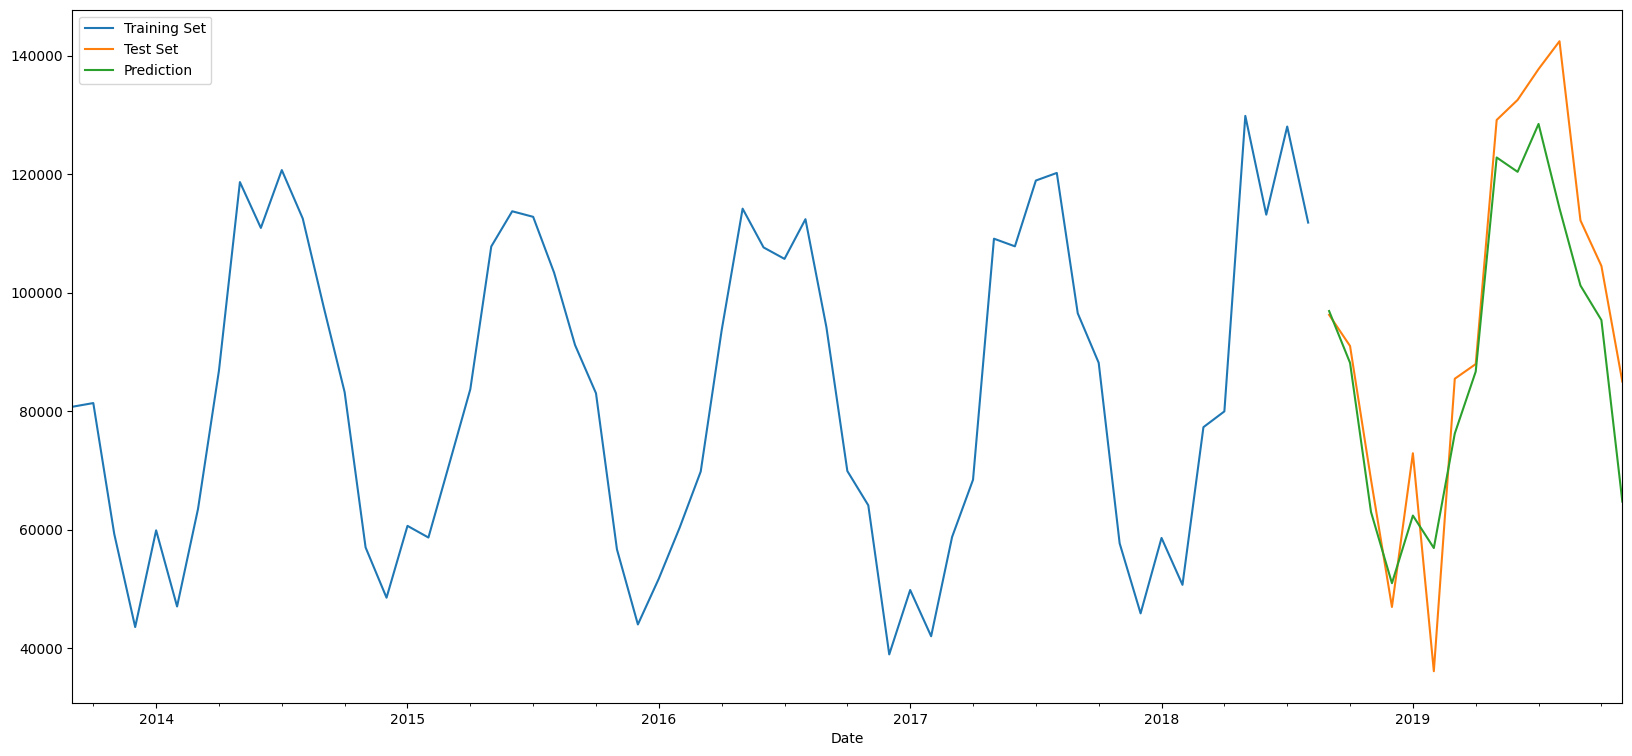

In [152]:
# Plot results

train_set['Total'].rename('Training Set').plot(legend=True)
test_set['Total'].rename('Test Set').plot(legend=True)
preds.Prediction.plot(legend = True)
plt.show()

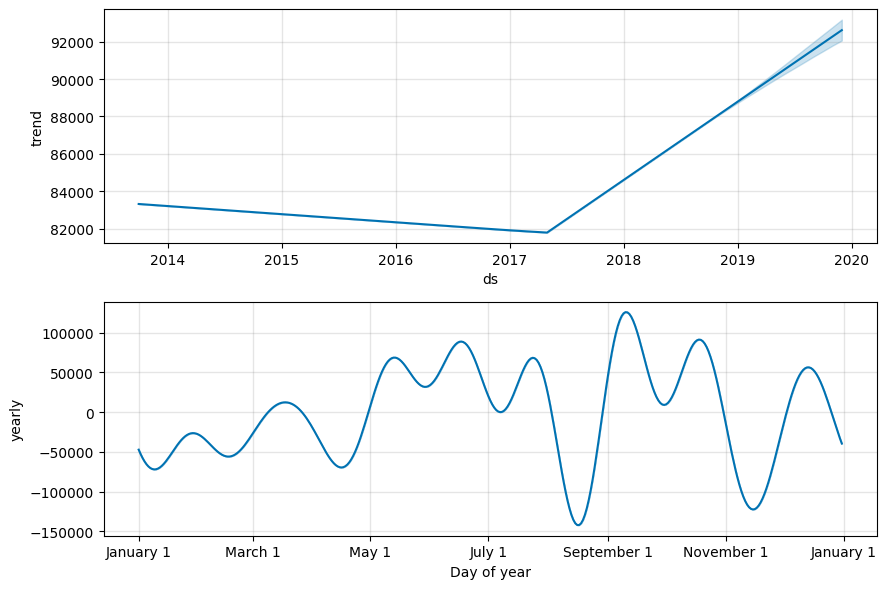

In [153]:
model.plot_components(forecast);

### Modeling Daily Data with Prophet

In [154]:
df = pd.read_csv('https://data.seattle.gov/api/views/65db-xm6k/rows.csv')

In [155]:
df

Date  Fremont Bridge Sidewalks, south of N 34th St  \
0      08/01/2022 12:00:00 AM                                          23.0   
1      08/01/2022 01:00:00 AM                                          12.0   
2      08/01/2022 02:00:00 AM                                           3.0   
3      08/01/2022 03:00:00 AM                                           5.0   
4      08/01/2022 04:00:00 AM                                          10.0   
...                       ...                                           ...   
95635  08/31/2023 07:00:00 PM                                         224.0   
95636  08/31/2023 08:00:00 PM                                         142.0   
95637  08/31/2023 09:00:00 PM                                          67.0   
95638  08/31/2023 10:00:00 PM                                          43.0   
95639  08/31/2023 11:00:00 PM                                          12.0   

       Fremont Bridge Sidewalks, south of N 34th St Cyclist East Sidewalk  \
0                                                    7.0                    
1                                                    5.0                    
2                                                    0.0                    
3                                                    2.0                    
4                                                    2.0                    
...                                                  ...                    
95635                                               72.0                    
95636                                               59.0                    
95637                                               35.0                    
95638                                               18.0                    
95639                                                8.0                    

       Fremont Bridge Sidewalks, south of N 34th St Cyclist West Sidewalk  
0                                                   16.0                   
1                                                    7.0                   
2                                                    3.0                   
3                                                    3.0                   
4                                                    8.0                   
...                                                  ...                   
95635                                              152.0                   
95636                                               83.0                   
95637                                               32.0                   
95638                                               25.0                   
95639                                                4.0                   

[95640 rows x 4 columns]

In [156]:
# Rename the columns to make them simpler to use
df.columns = ['Date', 'Total', 'East', 'West']

In [157]:
# Create the Date column
df['Date'] = pd.DatetimeIndex(df.Date)

In [158]:
df.head()

Date  Total  East  West
0 2022-08-01 00:00:00   23.0   7.0  16.0
1 2022-08-01 01:00:00   12.0   5.0   7.0
2 2022-08-01 02:00:00    3.0   0.0   3.0
3 2022-08-01 03:00:00    5.0   2.0   3.0
4 2022-08-01 04:00:00   10.0   2.0   8.0

In [159]:
# Create the ds and y columns for Prophet

df2 = df[['Date', 'Total']]
df2.columns = ['ds', 'y']
df2

ds      y
0     2022-08-01 00:00:00   23.0
1     2022-08-01 01:00:00   12.0
2     2022-08-01 02:00:00    3.0
3     2022-08-01 03:00:00    5.0
4     2022-08-01 04:00:00   10.0
...                   ...    ...
95635 2023-08-31 19:00:00  224.0
95636 2023-08-31 20:00:00  142.0
95637 2023-08-31 21:00:00   67.0
95638 2023-08-31 22:00:00   43.0
95639 2023-08-31 23:00:00   12.0

[95640 rows x 2 columns]

In [160]:
# Remove post-Covid data 

df_precovid = df2[df2.ds < pd.to_datetime('2019-12-31')]

In [161]:
%%time
model = Prophet()
model.fit(df_precovid)

22:42:53 - cmdstanpy - INFO - Chain [1] start processing
22:43:07 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 1.7 s
Wall time: 19.3 s


In [162]:
future = model.make_future_dataframe(periods=365)
future.tail()

ds
63829 2020-12-25 23:00:00
63830 2020-12-26 23:00:00
63831 2020-12-27 23:00:00
63832 2020-12-28 23:00:00
63833 2020-12-29 23:00:00

In [163]:
type(future)

pandas.core.frame.DataFrame

In [164]:
future.shape

(63834, 1)

In [165]:
%%time
forecast = model.predict(future)

CPU times: total: 2.3 s
Wall time: 8.74 s


In [166]:
type(forecast)

pandas.core.frame.DataFrame

In [167]:
forecast.shape

(63834, 22)

In [168]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [169]:
# forecast.to_excel('forecast.xlsx')

In [170]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
63829 2020-12-25 23:00:00 -16.020172 -142.659821  105.518723
63830 2020-12-26 23:00:00 -67.037196 -191.451418   42.315426
63831 2020-12-27 23:00:00 -22.832529 -145.837458   87.747590
63832 2020-12-28 23:00:00  27.544487  -85.548906  145.626637
63833 2020-12-29 23:00:00  26.487504  -87.689924  157.621258

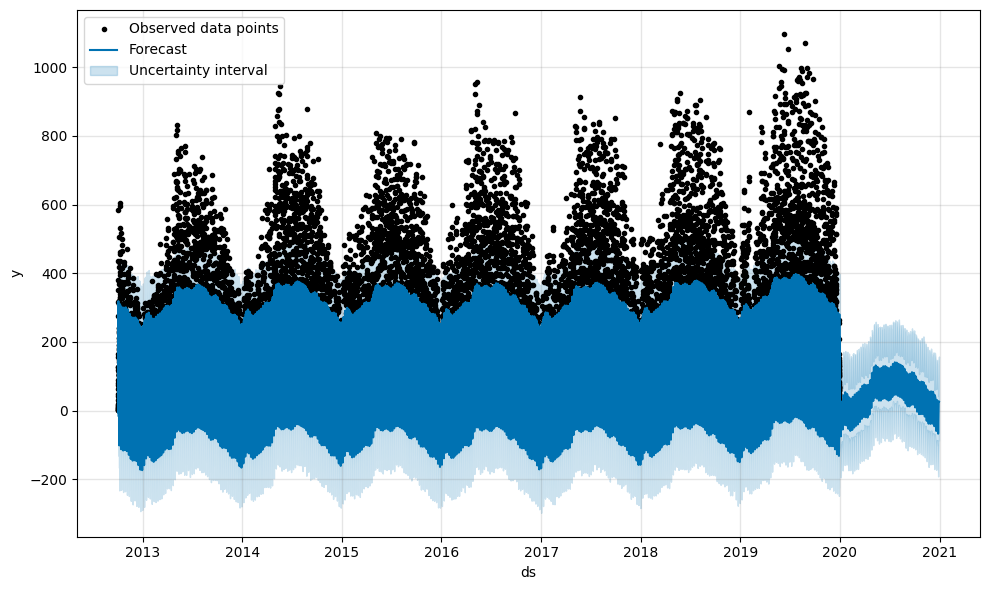

In [171]:
# Python
fig1 = model.plot(forecast, include_legend=True)


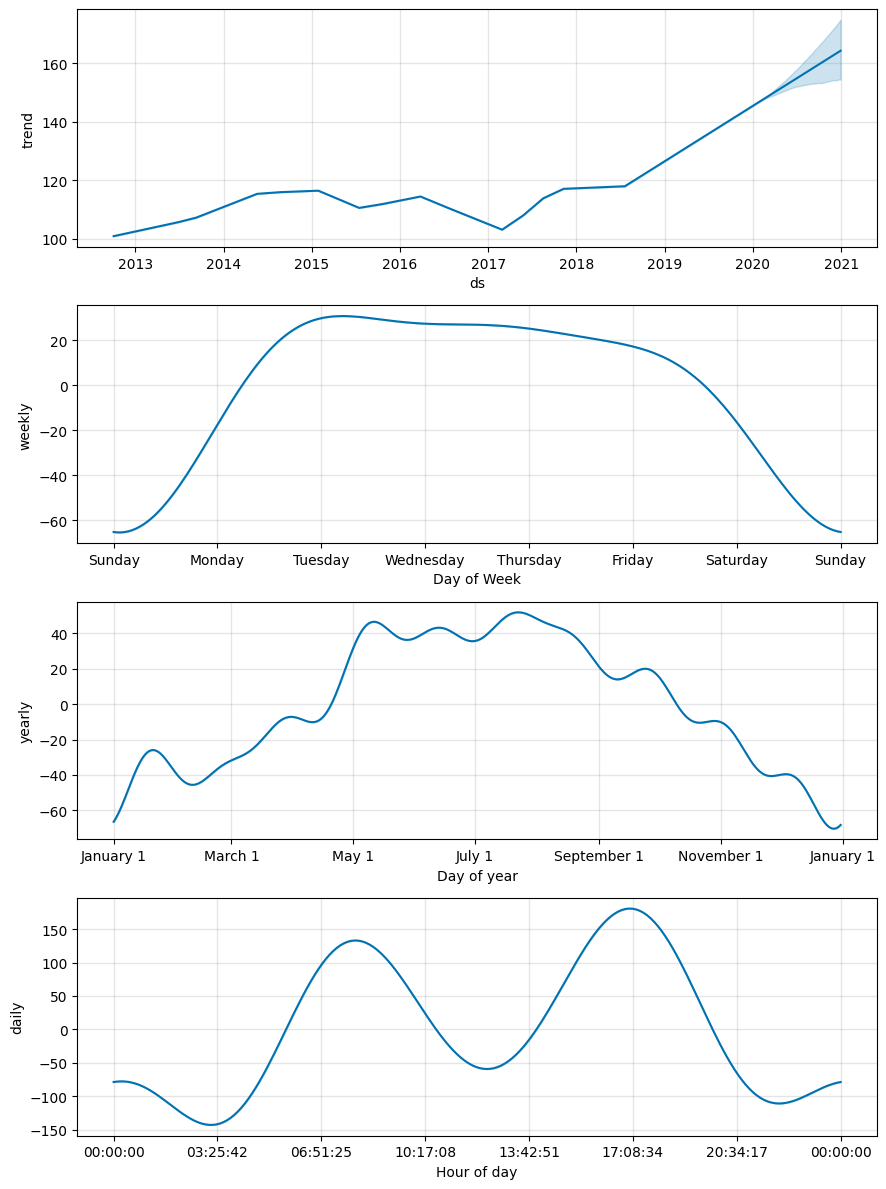

In [172]:
# Python
fig2 = model.plot_components(forecast)

***
## Deep Learning - Timeseries prediction using RNNs

Prediction with a deep neural network:  
1. Split the data into train and test.  
2. Decide how many time periods to use for prediction, and divide the data into $X$ and $y$ using `Timeseries.Generator` from Tensorflow.  
3. Create a model and predict the first observation.  
4. Then predict subsequent observations after including the earlier prediction.  
5. Repeat to get as many prediction as you need (typically equal to the test set size).
Evaluate the model.  




In [173]:
# We use the same train and test sets that were created in the previous example
# Let us look at the dates in the train_set.  

train_set.index

DatetimeIndex(['2013-09-30', '2013-10-31', '2013-11-30', '2013-12-31',
               '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31', '2015-11-30', '2015-12-31',
               '2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
               '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
      

In [174]:
train_set = train_set[['Total']]
test_set = test_set[['Total']]

In [175]:
# We will do standard scaling as we are using a neural net

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

In [176]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET

std_scaler.fit(train_set)

StandardScaler()

In [177]:
# Now we transform using the standard scaler instantiated above

std_train = std_scaler.transform(train_set)
std_test = std_scaler.transform(test_set)

In [178]:
std_train.shape

(60, 1)

In [179]:
std_test.shape

(15, 1)

### Create Sequences

In [180]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# define generator
lag = 12
batch_size = 1
sequences = TimeseriesGenerator(std_train, std_train, length=lag, batch_size=batch_size)

In [181]:
# Let us see what our standard scaled training data looks like.

std_train

array([[-0.06864305],
       [-0.0450607 ],
       [-0.88092804],
       [-1.47586179],
       [-0.85810276],
       [-1.34443658],
       [-0.72103747],
       [ 0.16324371],
       [ 1.36654898],
       [ 1.07368123],
       [ 1.44320106],
       [ 1.13360234],
       [ 0.56838311],
       [ 0.02428578],
       [-0.96723261],
       [-1.28833861],
       [-0.82944812],
       [-0.90405615],
       [-0.43146292],
       [ 0.04370431],
       [ 0.955126  ],
       [ 1.18004783],
       [ 1.14457968],
       [ 0.78766485],
       [ 0.32544331],
       [ 0.01743441],
       [-0.97942124],
       [-1.45924438],
       [-1.16622522],
       [-0.83887349],
       [-0.48218578],
       [ 0.42003766],
       [ 1.1967788 ],
       [ 0.94914525],
       [ 0.87593777],
       [ 1.12943852],
       [ 0.43964545],
       [-0.47919541],
       [-0.69821218],
       [-1.6505907 ],
       [-1.23920557],
       [-1.53460946],
       [-0.9007251 ],
       [-0.53483914],
       [ 1.00486469],
       [ 0

In [182]:
len(std_train)

60

In [183]:
len(sequences) # n_input = 2

48

In [184]:
# What does the first batch look like?
X,y = sequences[0]

In [185]:
X

array([[[-0.06864305],
        [-0.0450607 ],
        [-0.88092804],
        [-1.47586179],
        [-0.85810276],
        [-1.34443658],
        [-0.72103747],
        [ 0.16324371],
        [ 1.36654898],
        [ 1.07368123],
        [ 1.44320106],
        [ 1.13360234]]])

In [186]:
y

array([[0.56838311]])

In [187]:
# What does the second batch look like?
X,y = sequences[1]

In [188]:
X

array([[[-0.0450607 ],
        [-0.88092804],
        [-1.47586179],
        [-0.85810276],
        [-1.34443658],
        [-0.72103747],
        [ 0.16324371],
        [ 1.36654898],
        [ 1.07368123],
        [ 1.44320106],
        [ 1.13360234],
        [ 0.56838311]]])

In [189]:
y

array([[0.02428578]])

### Create the Model

In [190]:
# First, some library imports

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf

In [191]:
# We will go with a very simple architecture, a sequential model 
# with just one hidden LSTM layer. Define model:  

model = Sequential()
model.add(LSTM(100, input_shape=(lag, batch_size)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [192]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [193]:
# fit model

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
history = model.fit_generator(sequences,epochs=50, callbacks=[callback])

Epoch 1/50
48/48 [==============================] - 2s 7ms/step - loss: 0.5581
Epoch 2/50
48/48 [==============================] - 0s 7ms/step - loss: 0.2086
Epoch 3/50
48/48 [==============================] - 0s 5ms/step - loss: 0.2686
Epoch 4/50
48/48 [==============================] - 0s 5ms/step - loss: 0.1574
Epoch 5/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1408
Epoch 6/50
48/48 [==============================] - 0s 6ms/step - loss: 0.1744
Epoch 7/50
48/48 [==============================] - 0s 6ms/step - loss: 0.1421
Epoch 8/50
48/48 [==============================] - 0s 6ms/step - loss: 0.1696
Epoch 9/50
48/48 [==============================] - 0s 6ms/step - loss: 0.1318
Epoch 10/50
48/48 [==============================] - 0s 4ms/step - loss: 0.1321
Epoch 11/50
48/48 [==============================] - 0s 6ms/step - loss: 0.1318
Epoch 12/50
48/48 [==============================] - 0s 6ms/step - loss: 0.1423
Epoch 13/50
48/48 [==============================

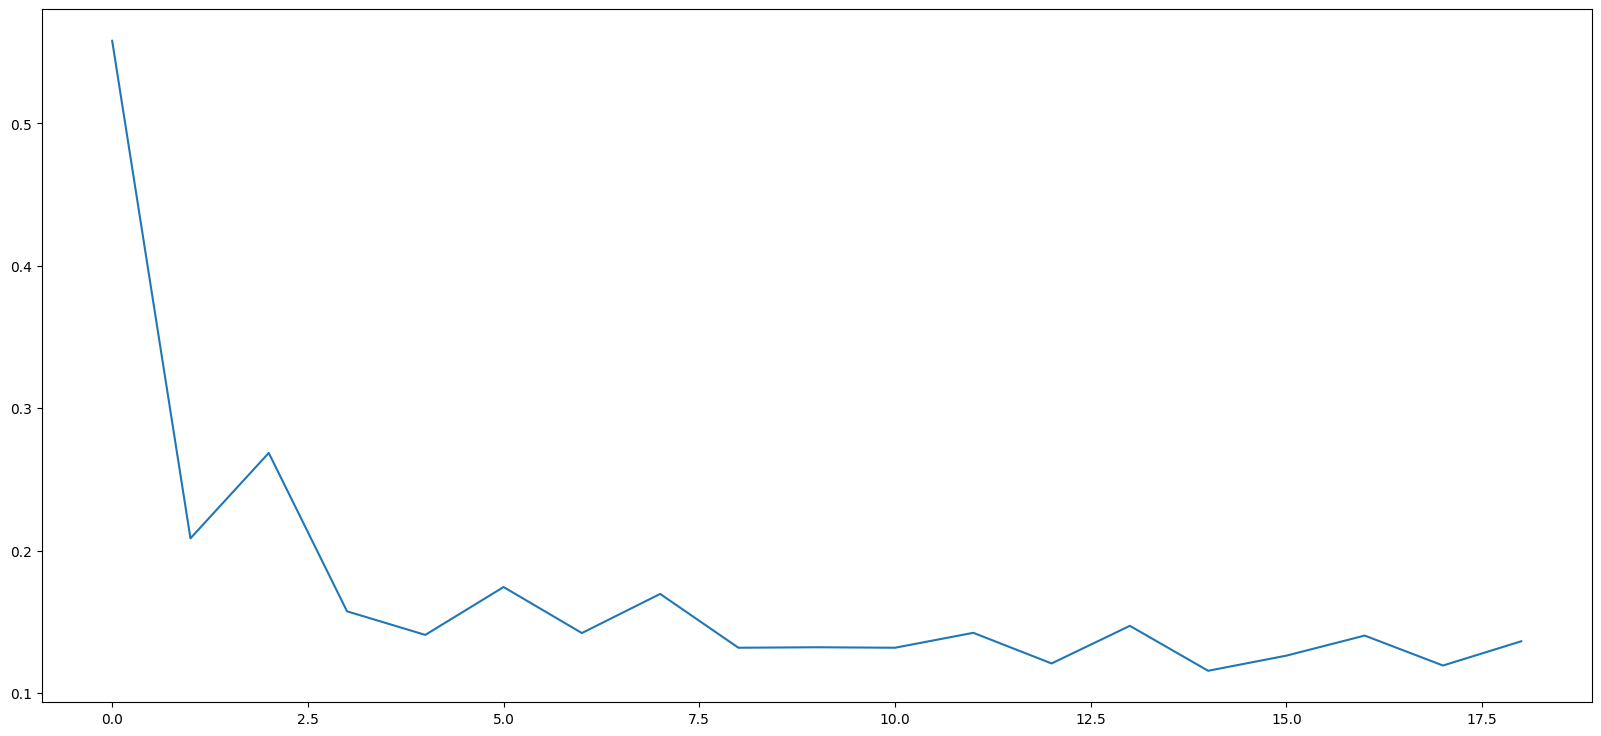

In [194]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

### Evaluate on Test Data  

As part of our training, we used the preceding 12 values to predict the next one.  Now we will use the last 12 values of the training data to predict the first value of the test data.  Then we will add this predicted value to our sequence, and predict the next one, and so on. 

In [195]:
lag

12

In [196]:
# Pick the last 12 values in the training data

predictors = std_train[-lag:]

In [197]:
# See what they look like...

predictors

array([[ 0.52825905],
       [ 0.21199822],
       [-0.94096271],
       [-1.38845949],
       [-0.90663015],
       [-1.20619786],
       [-0.19904623],
       [-0.098244  ],
       [ 1.78932782],
       [ 1.15839598],
       [ 1.72138189],
       [ 1.10782453]])

We will need to reshape this data to feed into our LSTM layer which expects a 3 dimensional input.  We do that next.  

In [198]:
predictors = predictors.reshape((1, lag, 1))

Next, we perform the prediction to get the first item after the training data has ended.  This prediction will come in as standard-scaled, so we will need to reverse out the scaling to get the true prediction.  

In [199]:
# Predict 

x = model.predict(predictors)
x

1/1 [==============================] - 0s 414ms/step


array([[0.45122966]], dtype=float32)

In [200]:
# Do an inverse transform to get the actual prediction

std_scaler.inverse_transform(x)

array([[94463.03]], dtype=float32)

In [201]:
# Let us see what the actual value in the test set was.

test_set.iloc[1]

Total    90982.0
Name: 2018-10-31 00:00:00, dtype: float64

Now we can predict the next data point.  However, doing this manually is going to be very tedious, so we write some code to loop through this and do it for as many times as we need the predictions for.  

In [202]:
predictors = std_train[-lag:].reshape((1, lag, 1))
predictions = []
for i in range(len(std_test)):
    next_pred = model.predict(predictors)[0]
    predictions.append(next_pred) 
    predictors = np.append(predictors[:,1:,:],[[next_pred]],axis=1)

predictions

1/1 [==============================] - 0s 25ms/step


[array([0.45122966], dtype=float32),
 array([-0.3290154], dtype=float32),
 array([-1.0449202], dtype=float32),
 array([-1.4312159], dtype=float32),
 array([-1.4465744], dtype=float32),
 array([-1.1398427], dtype=float32),
 array([-0.48234788], dtype=float32),
 array([0.2781088], dtype=float32),
 array([1.047395], dtype=float32),
 array([1.4374696], dtype=float32),
 array([1.5440987], dtype=float32),
 array([1.1877004], dtype=float32),
 array([0.53592247], dtype=float32),
 array([-0.24500774], dtype=float32),
 array([-0.94227564], dtype=float32)]

In [203]:
# We inverse transform these scaled predictions

final_predictions = std_scaler.inverse_transform(predictions)
final_predictions

array([[ 94463.03240163],
       [ 73850.4654616 ],
       [ 54937.64395903],
       [ 44732.45864597],
       [ 44326.71497745],
       [ 52429.97380651],
       [ 69799.71784522],
       [ 89889.51390621],
       [110212.56840795],
       [120517.58586778],
       [123334.52152427],
       [113919.16595602],
       [ 96700.45268135],
       [ 76069.78565349],
       [ 57649.31496236]])

<Axes: xlabel='Date'>

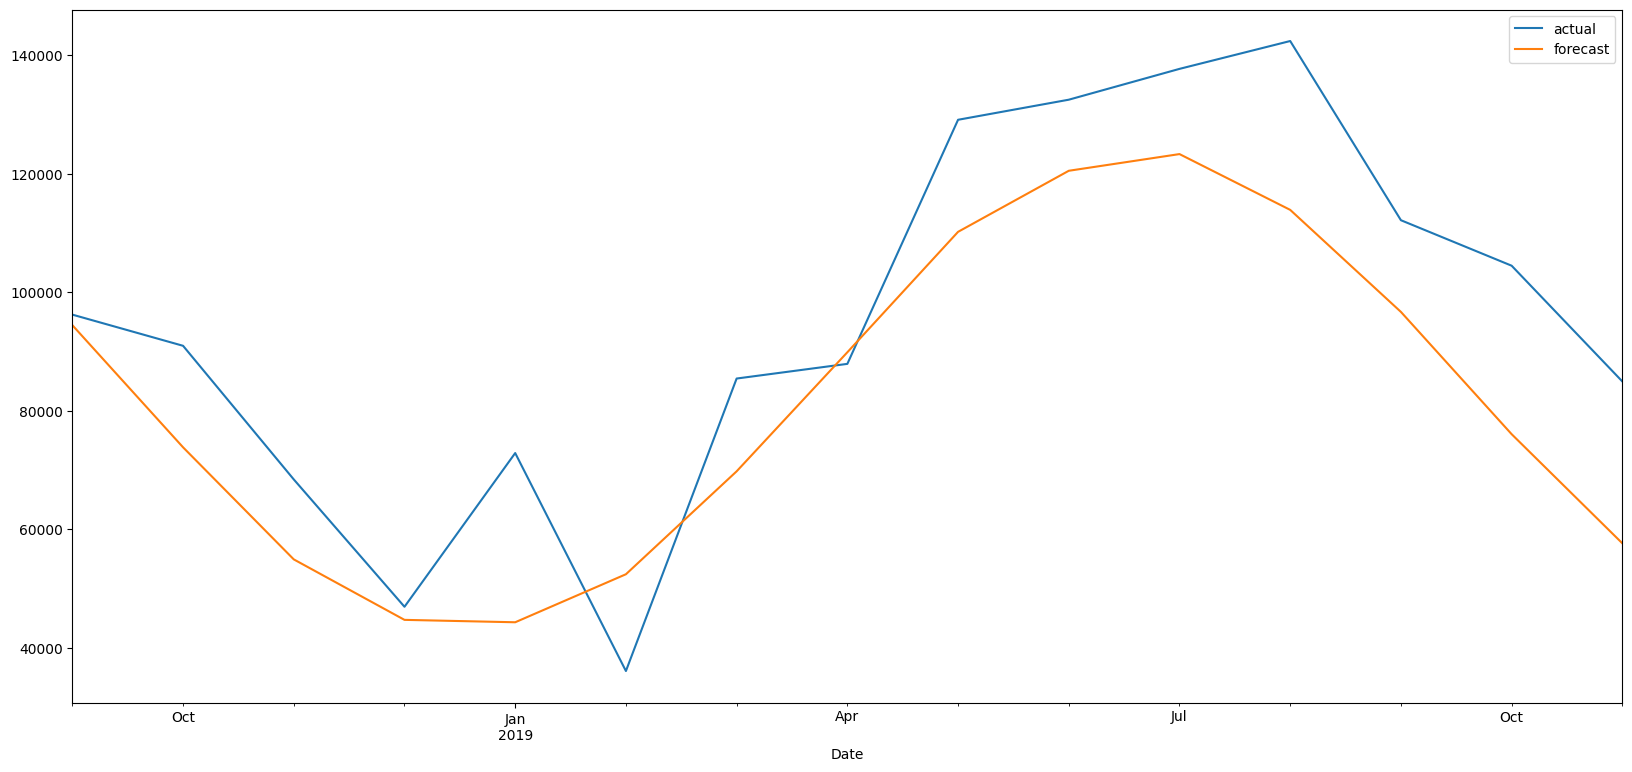

In [204]:
# Now let us plot the actuals versus the predicted values

pd.DataFrame({'actual': test_set.Total, 'forecast': final_predictions.flatten()}).plot()

In [205]:
# Next, we evaluate our model using some metrics

y_test = test_set.Total
y_pred = final_predictions.flatten()

from sklearn.metrics import mean_absolute_error, mean_squared_error
print('MSE = ', mean_squared_error(y_test,y_pred))
print('RMSE = ', np.sqrt(mean_squared_error(y_test,y_pred)))
print('MAE = ', mean_absolute_error(y_test,y_pred))

MSE =  341904917.8754553
RMSE =  18490.671103977144
MAE =  16140.603957905736


## Which method performed best?

Here is a summary of model performance above.  The numbers would change each time you run it, but should give us a picture.

EWMA  
MSE =  1228535508.79919  
RMSE =  35050.47087842316  
MAE =  29263.82507577501  
  
DES  
MSE =  6789777046.197141  
RMSE =  82400.10343559734  
MAE =  75161.63066121914  

TES  
MSE =  160014279.71049073  
RMSE =  12649.675083198412  
MAE =  10899.78971069559  

ARIMA no seasonality  
MSE =  385065540.80112064  
RMSE =  19623.086933536237  
MAE =  17158.523051864664  

SARIMA  
MSE =  231993016.8844547  
RMSE =  15231.316978004716  
MAE =  12576.568673608848  

Prophet  
MSE =  157807679.90652037  
RMSE =  12562.152678045286  
MAE =  10071.553953152606  

Deep Learning  
MSE =  449731703.1802  
RMSE =  21206.87867603811  
MAE =  18007.781001223593  

***
## Experiment - Can we predict the S&P500

In [206]:
# Let us get some data.  We download the daily time series for the S&P500 for 30 months

import yfinance as yf
SPY = yf.download('SPY', start = '2013-01-01', end = '2015-06-30')

[*********************100%%**********************]  1 of 1 completed


In [207]:
# Clean up

SPY.index = pd.DatetimeIndex(SPY.index) # Set index
SPY = SPY.asfreq('B') # This creates rows for any missing dates
SPY.fillna(method = 'bfill', inplace=True) # Fills missing dates with last observation

In [208]:
SPY.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 649 entries, 2013-01-02 to 2015-06-29
Freq: B
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       649 non-null    float64
 1   High       649 non-null    float64
 2   Low        649 non-null    float64
 3   Close      649 non-null    float64
 4   Adj Close  649 non-null    float64
 5   Volume     649 non-null    float64
dtypes: float64(6)
memory usage: 35.5 KB


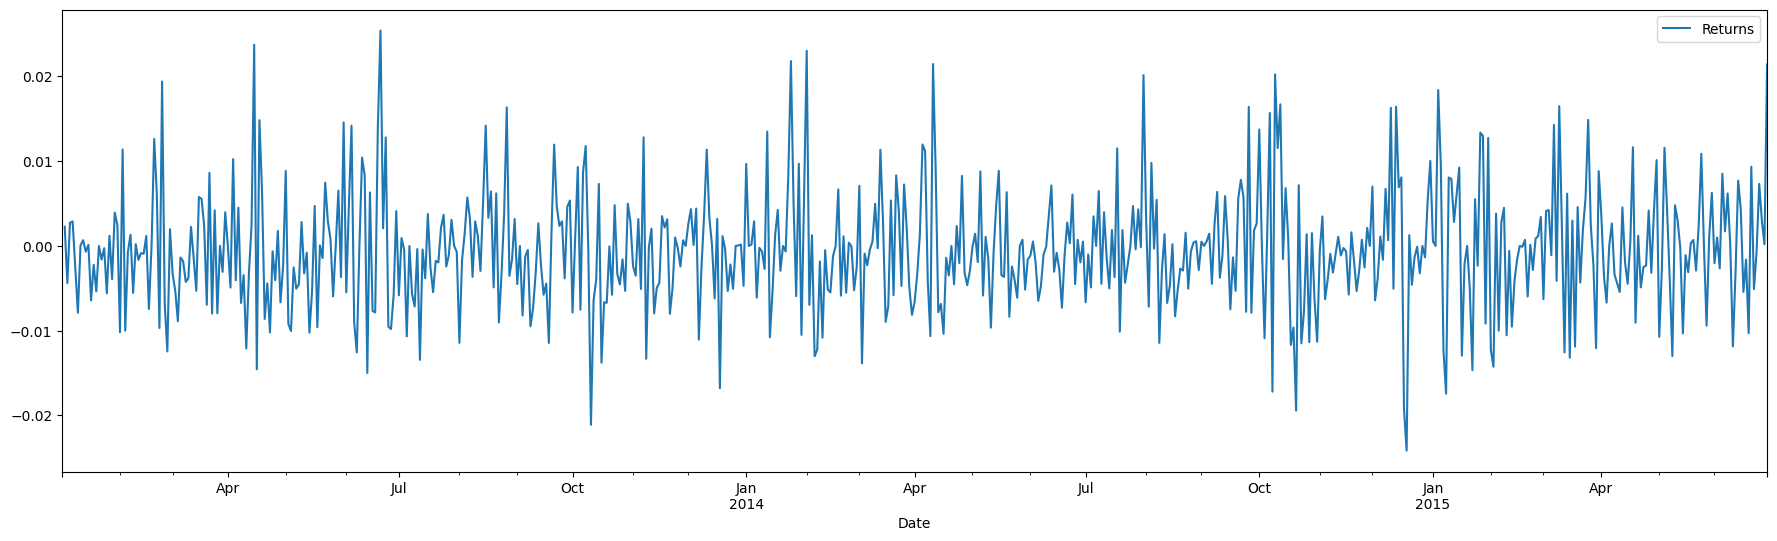

In [209]:
SPY['Returns'] = (SPY['Close'].shift(1) / SPY['Close']) - 1
SPY[['Returns']].plot(figsize = (22,6));


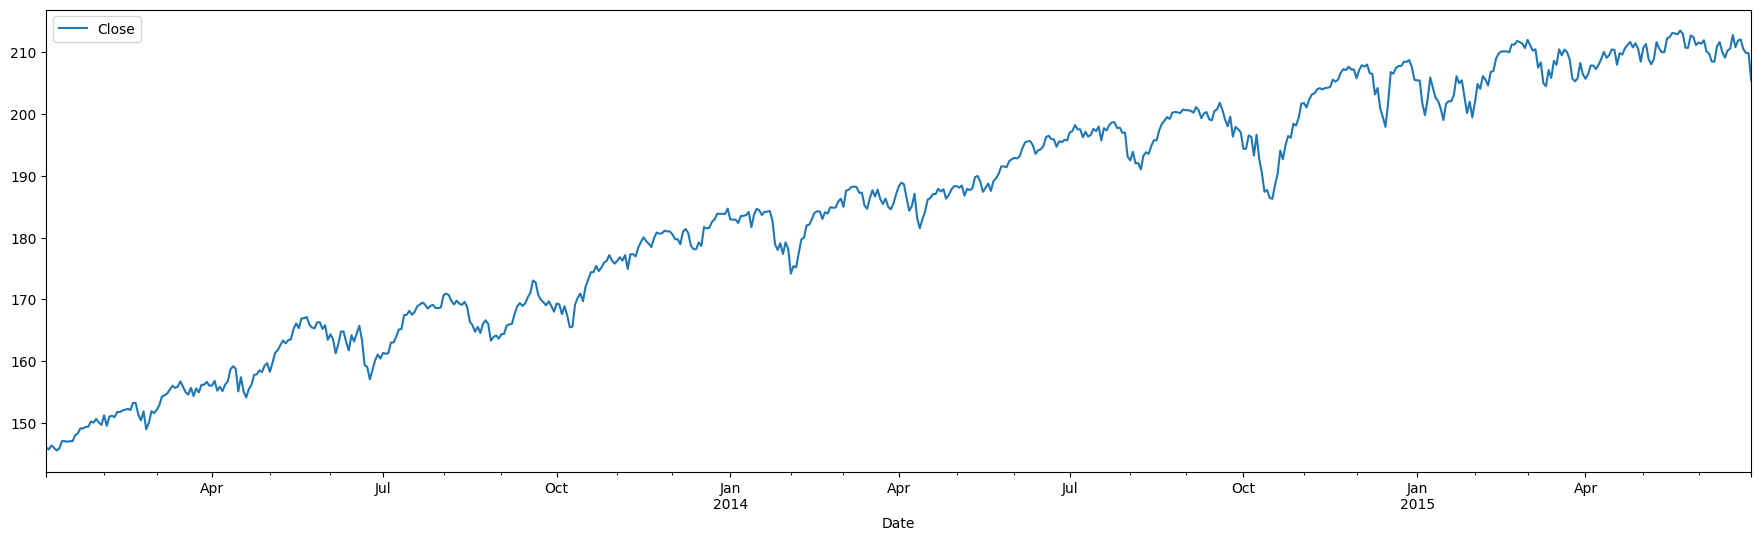

In [210]:
SPY[['Close']].plot(figsize = (22,6));

In [211]:
# Train-test split
train_samples = int(SPY.shape[0] * 0.8)

train_set = SPY.iloc[:train_samples]
test_set = SPY.iloc[train_samples:]

print("Training set: ", train_set.shape[0])
print("Test set: ", test_set.shape[0])

Training set:  519
Test set:  130


In [212]:
model = auto_arima(train_set['Close'], seasonal=True , m = 12)

In [213]:
order = model.get_params()['order']
seasonal_order = model.get_params()['seasonal_order']

print('Order = ', order)
print('Seasonal Order = ', seasonal_order)

Order =  (0, 1, 0)
Seasonal Order =  (0, 0, 0, 12)


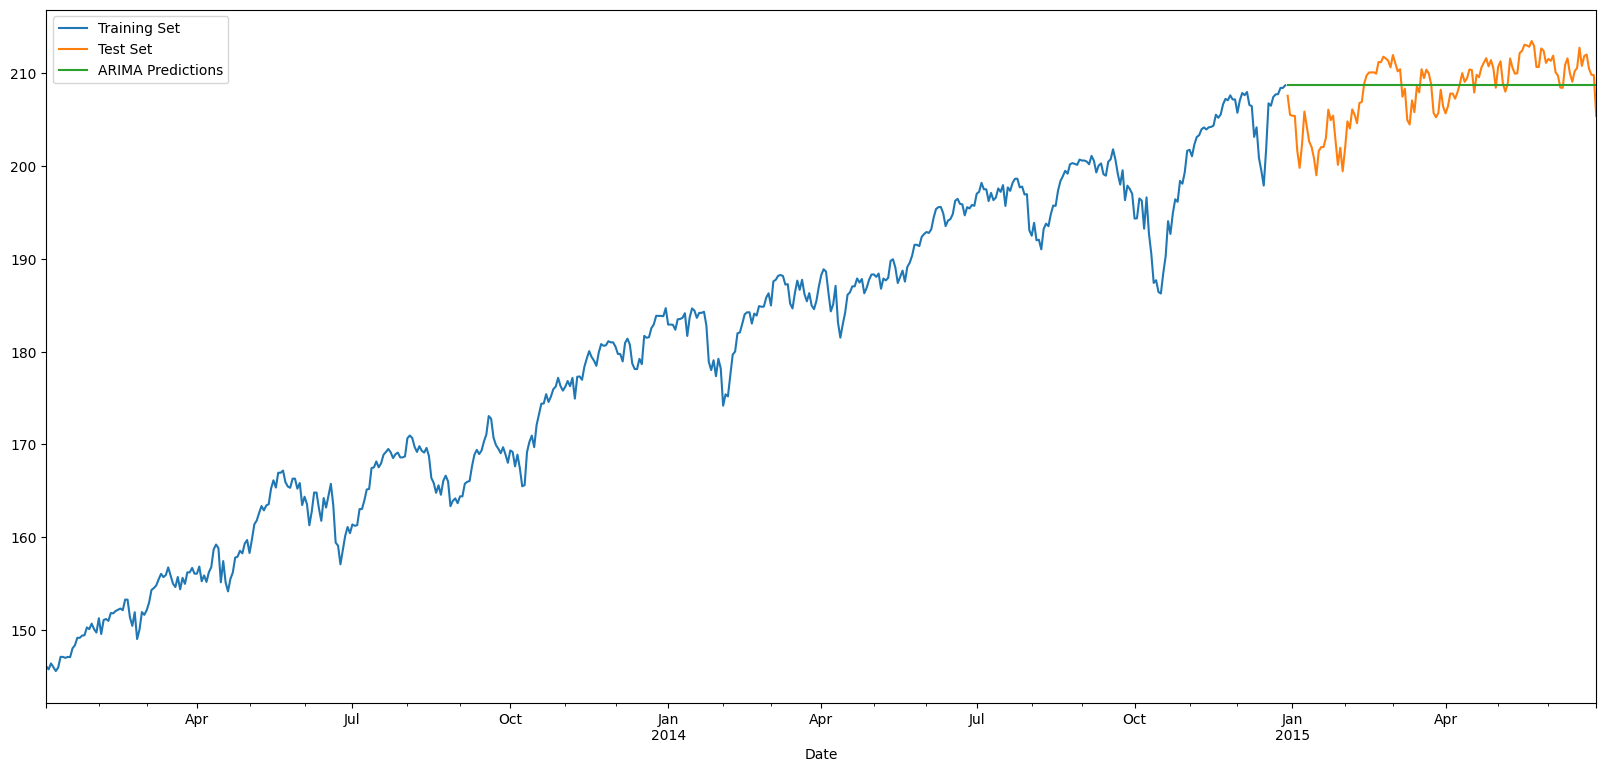

In [214]:
model = ARIMA(train_set['Close'],order = order)
results = model.fit()
results.summary()

start=len(train_set)
end=len(train_set)+len(test_set)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA Predictions')

train_set['Close'].rename('Training Set').plot(legend=True)
test_set['Close'].rename('Test Set').plot(legend=True)
predictions.plot(legend = True)
plt.show()

In [215]:
# Calculate Evaluation Metrics
y_test = test_set['Close']
y_pred = predictions
pd.DataFrame({'y_test': y_test, 'y_pred' : y_pred, 'diff':y_test - y_pred})

y_test      y_pred      diff
2014-12-30  207.600006  208.720001 -1.119995
2014-12-31  205.539993  208.720001 -3.180008
2015-01-01  205.429993  208.720001 -3.290009
2015-01-02  205.429993  208.720001 -3.290009
2015-01-05  201.720001  208.720001 -7.000000
...                ...         ...       ...
2015-06-23  212.039993  208.720001  3.319992
2015-06-24  210.500000  208.720001  1.779999
2015-06-25  209.860001  208.720001  1.139999
2015-06-26  209.820007  208.720001  1.100006
2015-06-29  205.419998  208.720001 -3.300003

[130 rows x 3 columns]

In [216]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('MSE = ', mean_squared_error(y_test,y_pred))
print('RMSE = ', np.sqrt(mean_squared_error(y_test,y_pred)))
print('MAE = ', mean_absolute_error(y_test,y_pred))

MSE =  11.971797943699102
RMSE =  3.460028604462556
MAE =  2.769538996769832


In [217]:
plt.rcParams['figure.figsize'] = (20, 9)

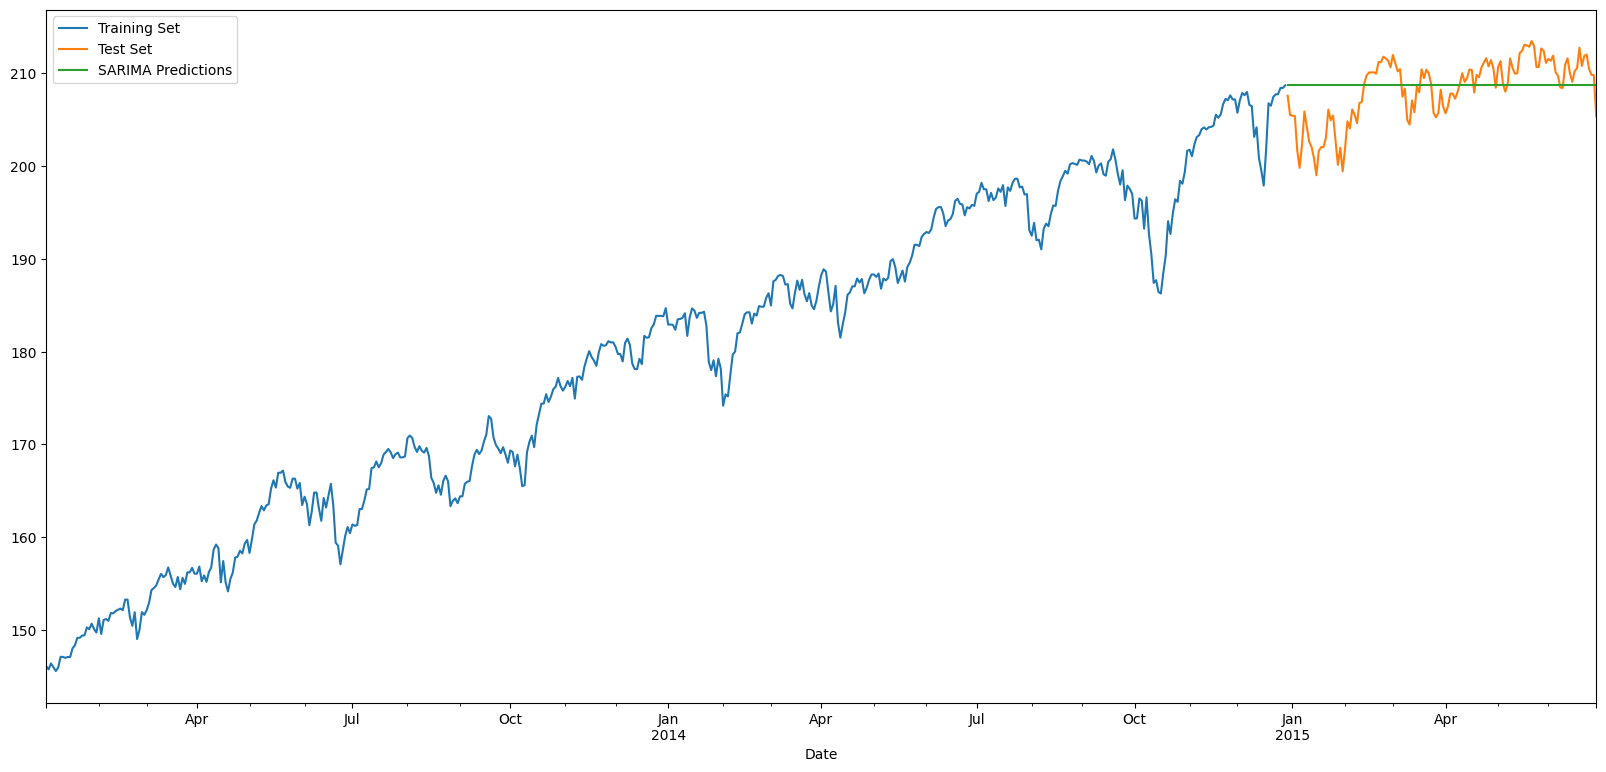

In [218]:
# Create and fit model
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_set['Close'],order=order,seasonal_order=seasonal_order)
results = model.fit()


start=len(train_set)
end=len(train_set)+len(test_set)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')

train_set['Close'].rename('Training Set').plot(legend=True)
test_set['Close'].rename('Test Set').plot(legend=True)
predictions.plot(legend = True)
plt.show()

In [219]:
# Calculate Evaluation Metrics
y_test = test_set['Close']
y_pred = predictions
pd.DataFrame({'y_test': y_test, 'y_pred' : y_pred, 'diff':y_test - y_pred})

y_test      y_pred      diff
2014-12-30  207.600006  208.720001 -1.119995
2014-12-31  205.539993  208.720001 -3.180008
2015-01-01  205.429993  208.720001 -3.290009
2015-01-02  205.429993  208.720001 -3.290009
2015-01-05  201.720001  208.720001 -7.000000
...                ...         ...       ...
2015-06-23  212.039993  208.720001  3.319992
2015-06-24  210.500000  208.720001  1.779999
2015-06-25  209.860001  208.720001  1.139999
2015-06-26  209.820007  208.720001  1.100006
2015-06-29  205.419998  208.720001 -3.300003

[130 rows x 3 columns]

In [220]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('MSE = ', mean_squared_error(y_test,y_pred))
print('RMSE = ', np.sqrt(mean_squared_error(y_test,y_pred)))
print('MAE = ', mean_absolute_error(y_test,y_pred))

MSE =  11.971797943699102
RMSE =  3.460028604462556
MAE =  2.769538996769832
